In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_columns', None) # display all columns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
# import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Sklearn
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.dummy import DummyRegressor
from sklearn.feature_selection import SelectPercentile, chi2, VarianceThreshold,SelectKBest,RFE,f_classif
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, FunctionTransformer, LabelEncoder, RobustScaler

# Import Regression models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR

import time

---
# Data Analysis
* The goals for this phase are to investigate the following:
    1. Target Feature Distribution
    2. Missing Values
    3. Distribution of the Numerical Variables
    4. Categorical Variables
    5. Cardinality of Categorical Variables
    6. Outliers
    7. Relationship between independent and dependent features (SalePrice)    

# Import data

In [3]:
df_train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
df_test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [4]:
print('The full df_train shape is {rows} rows and {columns} columns.'.format(rows=df_train.shape[0], columns=df_train.shape[1]))
print('The full df_test shape is {rows} rows and {columns} columns.'.format(rows=df_test.shape[0], columns=df_test.shape[1]))

The full df_train shape is 1460 rows and 81 columns.
The full df_test shape is 1459 rows and 80 columns.


# Preview the dataset

In [5]:
df_train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd        NaN   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng        NaN   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

In [6]:
df_test.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl        NAmes      Feedr   
1         Lvl    AllPub    Corner       Gtl        NAmes       Norm   
2         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
3         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
4         HLS    AllPub    Inside       Gtl      StoneBr       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     1Story            5            6       1961   
1       Norm     1Fam     1Story            6            6       1958   
2       Norm     1Fam     2Story            5            5       1997   
3       Norm     1Fam     2Story            6            6       1998   
4       Norm   TwnhsE     1Story            8            5       1992   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          1961     Gable  CompShg     VinylSd     VinylSd        NaN   
1          1958       Hip  CompShg     Wd Sdng     Wd Sdng    BrkFace   
2          1998     Gable  CompShg     VinylSd     VinylSd        NaN   
3          1998     Gable  CompShg     VinylSd     VinylSd    BrkFace   
4          1992     Gable  CompShg     HdBoard     HdBoard        NaN   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0         0.0        TA        TA     CBlock       TA       TA           No   
1       108.0        TA        TA     CBlock       TA       TA           No   
2         0.0        TA        TA      PConc       Gd       TA           No   
3        20.0        TA        TA      PConc       TA       TA           No   
4         0.0        Gd        TA      PConc       Gd       TA           No   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          Rec       468.0          LwQ       144.0      270.0        882.0   
1          ALQ       923.0          Unf         0.0      406.0       1329.0   
2          GLQ       791.0          Unf         0.0      137.0        928.0   
3          GLQ       602.0          Unf         0.0      324.0        926.0   
4          ALQ       263.0          Unf         0.0     1017.0       1280.0   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        TA          Y      SBrkr       896         0             0   
1    GasA        TA          Y      SBrkr      1329         0             0   
2    GasA        Gd          Y      SBrkr       928       701             0   
3    GasA        Ex          Y      SBrkr       926       678             0   
4    GasA        Ex          Y      SBrkr      1280         0             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0        896           0.0           0.0         1         0             2   
1       1329           0.0           0.0         1         1             3   
2       1629           0.0           0.0         2         1             3   
3       1604           0.0           0.0         2         1             3   
4       1280           0.0           0.0         2         0             2   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          TA             5        Typ           0         NaN   
1             1          Gd             6        Typ           0         NaN   
2             1          TA             6        Typ           1          TA   
3             1          Gd  

In [7]:
df_train.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

* The df_train dataset contains 79 feature columns consisting of:
    * 43 categorical features
    * 37 numerical features.
    * 1 target variable: 'SalePrice'

In [9]:
df_train.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726   
std       1.112799    30.202904     20.645407   181.066207   456.098091   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000   

        BsmtFinSF2    BsmtUnfSF  TotalBsmtSF     1stFlrSF     2ndFlrSF  \
count  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean     46.549315   567.240411  1057.429452  1162.626712   346.992466   
std     161.319273   441.866955   438.705324   386.587738   436.528436   
min       0.000000     0.000000     0.000000   334.000000     0.000000   
25%       0.000000   223.000000   795.750000   882.000000     0.000000   
50%       0.000000   477.500000   991.500000  1087.000000     0.000000   
75%       0.000000   808.000000  1298.250000  1391.250000   728.000000   
max    1474.000000  2336.000000  6110.000000  4692.000000  2065.000000   

       LowQualFinSF    GrLivArea  BsmtFullBath  BsmtHalfBath     FullBath  \
count   1460.000000  1460.000000   1460.000000   1460.000000  1460.000000   
mean       5.844521  1515.463699      0.425342      0.057534     1.565068   
std       48.623081   525.480383      0.518911      0.238753     0.550916   
min        0.000000   334.000000      0.000000      0.000000     0.000000   
25%        0.000000  1129.500000      0.000000      0.000000     1.000000   
50%        0.000000  1464.000000      0.000000      0.000000     2.000000   
75%        0.000000  1776.750000      1.000000      0.000000     2.000000   
max      572.000000  5642.000000      3.000000      2.000000     3.000000   

          HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd   Fireplaces  \
count  1460.000000   1460.000000   1460.000000   1460.000000  1460.000000   
mean      0.382877      2.866438      1.046575      6.517808     0.613014   
std       0.502885      0.815778      0.220338      1.625393     0.644666   
min       0.000000      0.000000      0.000000      2.000000     0.000000   
25%       0.000000      2.000000      1.000000      5.000000     0.000000   
50%       0.000000      3.000000      1.000000      6.000000     1.000000   
75%       1.000000      3.000000      1.000000      7.000000     1.000000   
max       2.000000      8.000000      3.000000     14.000000     3.000000   

       GarageYrBlt   GarageCars   GarageArea   WoodDeckSF  OpenPorchSF  \
count  1379.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean   1978.506164     1.767123   472.980137    94.244521    46.660274   
std      24.689725     0.747315   213.804841   125.338794    66.256028   
min    1900.000000     0.000000     0.000000     0.000000     0.000000   
25%    1961.000000     1.000000   334.500000     0.000000     0.000000   
50%    1980.000000     2.000000   480.000000     0.000000    25.000000   
75%    2002.000000     2.000000   576.000000   168.000000    68.000000   
max    2

---
# Target Variable Distribution

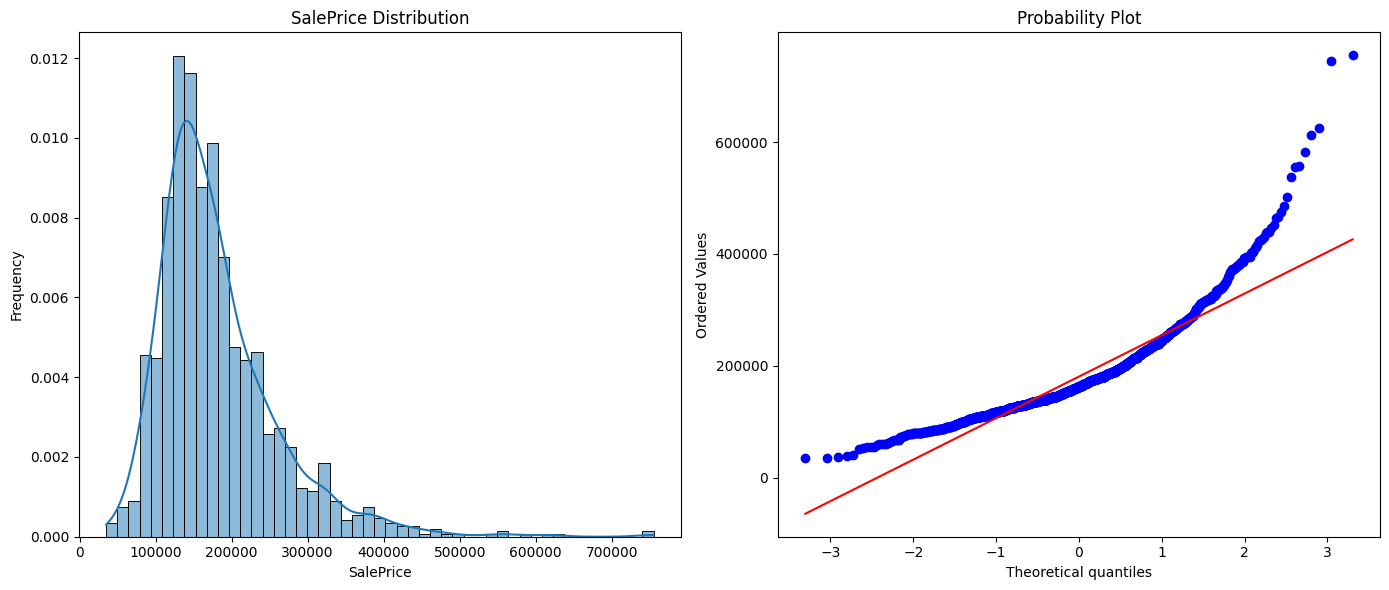

Skewness: 1.882876
Kurtosis: 6.536282


In [10]:
from scipy import stats

# Create figure for 2 subplots 
fig, axs = plt.subplots(1,2,figsize=(14,6))

# Distribution
sns.histplot(df_train, x='SalePrice', kde=True, stat='frequency', ax=axs[0])
axs[0].set_title('SalePrice Distribution')

# Probability Plot
res = stats.probplot(df_train['SalePrice'], plot=plt)

plt.tight_layout()
plt.show()

#skewness and kurtosis
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

### SalePrice appears to be right-skewed with skewness of 1.88.
* Mean is greater than median.
* Mode is less than both mean and median.

### Kurtosis value of 6.53 indicates Leptokurtic distribution.
* More values concentrated around mean than normal distribution.
* Heavier tails due to higher concentration of extreme values or outliers in tails.

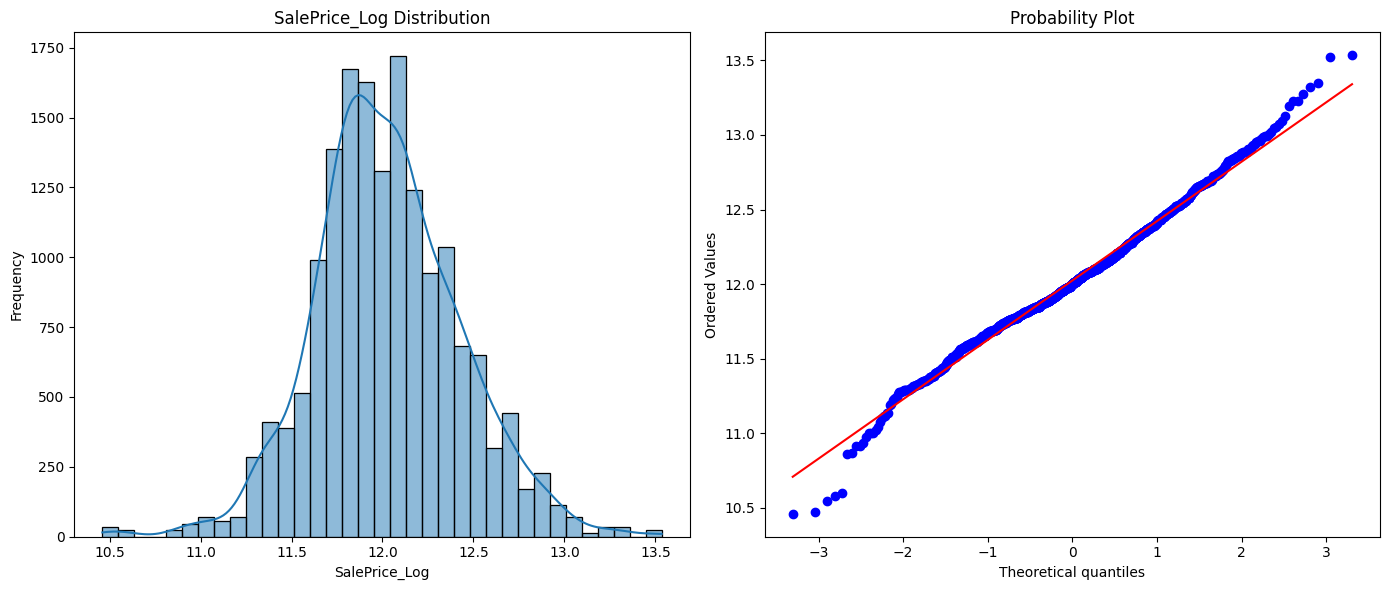

Skewness: 0.121347
Kurtosis: 0.809519


In [11]:
data = df_train.copy()

# Apply Log Transformation to SalePrice
data['SalePrice_Log']=np.log1p(data['SalePrice'])

# Create figure for 2 subplots 
fig, axs = plt.subplots(1,2,figsize=(14,6))

# Distribution
sns.histplot(data, x='SalePrice_Log', kde=True, stat='frequency', ax=axs[0])
axs[0].set_title('SalePrice_Log Distribution')

# Probability Plot
res = stats.probplot(data['SalePrice_Log'], plot=plt)

plt.tight_layout()
plt.show()

#skewness and kurtosis
print("Skewness: %f" % data['SalePrice_Log'].skew())
print("Kurtosis: %f" % data['SalePrice_Log'].kurt())

### Log-transformed SalePrice shows:
* approximately symmetric skew with value of 0.12. 
* Mesokurtic distribution (nearly perfectly normal distribution) with value of 0.81.

---
# Missing Values

In [12]:
features_with_nan = [features for features in df_train.columns if df_train[features].isna().sum()>=1]

df_train[features_with_nan].isna().sum()

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

* Numerous missing values, so the relationship between missing values and SalesPrice needs to be explored.
* Data is heterogeneous, meaning both numerical and categorical data types available.

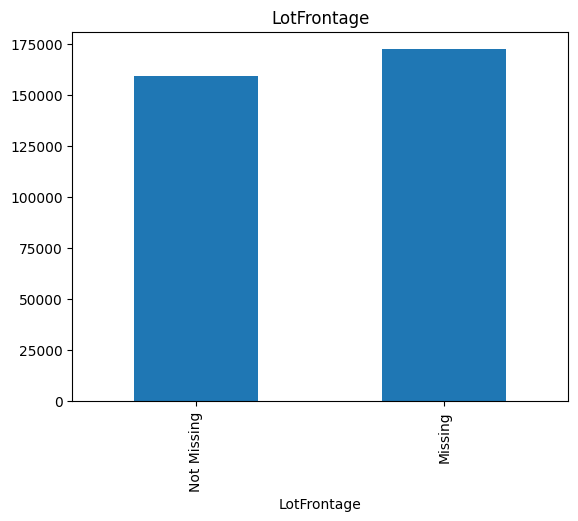

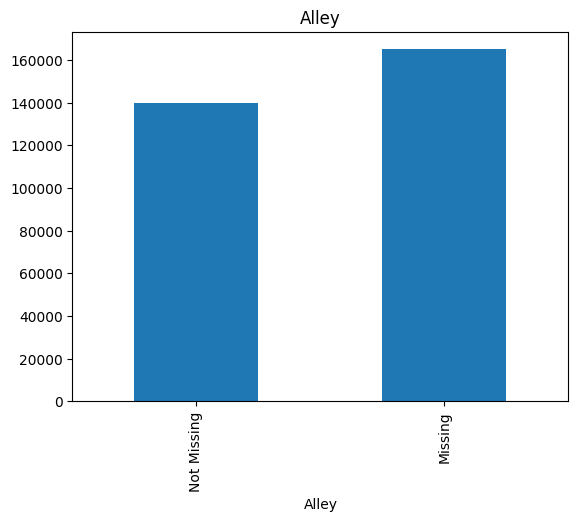

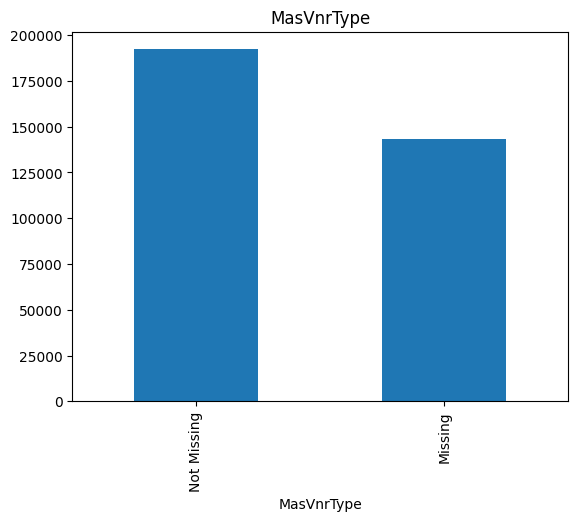

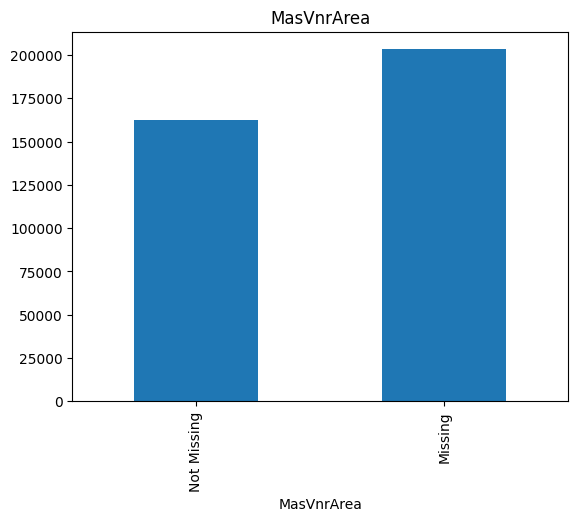

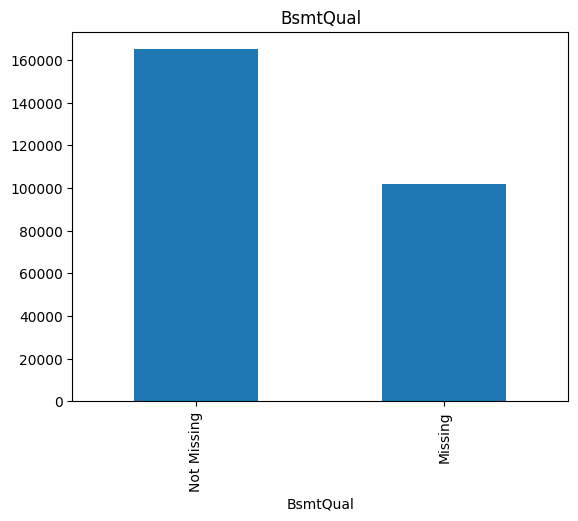

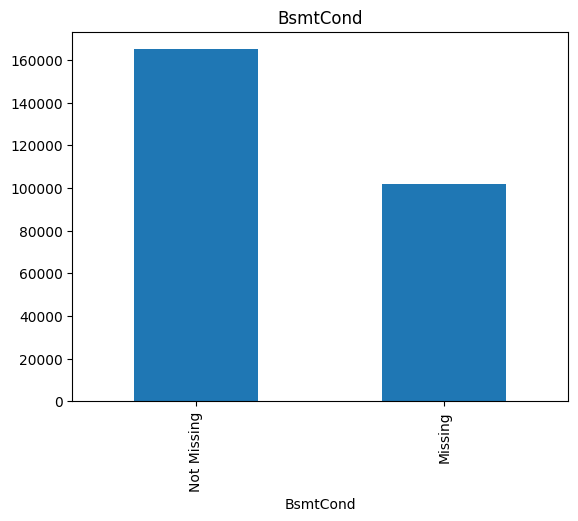

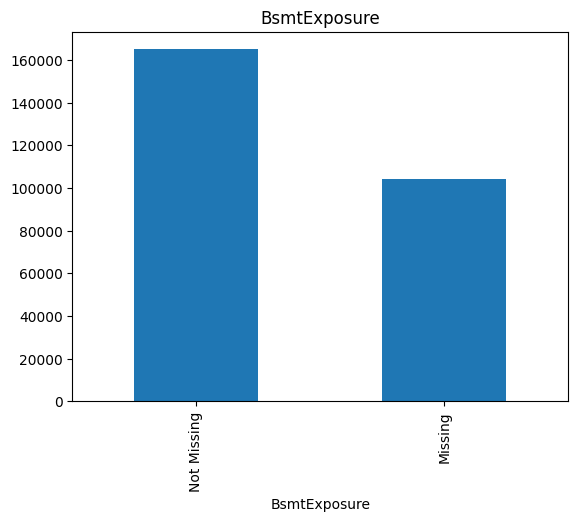

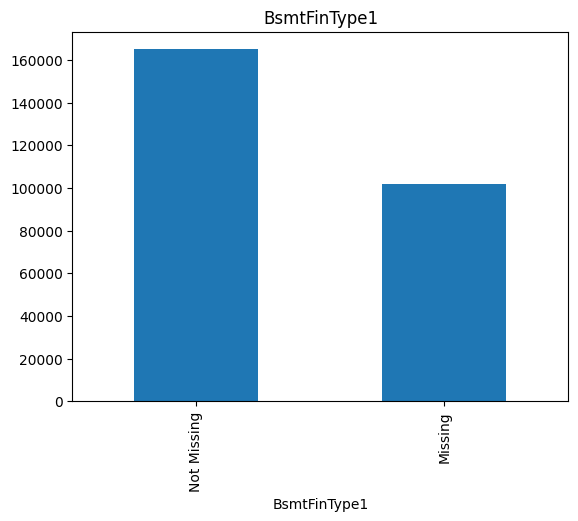

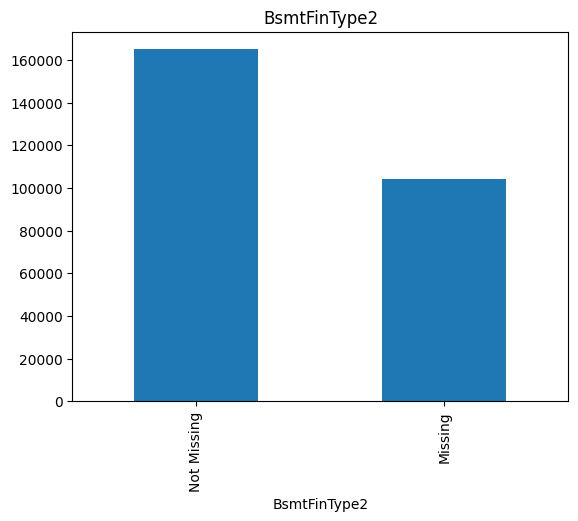

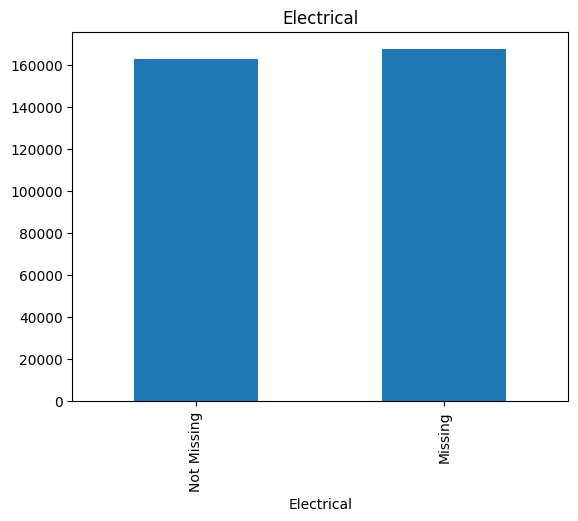

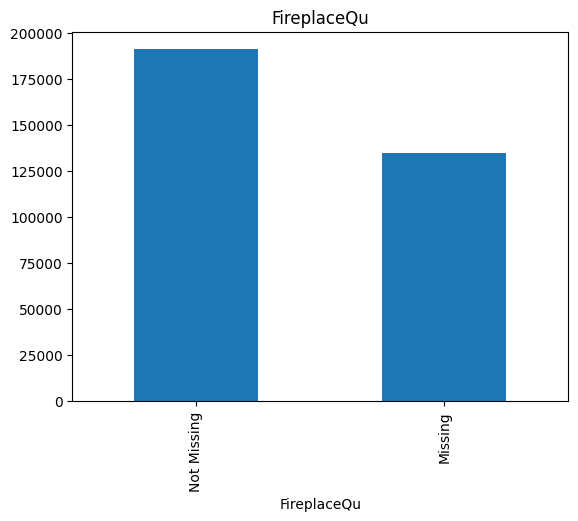

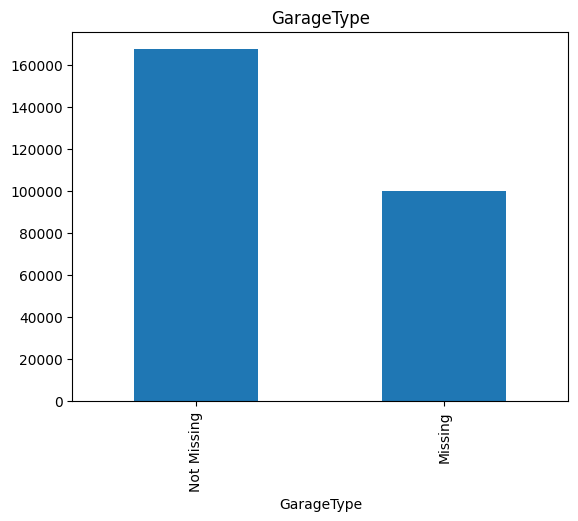

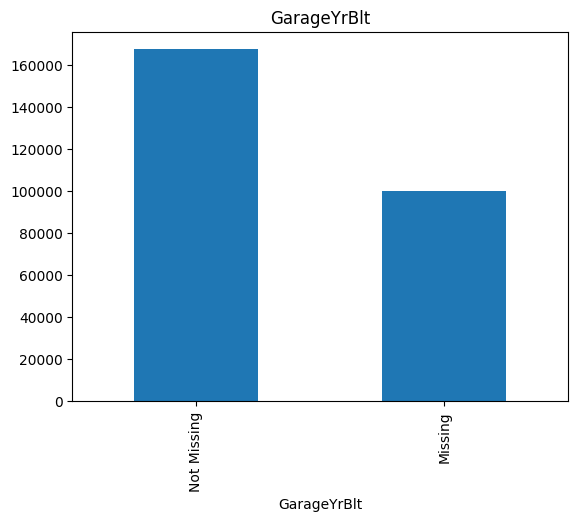

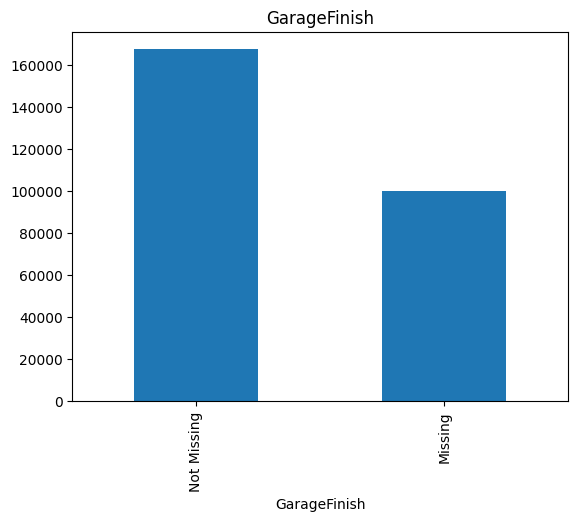

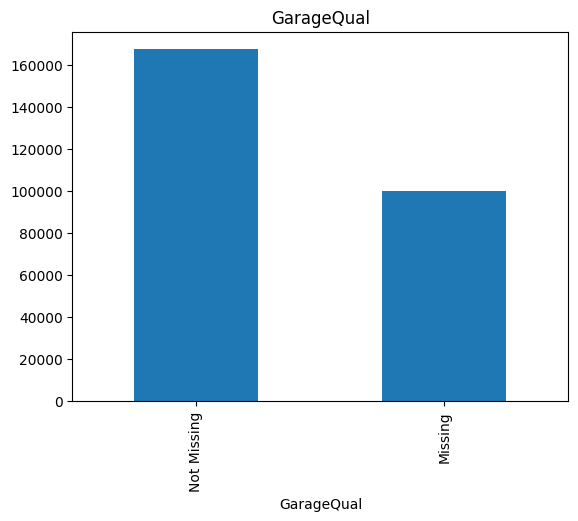

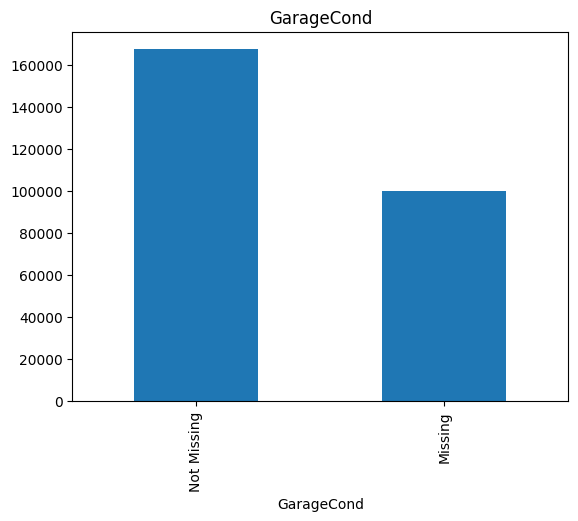

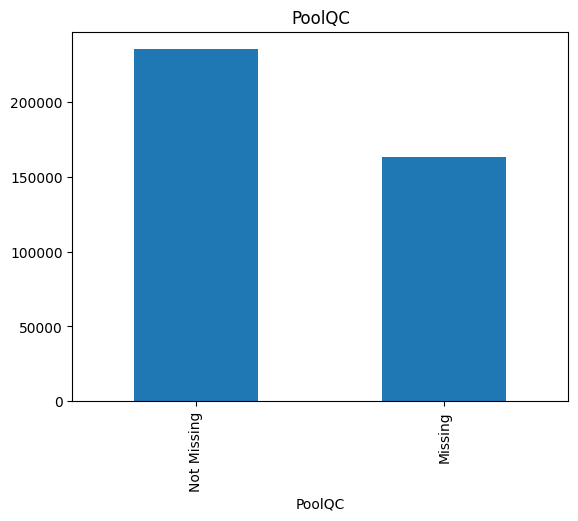

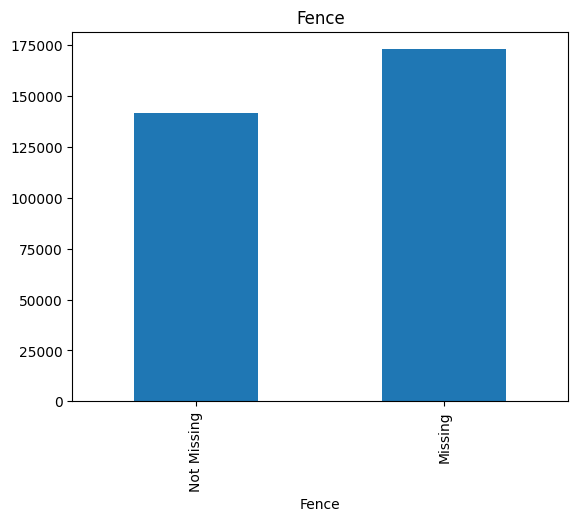

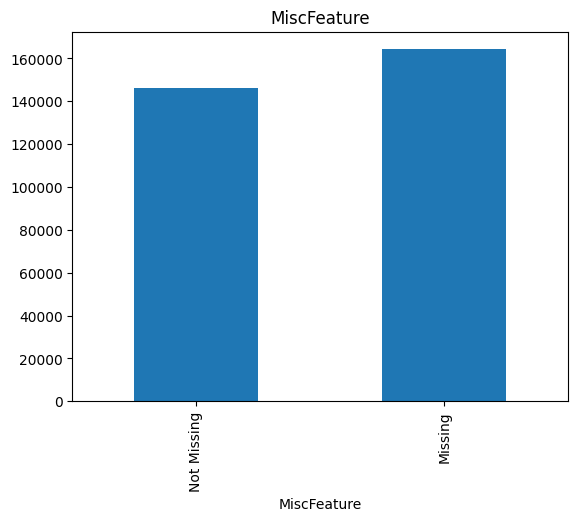

In [13]:
data = df_train.copy()
for feature in features_with_nan:
    # Variable where 1 indicates missing value or 0 indicates not missing
    data[feature] = np.where(data[feature].isnull(), 1, 0)
    # Calculate median SalePrice when missing vs not missing
    data.groupby(feature)['SalePrice'].median().plot.bar()
    plt.title(feature)
    plt.xticks([0, 1], ['Not Missing', 'Missing'])
    plt.show()

### Graphs indicate a relationship between the missing values and dependent variables, meaning they are not random. Will need to fix via feature engineering.

---
# EDA
## Numerical Features

In [14]:
num_features = list(df_train.select_dtypes(include='number').columns)
print(f"Number of numerical features: {len(num_features)}")
df_train[num_features].head()

Number of numerical features: 38


Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0   1          60         65.0     8450            7            5       2003   
1   2          20         80.0     9600            6            8       1976   
2   3          60         68.0    11250            7            5       2001   
3   4          70         60.0     9550            7            5       1915   
4   5          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          2003       196.0         706           0        150          856   
1          1976         0.0         978           0        284         1262   
2          2002       162.0         486           0        434          920   
3          1970         0.0         216           0        540          756   
4          2000       350.0         655           0        490         1145   

   1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
0       856       854             0       1710             1             0   
1      1262         0             0       1262             0             1   
2       920       866             0       1786             1             0   
3       961       756             0       1717             1             0   
4      1145      1053             0       2198             1             0   

   FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  \
0         2         1             3             1             8           0   
1         2         0             3             1             6           1   
2         2         1             3             1             6           1   
3         1         0             3             1             7           1   
4         2         1             4             1             9           1   

   GarageYrBlt  GarageCars  GarageArea  WoodDeckSF  OpenPorchSF  \
0       2003.0           2         548           0           61   
1       1976.0           2         460         298            0   
2       2001.0           2         608           0           42   
3       1998.0           3         642           0           35   
4       2000.0           3         836         192           84   

   EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  MoSold  YrSold  \
0              0          0            0         0        0       2    2008   
1              0          0            0         0        0       5    2007   
2              0          0            0         0        0       9    2008   
3            272          0            0         0        0       2    2006   
4              0          0            0         0        0      12    2008   

   SalePrice  
0     208500  
1     181500  
2     223500  
3     140000  
4     250000

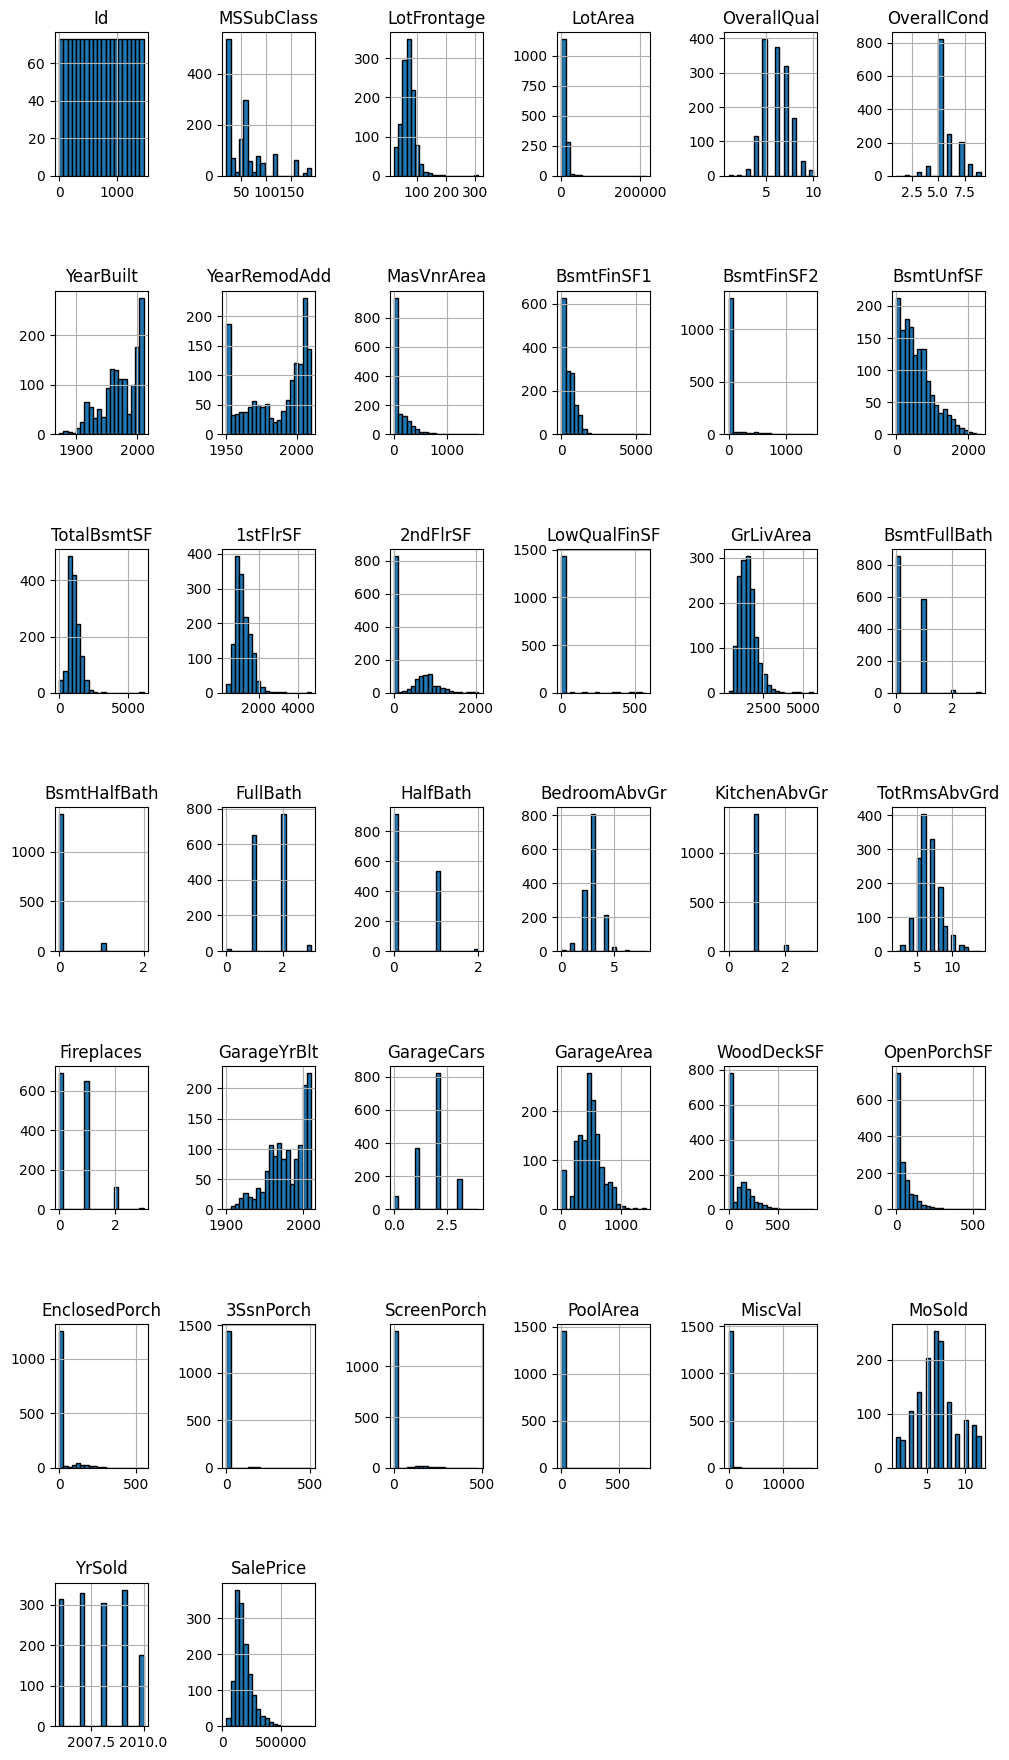

In [15]:
df_train[num_features].hist(bins=20, edgecolor='black', figsize=(12,22))
plt.subplots_adjust(hspace=0.8, wspace=0.8)
plt.show()

### Numerical data types can be broken down into 3 categories:
1. Date-Time
2. Discrete
3. Continuous

---
### 1. Date-Time Numerical features 
* Years: YearBuilt, YearRemodAdd, GarageYrBlt, YrSold
* Months:'MoSold'

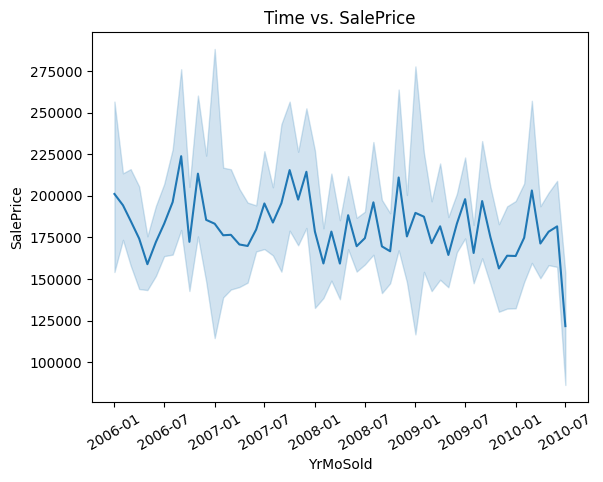

In [16]:
data=df_train.copy()
data['YrMoSold']=pd.to_datetime(data['YrSold'].astype(str) + data['MoSold'].astype(str).str.zfill(2),format='%Y%m')

# Plot Time vs SalePrice
sns.lineplot(data=data, x='YrMoSold', y='SalePrice')
plt.title('Time vs. SalePrice')
plt.xticks(rotation=30)
plt.show()

In [17]:
# Create list of features containing information about years
datetime_features = [feature for feature in num_features if 'Year' in feature or 'Yr' in feature or 'Mo' in feature]
datetime_features

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold']

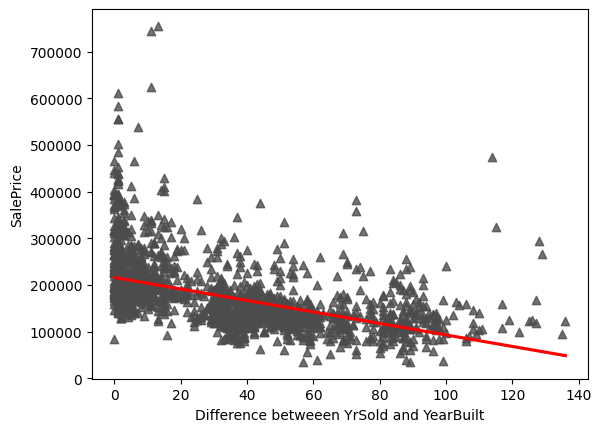

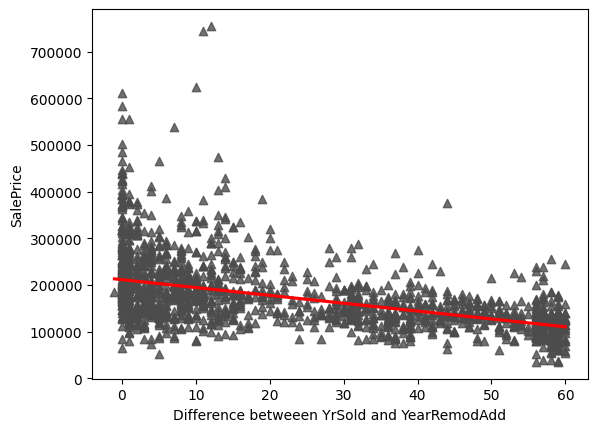

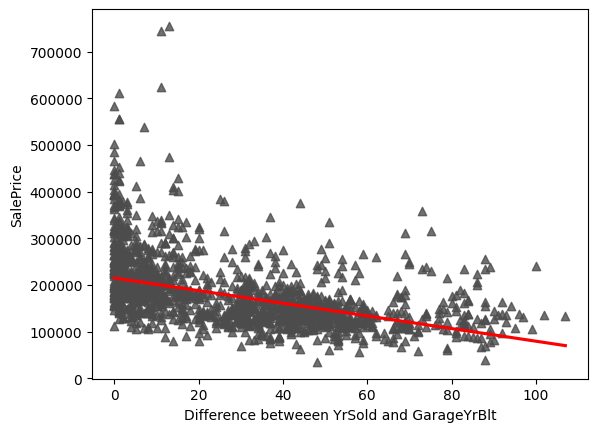

In [18]:
## Here we will compare the difference between All years feature with SalePrice
data=df_train.copy()

excluded_dt_features = {'YrSold', 'MoSold'}
for feature in datetime_features:
    if feature not in excluded_dt_features:
        ## We will capture the difference between year variable and year the house was sold for
        data[feature] = data['YrSold'] - data[feature]
        sns.regplot(x=data[feature], y=data['SalePrice'], ci=None, robust=True, marker="^", color=".3", line_kws=dict(color="r"))
        plt.xlabel('Difference betweeen YrSold and '+feature)
        plt.ylabel('SalePrice')
        plt.show()

---
### 2. Discrete Variables (and Continuous Variables)

In [19]:
discrete_features = [feature for feature in num_features if df_train[feature].nunique()<25 and feature not in datetime_features+['Id']]
print(f"Number of discrete features: {len(discrete_features)}")
df_train[discrete_features]

Number of discrete features: 16


MSSubClass  OverallQual  OverallCond  LowQualFinSF  BsmtFullBath  \
0             60            7            5             0             1   
1             20            6            8             0             0   
2             60            7            5             0             1   
3             70            7            5             0             1   
4             60            8            5             0             1   
...          ...          ...          ...           ...           ...   
1455          60            6            5             0             0   
1456          20            6            6             0             1   
1457          70            7            9             0             0   
1458          20            5            6             0             1   
1459          20            5            6             0             1   

      BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
0                0         2         1             3             1   
1                1         2         0             3             1   
2                0         2         1             3             1   
3                0         1         0             3             1   
4                0         2         1             4             1   
...            ...       ...       ...           ...           ...   
1455             0         2         1             3             1   
1456             0         2         0             3             1   
1457             0         2         0             4             1   
1458             0         1         0             2             1   
1459             0         1         1             3             1   

      TotRmsAbvGrd  Fireplaces  GarageCars  3SsnPorch  PoolArea  MiscVal  
0                8           0           2          0         0        0  
1                6           1           2          0         0        0  
2                6           1           2          0         0        0  
3                7           1           3          0         0        0  
4                9           1           3          0         0        0  
...            ...         ...         ...        ...       ...      ...  
1455             7           1           2          0         0        0  
1456             7           2           2          0         0        0  
1457             9           2           1          0         0     2500  
1458             5           0           1          0         0        0  
1459             6           0           1          0         0        0  

[1460 rows x 16 columns]

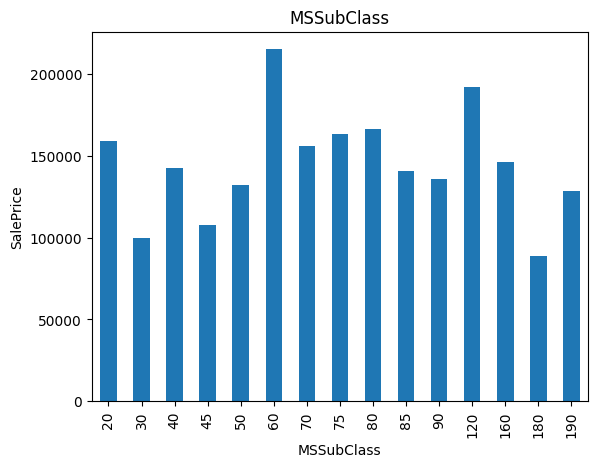

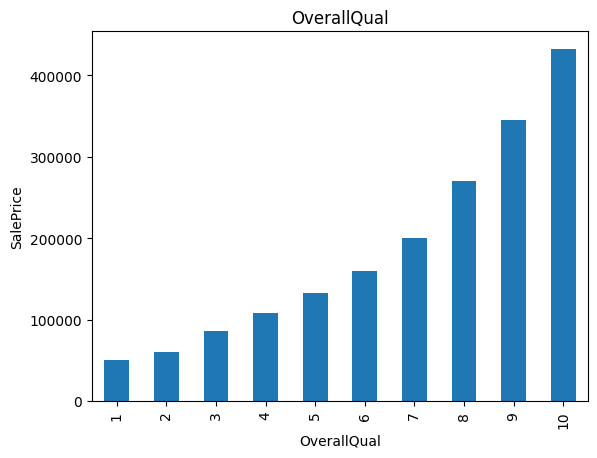

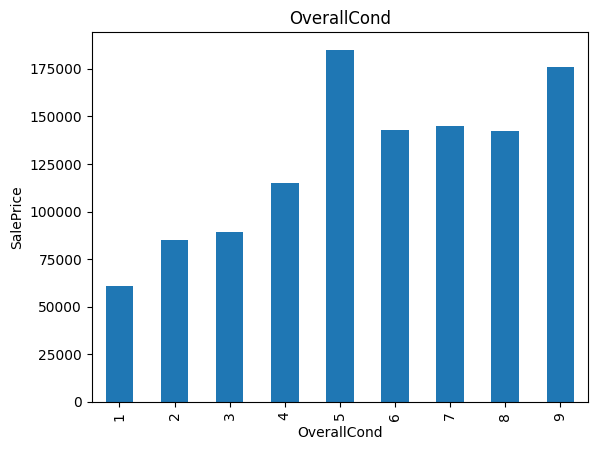

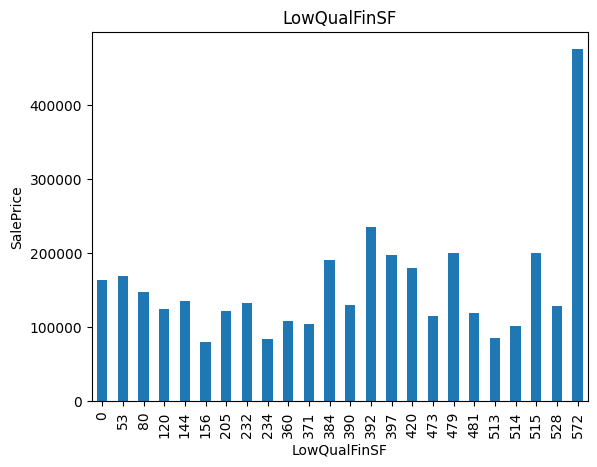

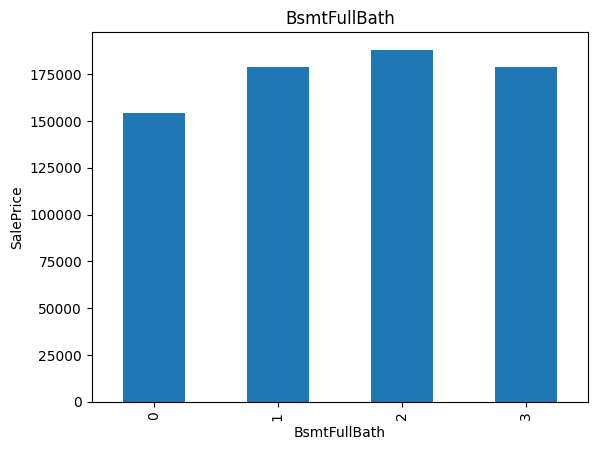

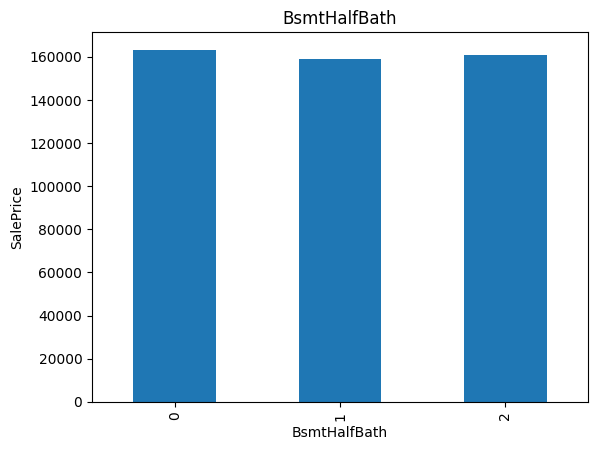

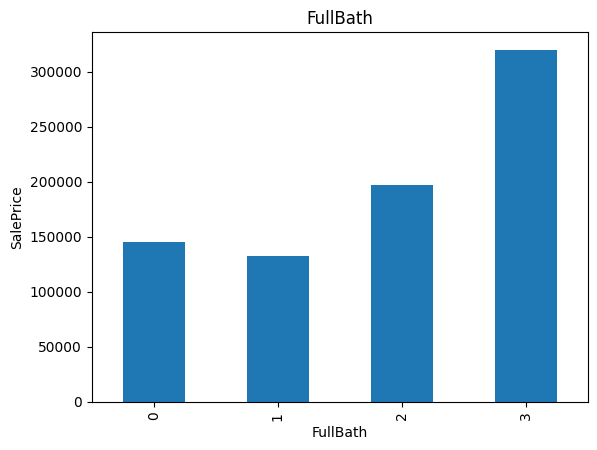

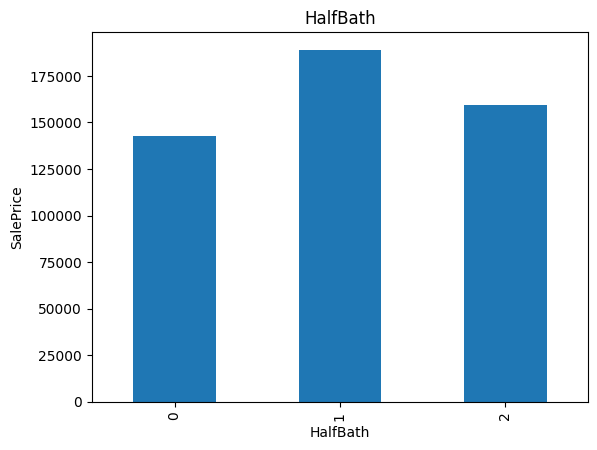

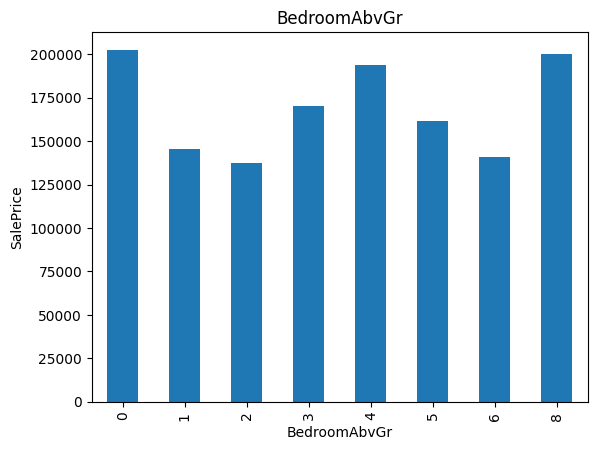

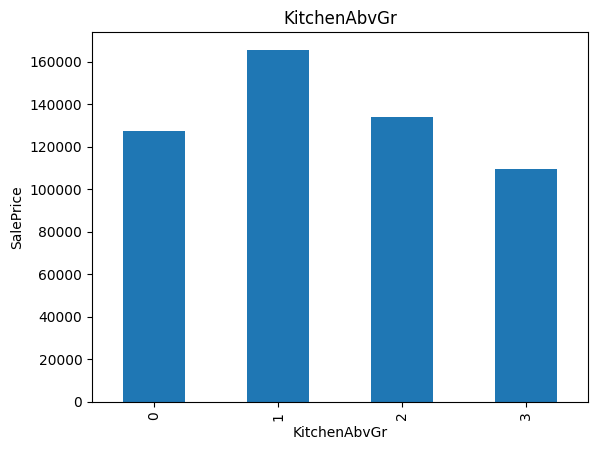

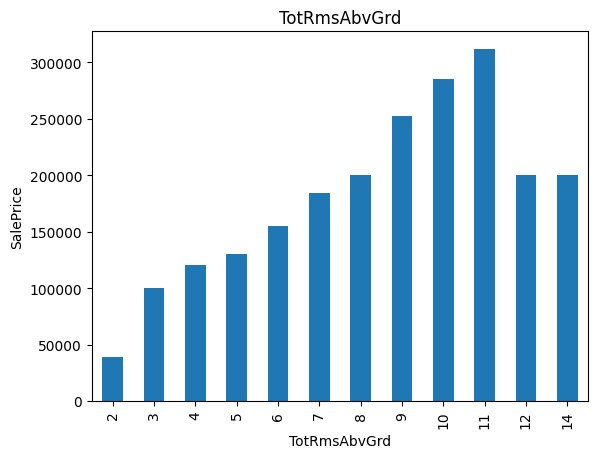

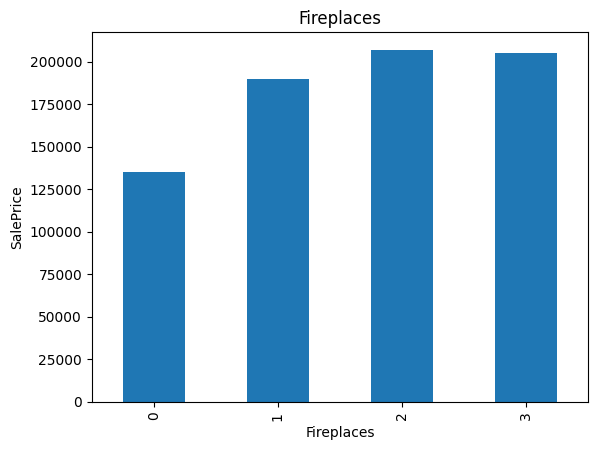

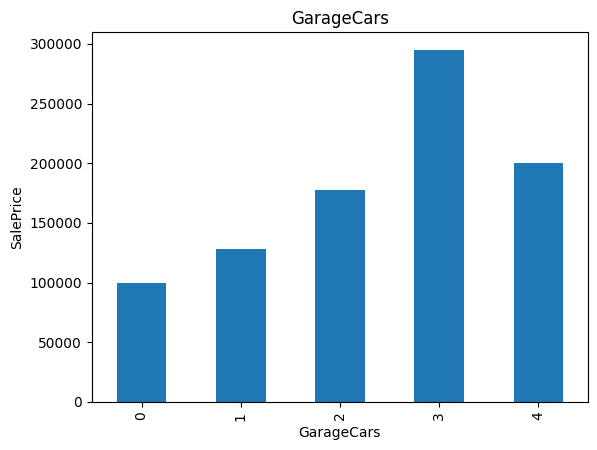

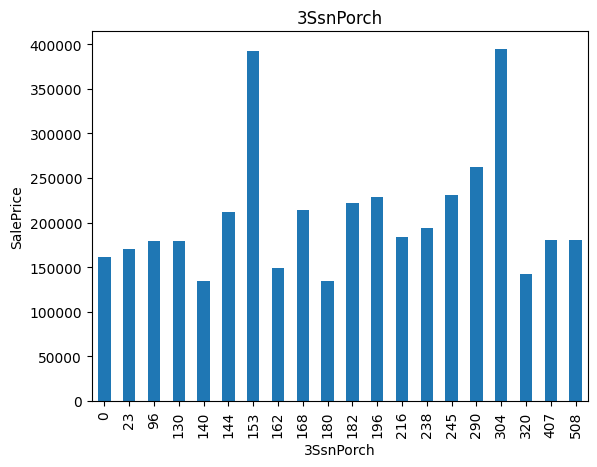

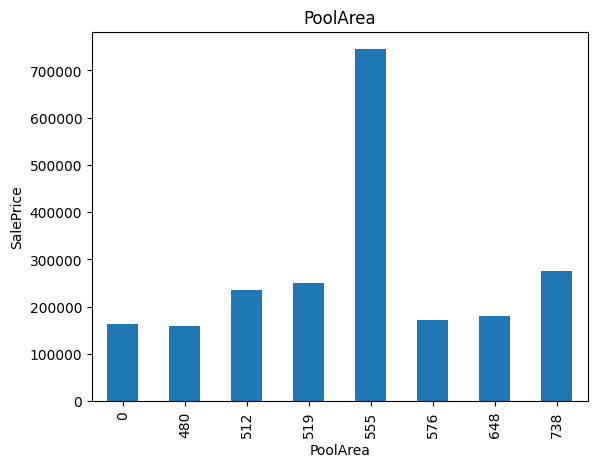

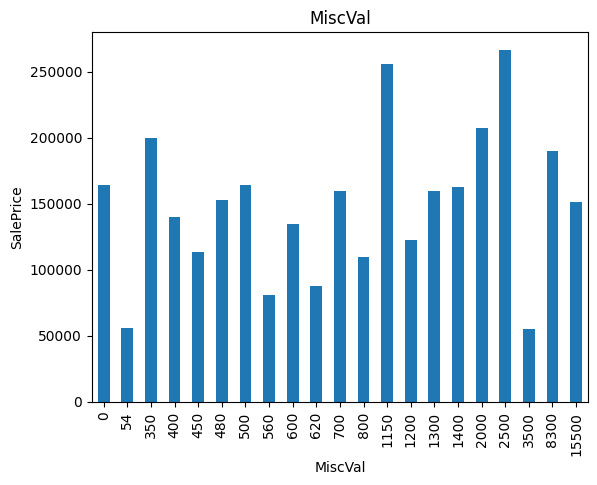

In [20]:
## Lets Find the realtionship between them and Sale PRice

for feature in discrete_features:
    df_train.groupby(feature)['SalePrice'].median().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
    plt.title(feature)
    plt.show()

### There is a distinct relationship between discrete variables such as OverallQual and SalePrice. 

---
### 3. Continous variables

In [21]:
continuous_features=[features for features in num_features if features not in discrete_features+datetime_features+['Id']]
print(f"Continuous feature Count: {len(continuous_features)}")
df_train[continuous_features]

Continuous feature Count: 16


LotFrontage  LotArea  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  \
0            65.0     8450       196.0         706           0        150   
1            80.0     9600         0.0         978           0        284   
2            68.0    11250       162.0         486           0        434   
3            60.0     9550         0.0         216           0        540   
4            84.0    14260       350.0         655           0        490   
...           ...      ...         ...         ...         ...        ...   
1455         62.0     7917         0.0           0           0        953   
1456         85.0    13175       119.0         790         163        589   
1457         66.0     9042         0.0         275           0        877   
1458         68.0     9717         0.0          49        1029          0   
1459         75.0     9937         0.0         830         290        136   

      TotalBsmtSF  1stFlrSF  2ndFlrSF  GrLivArea  GarageArea  WoodDeckSF  \
0             856       856       854       1710         548           0   
1            1262      1262         0       1262         460         298   
2             920       920       866       1786         608           0   
3             756       961       756       1717         642           0   
4            1145      1145      1053       2198         836         192   
...           ...       ...       ...        ...         ...         ...   
1455          953       953       694       1647         460           0   
1456         1542      2073         0       2073         500         349   
1457         1152      1188      1152       2340         252           0   
1458         1078      1078         0       1078         240         366   
1459         1256      1256         0       1256         276         736   

      OpenPorchSF  EnclosedPorch  ScreenPorch  SalePrice  
0              61              0            0     208500  
1               0              0            0     181500  
2              42              0            0     223500  
3              35            272            0     140000  
4              84              0            0     250000  
...           ...            ...          ...        ...  
1455           40              0            0     175000  
1456            0              0            0     210000  
1457           60              0            0     266500  
1458            0            112            0     142125  
1459           68              0            0     147500  

[1460 rows x 16 columns]

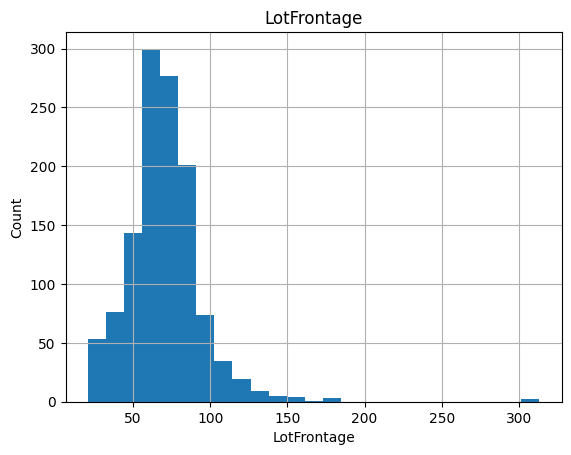

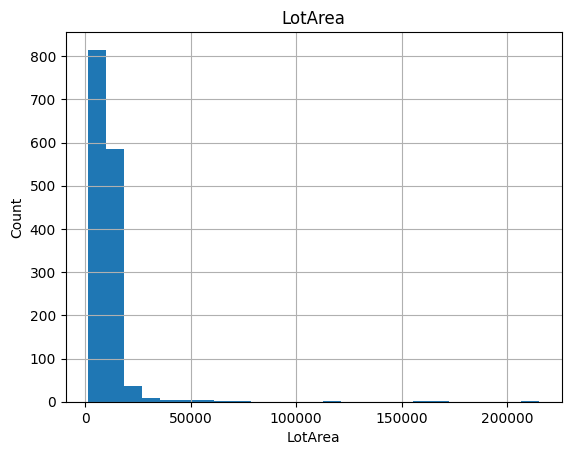

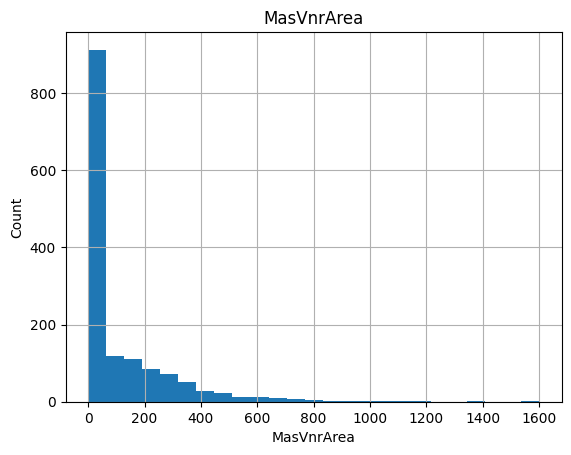

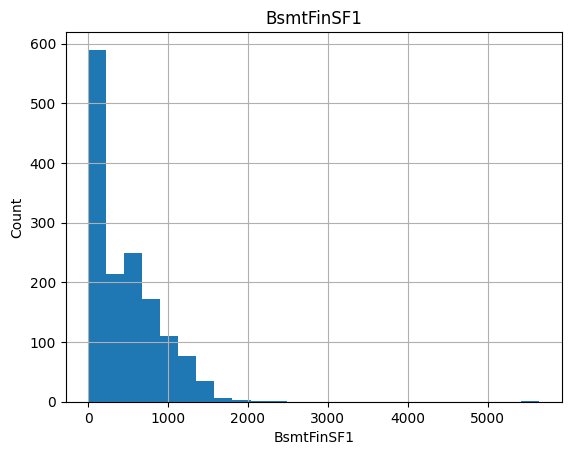

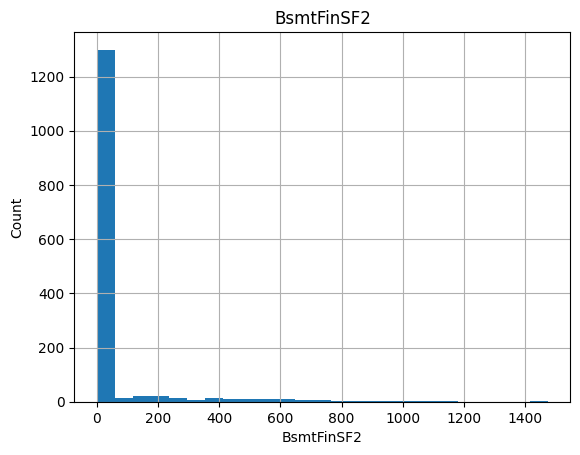

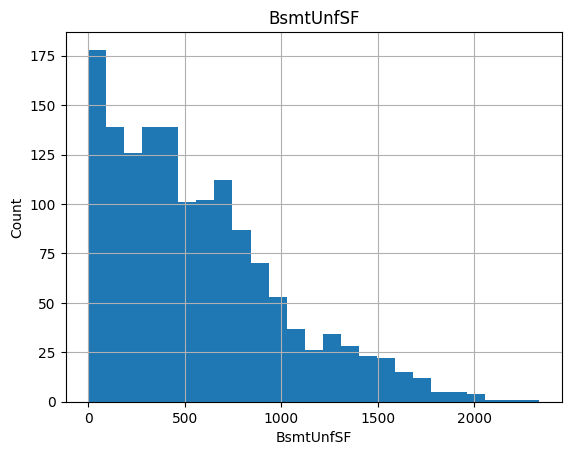

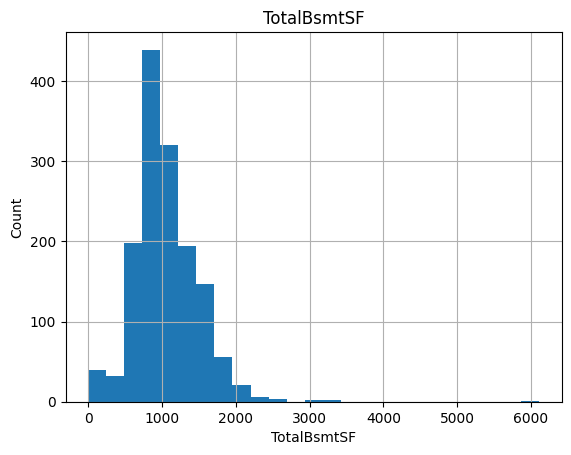

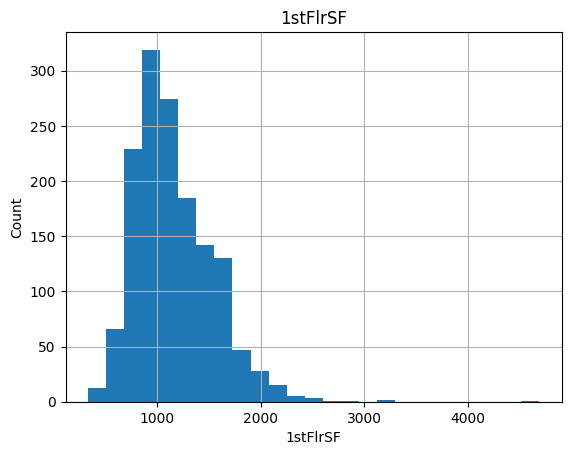

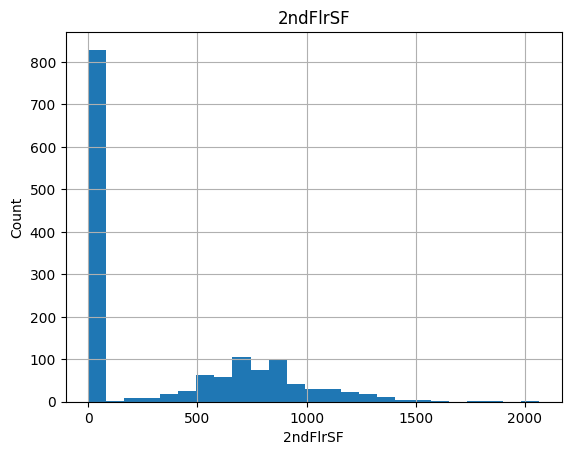

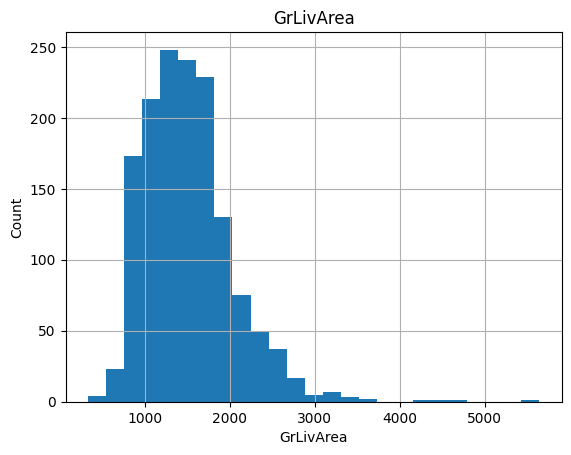

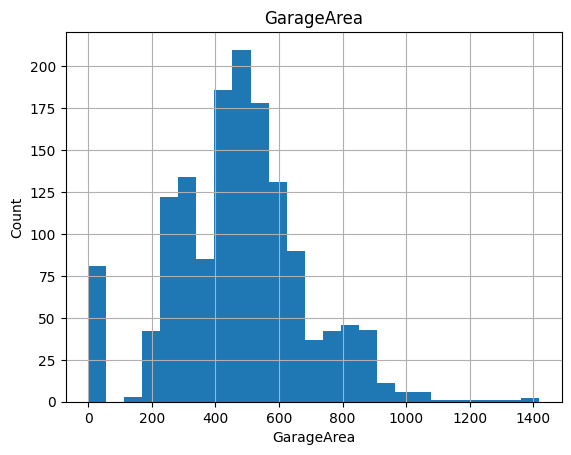

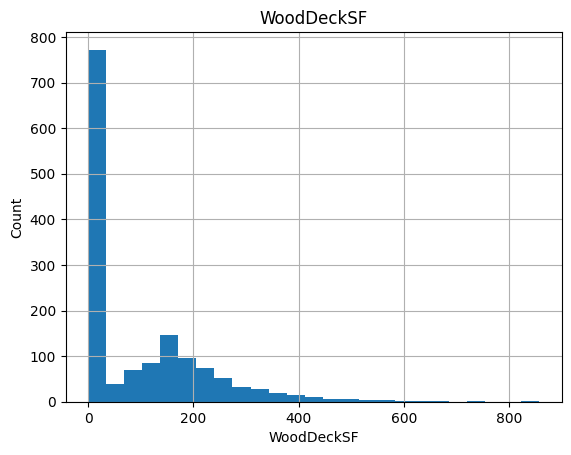

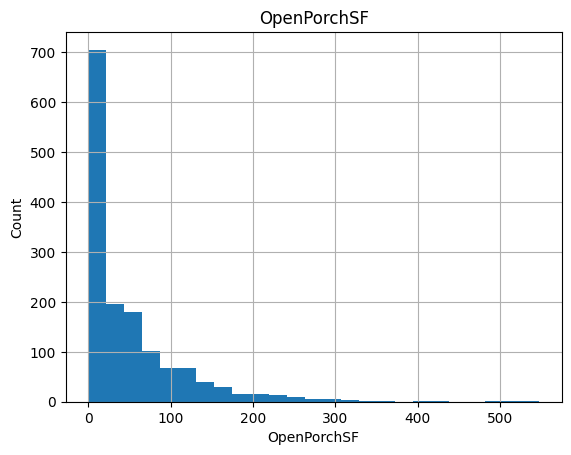

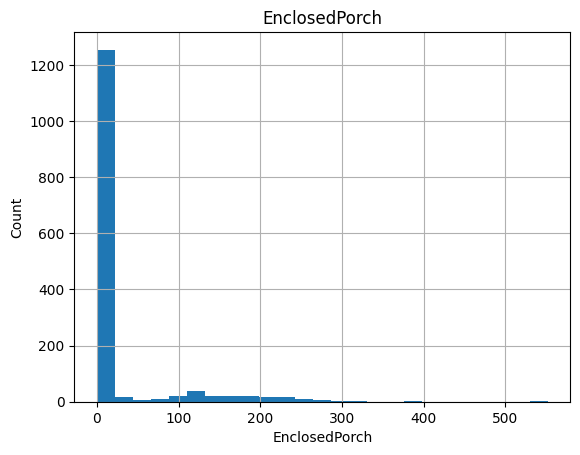

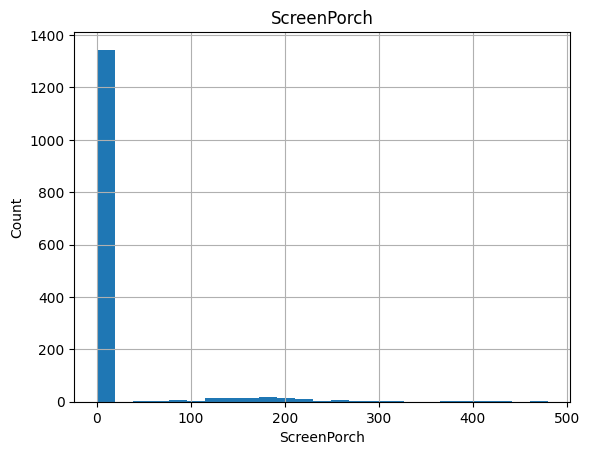

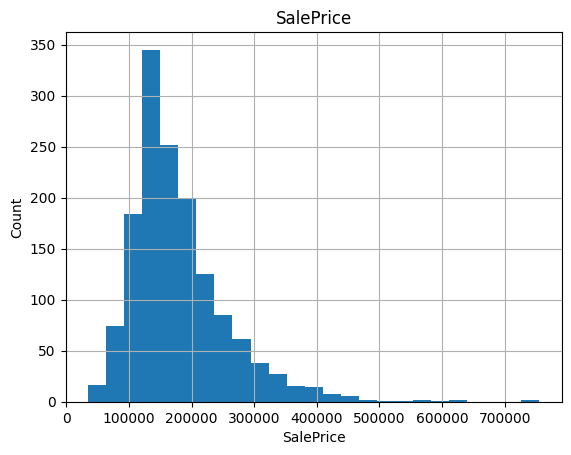

In [22]:
## Lets analyse the continuous values by creating histograms to understand the distribution
for feature in continuous_features:
    df_train[feature].hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

### Histograms indicate positve skew. Will check if log-transformation helps with distribution.

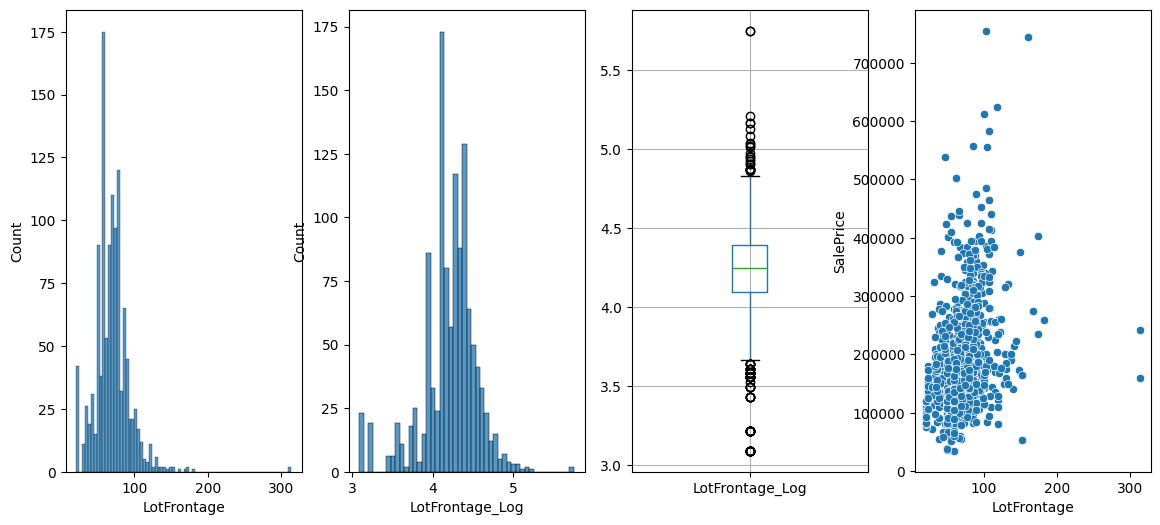

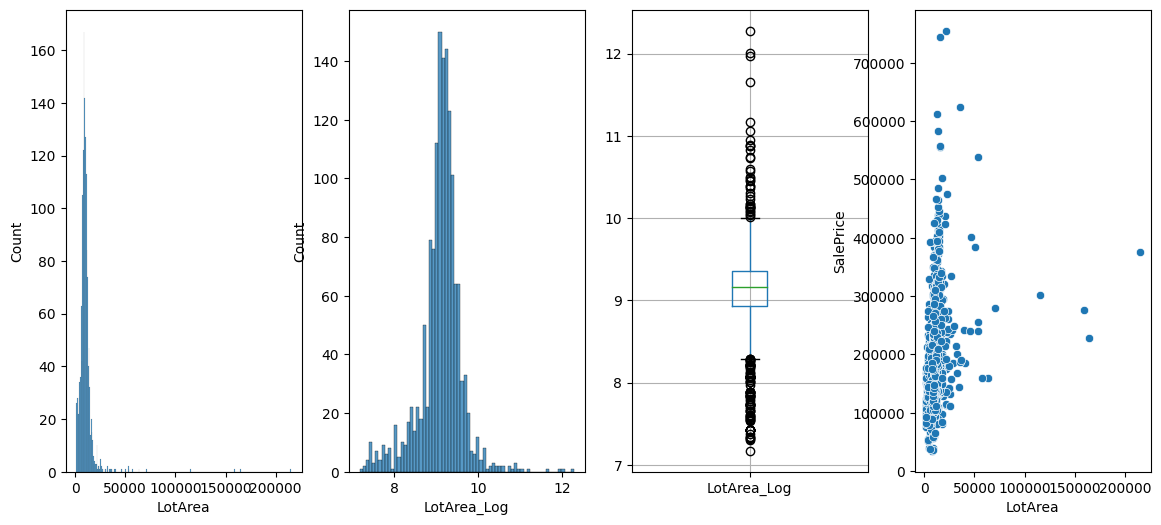

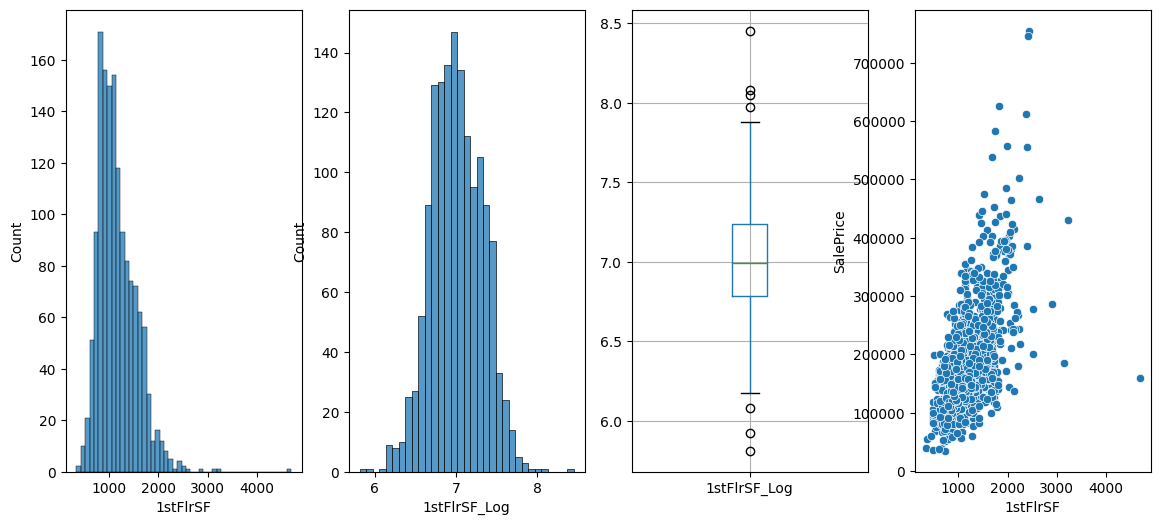

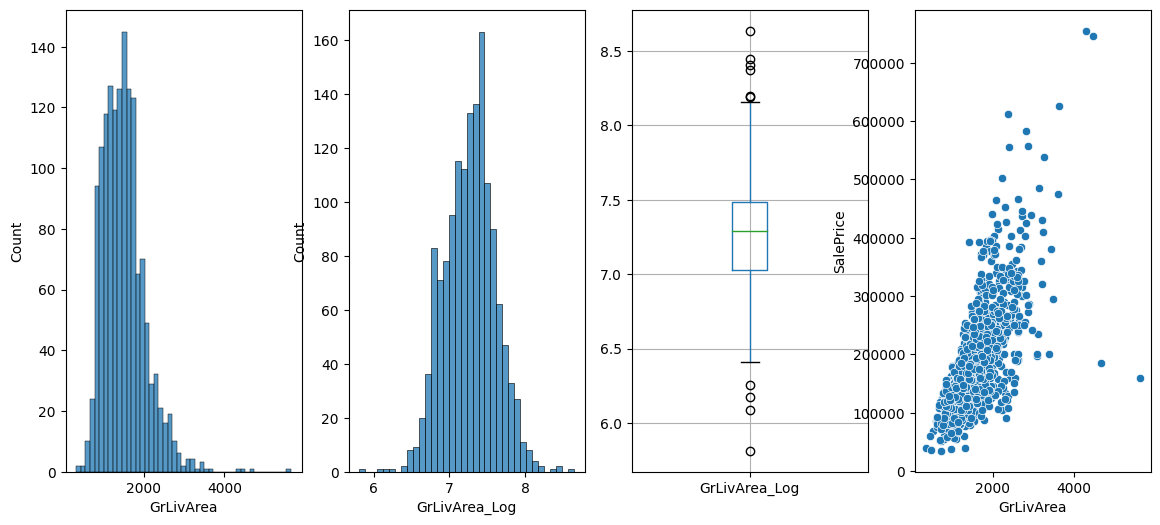

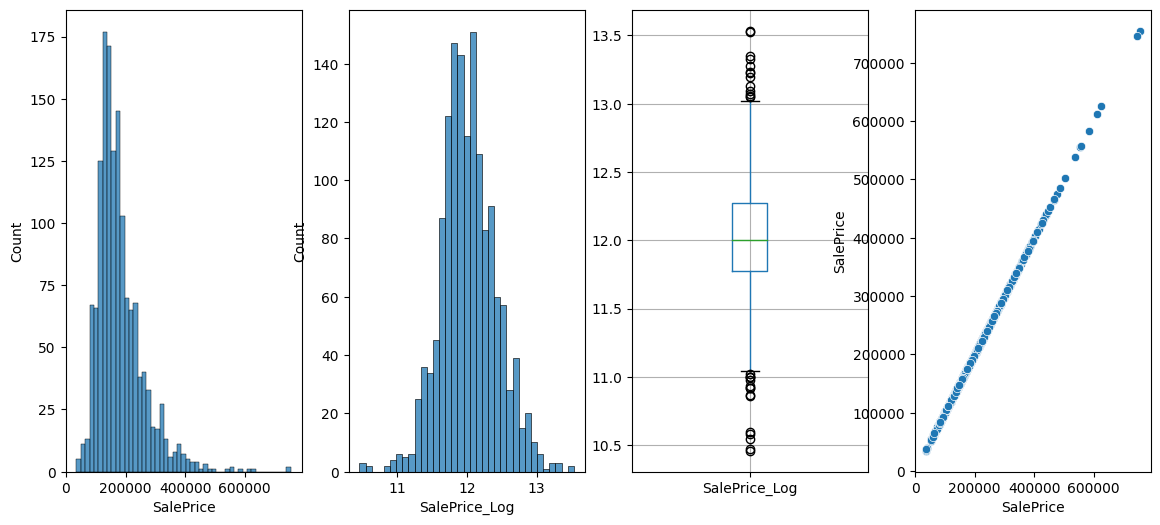

In [23]:
## We will be using logarithmic transformation
data=df_train.copy()
for feature in continuous_features:
    # filter out any features with 0 values (log(0)=undefined)
    if 0 in data[feature].unique():
        pass 
    else:
        data[feature+'_Log']=np.log1p(data[feature])
        data['SalePrice_Log']=np.log1p(data['SalePrice'])
        
        # Create subplots
        fig, axs = plt.subplots(1,4,figsize=(14,6))
        sns.histplot(data, x=feature, ax=axs[0])
        sns.histplot(data, x=feature+'_Log', ax=axs[1])
        data.boxplot(column=feature+'_Log', ax=axs[2])
        sns.scatterplot(data, x=feature, y='SalePrice', ax=axs[3])
        plt.show()

### Our continuous feature histograms and following log-transformed scatterplots showed significant skewness and indicates likely presence of significant outliers, with 2 significant ones present on bottom right side. Will need to log-transform features. 

---
# Categorical Features

### Categorical features can be broken down into 2 categories:
1. Ordinal (ordered)
2. Nominal

In [24]:
categorical_features=[feature for feature in df_train.columns if df_train[feature].dtypes=='O']
print(f"Number of categorical features: {len(categorical_features)}")
df_train[categorical_features]

Number of categorical features: 43


MSZoning Street Alley LotShape LandContour Utilities LotConfig LandSlope  \
0          RL   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   
1          RL   Pave   NaN      Reg         Lvl    AllPub       FR2       Gtl   
2          RL   Pave   NaN      IR1         Lvl    AllPub    Inside       Gtl   
3          RL   Pave   NaN      IR1         Lvl    AllPub    Corner       Gtl   
4          RL   Pave   NaN      IR1         Lvl    AllPub       FR2       Gtl   
...       ...    ...   ...      ...         ...       ...       ...       ...   
1455       RL   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   
1456       RL   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   
1457       RL   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   
1458       RL   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   
1459       RL   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   

     Neighborhood Condition1 Condition2 BldgType HouseStyle RoofStyle  \
0         CollgCr       Norm       Norm     1Fam     2Story     Gable   
1         Veenker      Feedr       Norm     1Fam     1Story     Gable   
2         CollgCr       Norm       Norm     1Fam     2Story     Gable   
3         Crawfor       Norm       Norm     1Fam     2Story     Gable   
4         NoRidge       Norm       Norm     1Fam     2Story     Gable   
...           ...        ...        ...      ...        ...       ...   
1455      Gilbert       Norm       Norm     1Fam     2Story     Gable   
1456       NWAmes       Norm       Norm     1Fam     1Story     Gable   
1457      Crawfor       Norm       Norm     1Fam     2Story     Gable   
1458        NAmes       Norm       Norm     1Fam     1Story       Hip   
1459      Edwards       Norm       Norm     1Fam     1Story     Gable   

     RoofMatl Exterior1st Exterior2nd MasVnrType ExterQual ExterCond  \
0     CompShg     VinylSd     VinylSd    BrkFace        Gd        TA   
1     CompShg     MetalSd     MetalSd        NaN        TA        TA   
2     CompShg     VinylSd     VinylSd    BrkFace        Gd        TA   
3     CompShg     Wd Sdng     Wd Shng        NaN        TA        TA   
4     CompShg     VinylSd     VinylSd    BrkFace        Gd        TA   
...       ...         ...         ...        ...       ...       ...   
1455  CompShg     VinylSd     VinylSd        NaN        TA        TA   
1456  CompShg     Plywood     Plywood      Stone        TA        TA   
1457  CompShg     CemntBd     CmentBd        NaN        Ex        Gd   
1458  CompShg     MetalSd     MetalSd        NaN        TA        TA   
1459  CompShg     HdBoard     HdBoard        NaN        Gd        TA   

     Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2  \
0         PConc       Gd       TA           No          GLQ          Unf   
1        CBlock       Gd       TA           Gd          ALQ          Unf   
2         PConc       Gd       TA           Mn          GLQ          Unf   
3        BrkTil       TA       Gd           No          ALQ          Unf   
4         PConc       Gd       TA           Av          GLQ          Unf   
...         ...      ...      ...          ...          ...          ...   
1455      PConc       Gd       TA           No          Unf          Unf   
1456     CBlock       Gd       TA           No          ALQ          Rec   
1457      Stone       TA       Gd           No          GLQ          Unf   
1458     CBlock       TA       TA           Mn          GLQ          Rec   
1459     CBlock       TA       TA           No          BLQ          LwQ   

     Heating HeatingQC CentralAir Electrical KitchenQual Functional  \
0       GasA        Ex          Y      SBrkr          Gd        Typ   
1       GasA        Ex          Y      SBrkr          TA        Typ   
2       GasA        Ex          Y      SBrkr          Gd        Typ   
3       GasA        Gd          Y      SBrkr          Gd        Typ   
4       GasA        Ex

In [25]:
for feature in categorical_features:
    print(f'The feature is {feature} and number of categories are {df_train[feature].nunique()}.')

The feature is MSZoning and number of categories are 5.
The feature is Street and number of categories are 2.
The feature is Alley and number of categories are 2.
The feature is LotShape and number of categories are 4.
The feature is LandContour and number of categories are 4.
The feature is Utilities and number of categories are 2.
The feature is LotConfig and number of categories are 5.
The feature is LandSlope and number of categories are 3.
The feature is Neighborhood and number of categories are 25.
The feature is Condition1 and number of categories are 9.
The feature is Condition2 and number of categories are 8.
The feature is BldgType and number of categories are 5.
The feature is HouseStyle and number of categories are 8.
The feature is RoofStyle and number of categories are 6.
The feature is RoofMatl and number of categories are 8.
The feature is Exterior1st and number of categories are 15.
The feature is Exterior2nd and number of categories are 16.
The feature is MasVnrType a

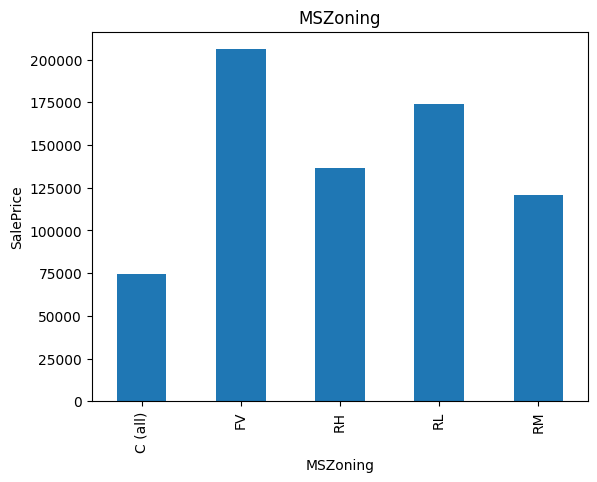

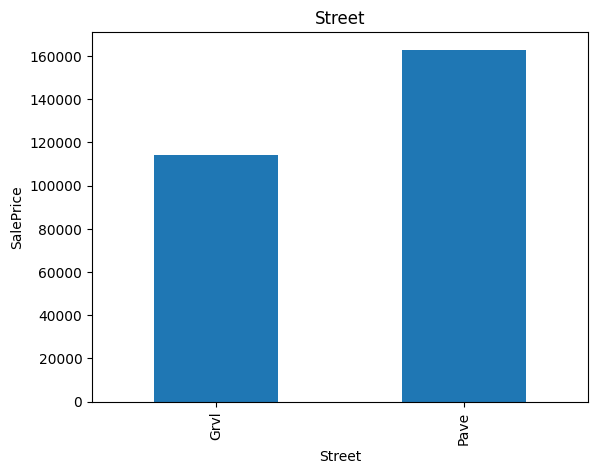

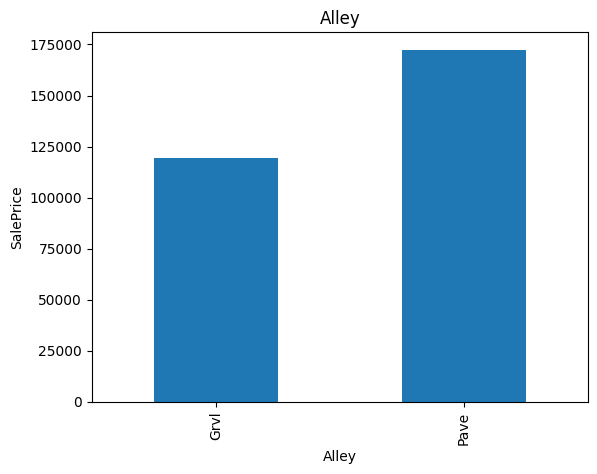

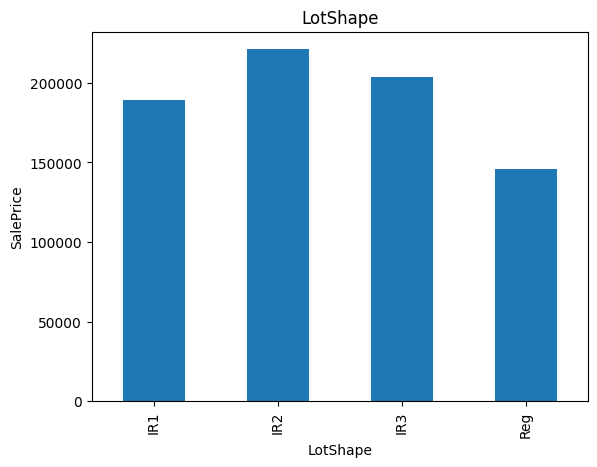

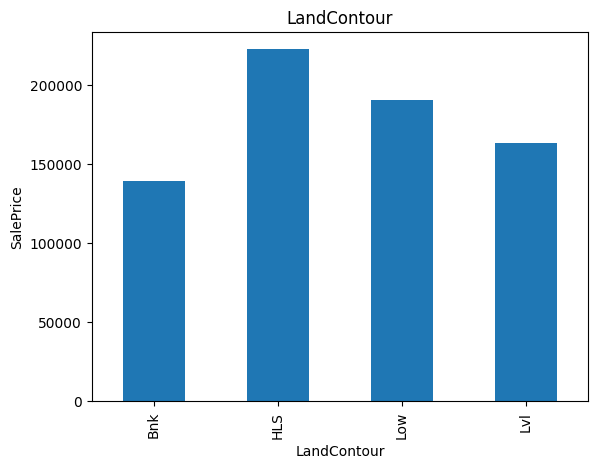

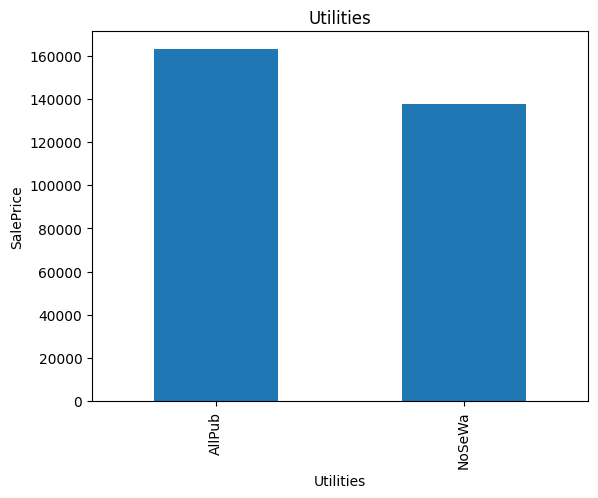

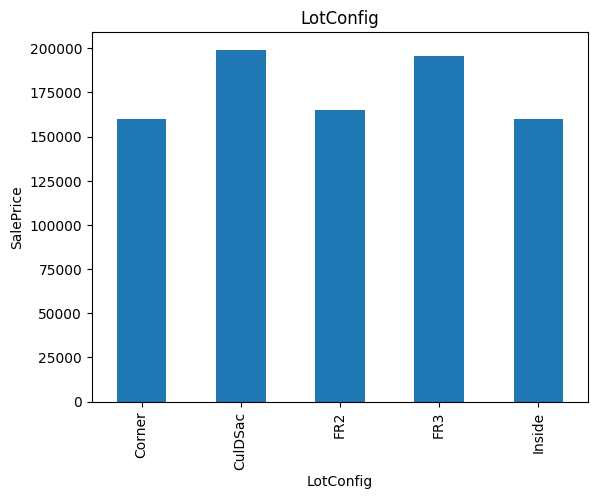

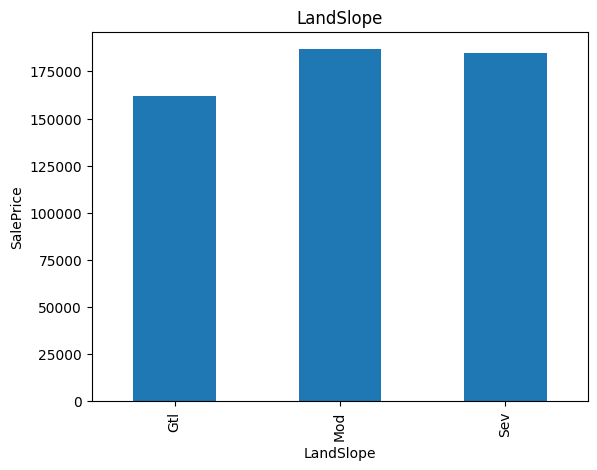

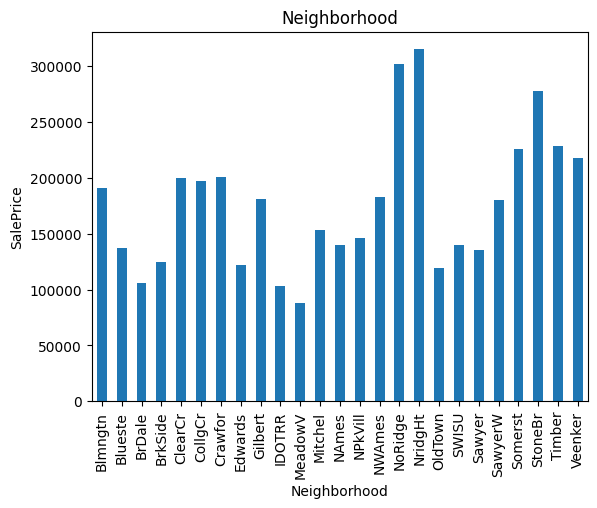

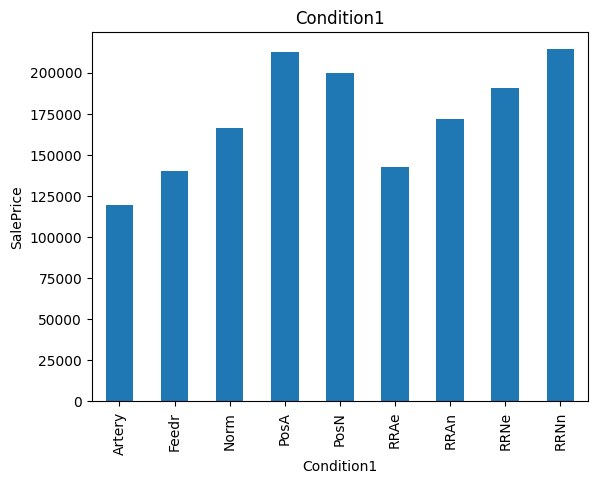

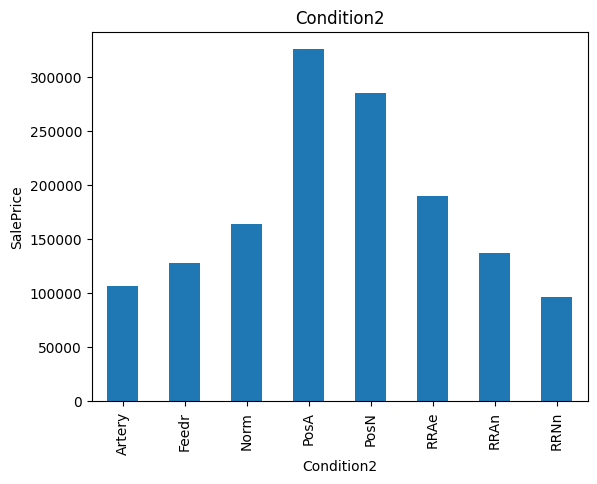

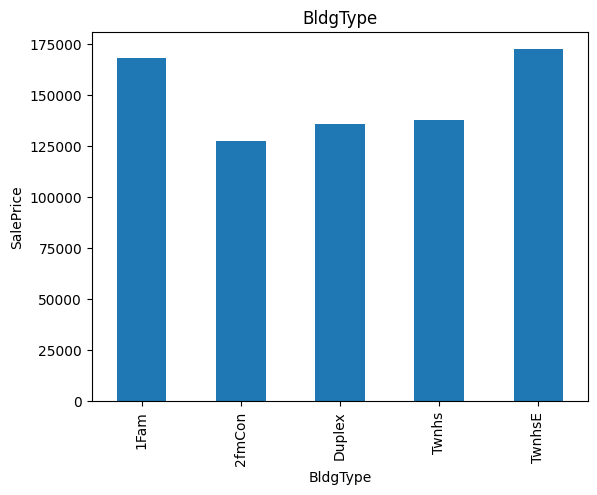

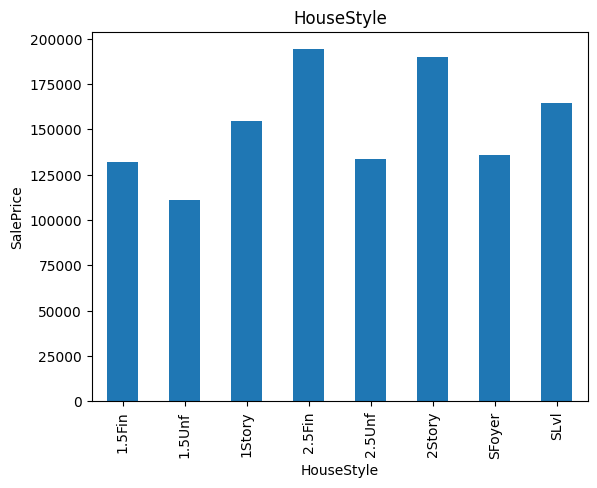

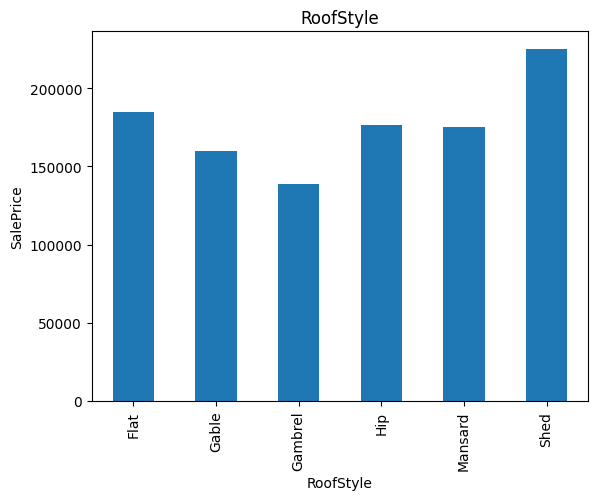

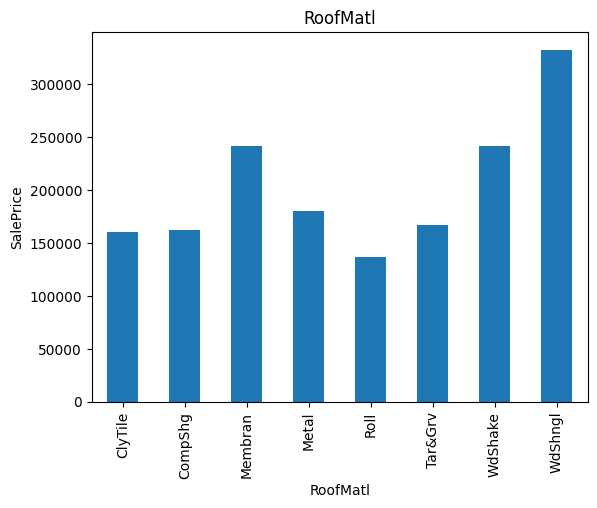

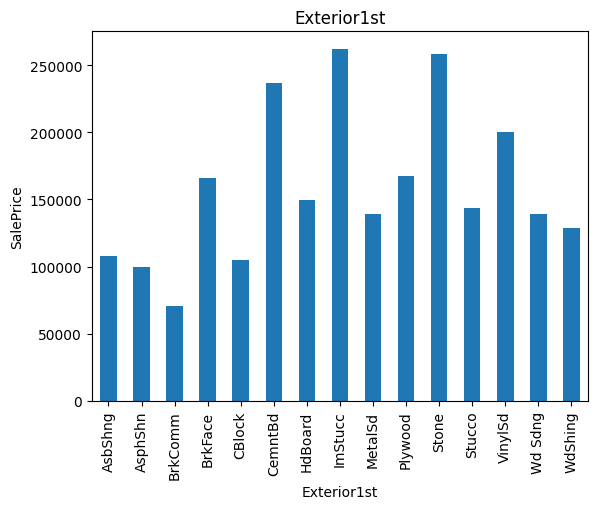

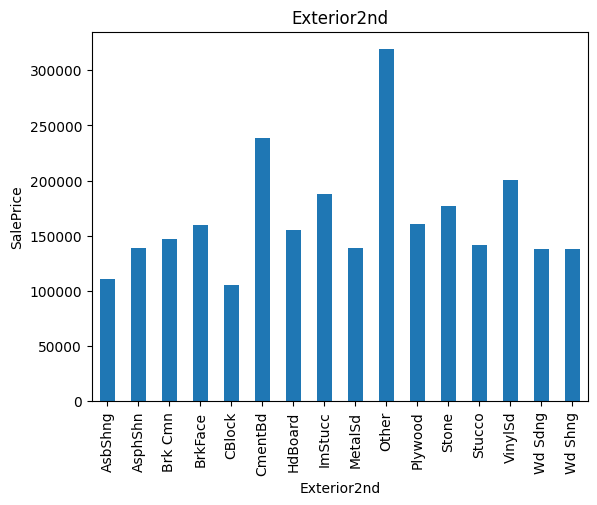

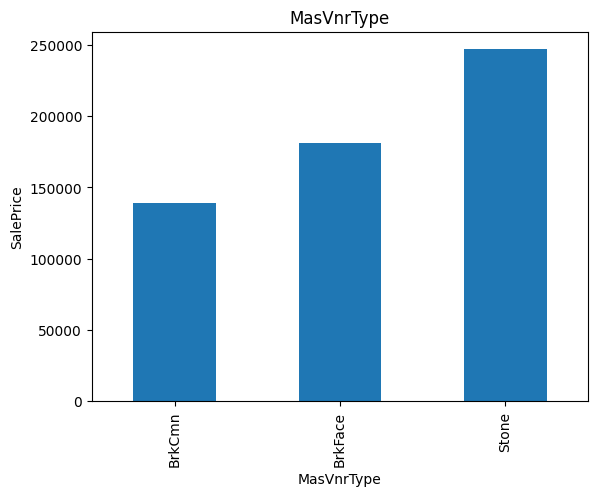

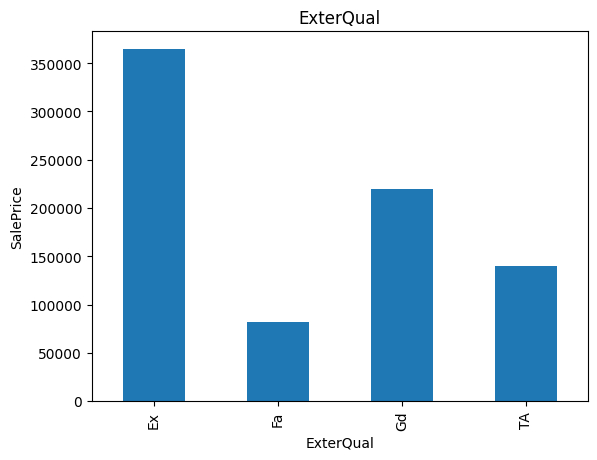

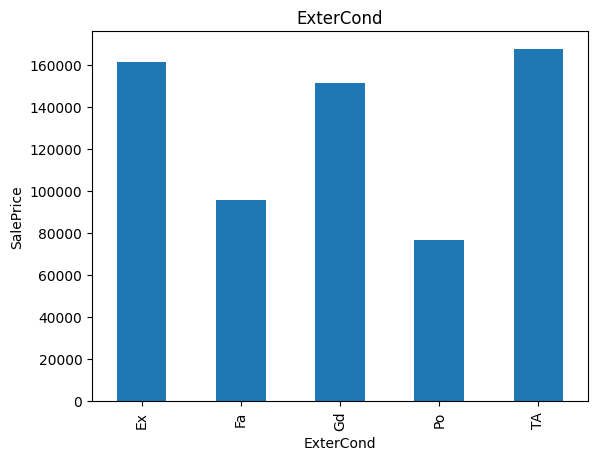

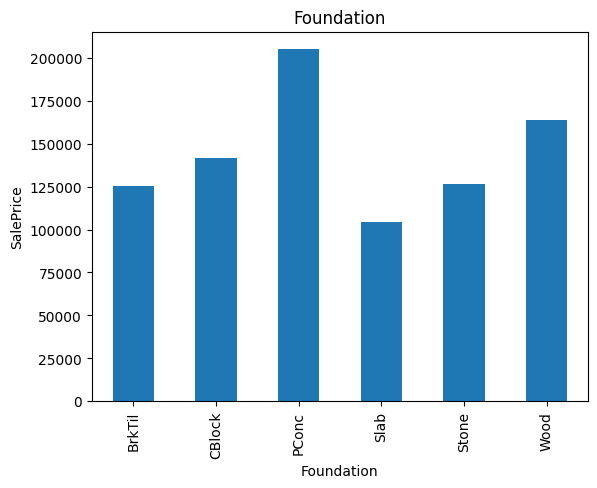

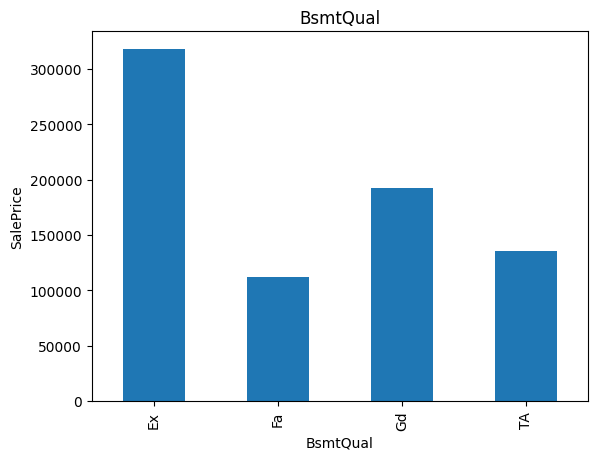

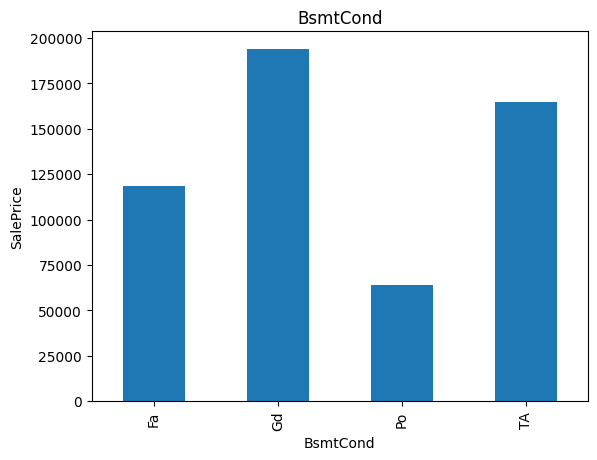

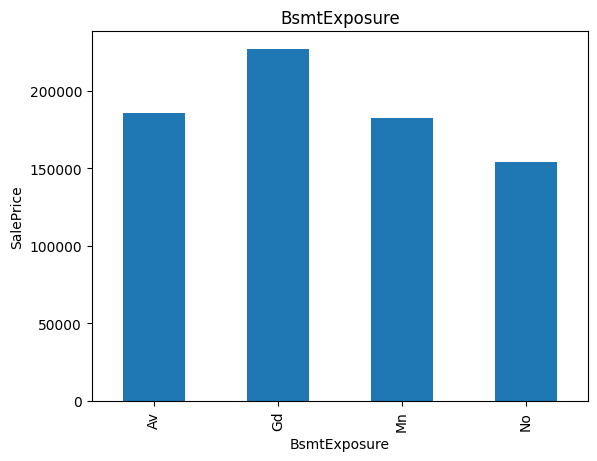

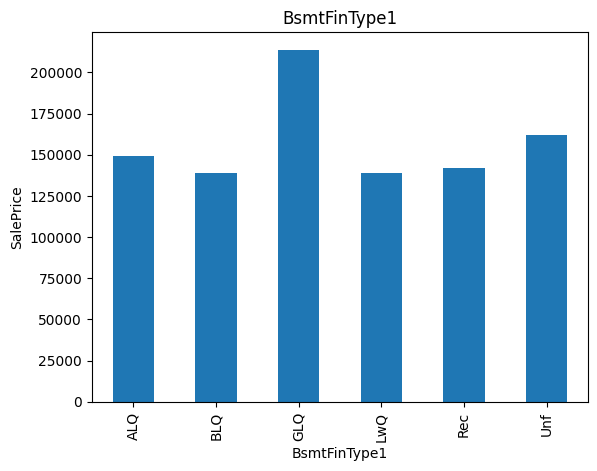

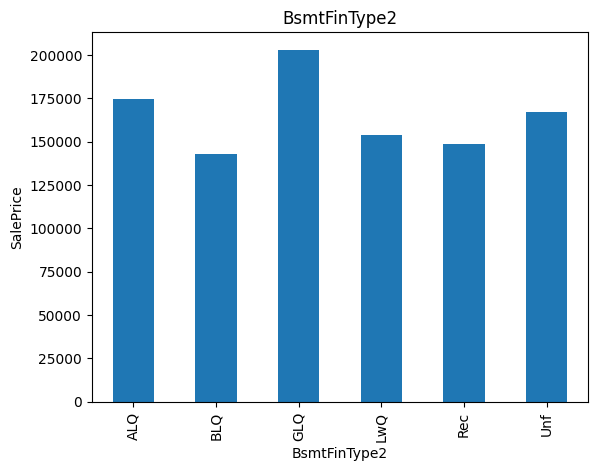

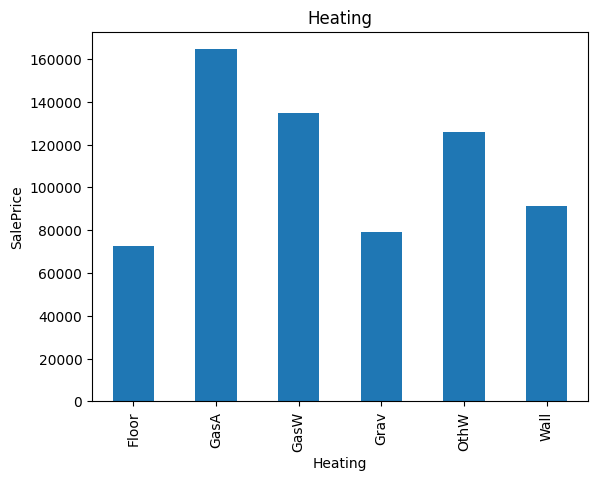

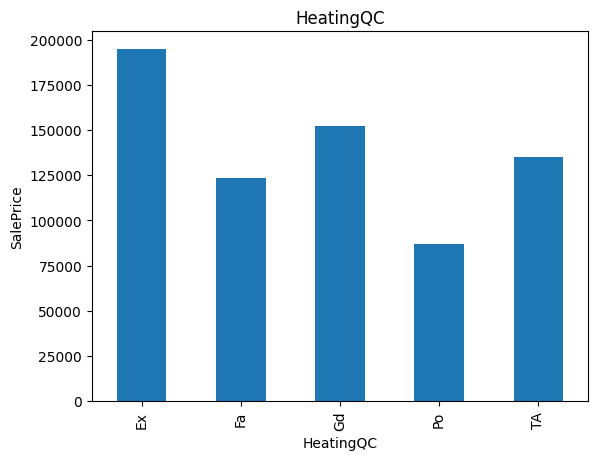

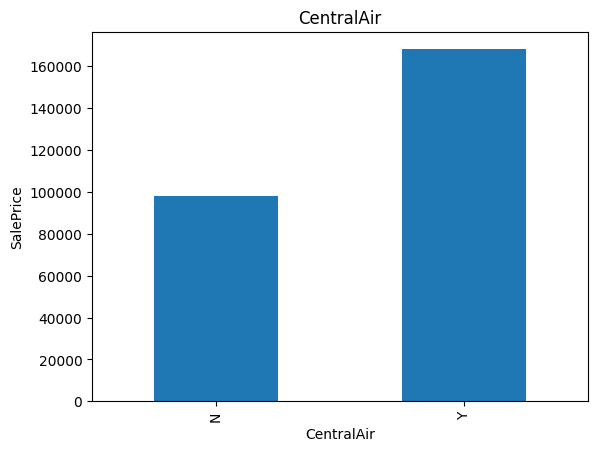

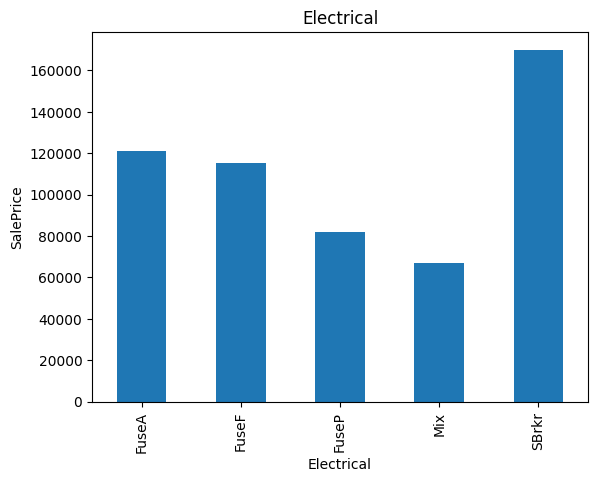

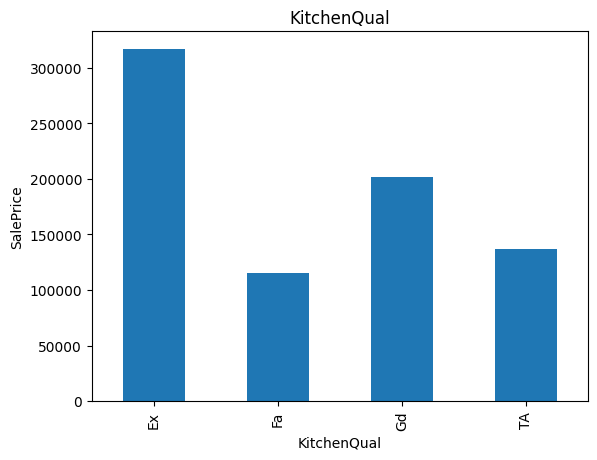

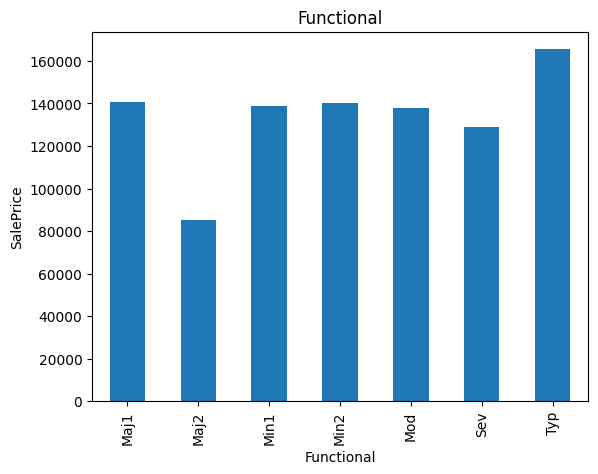

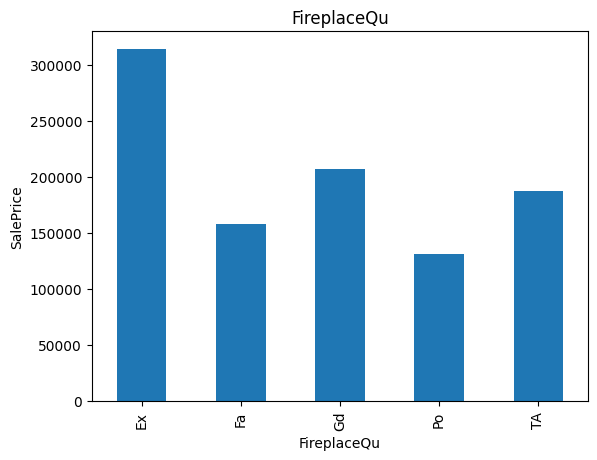

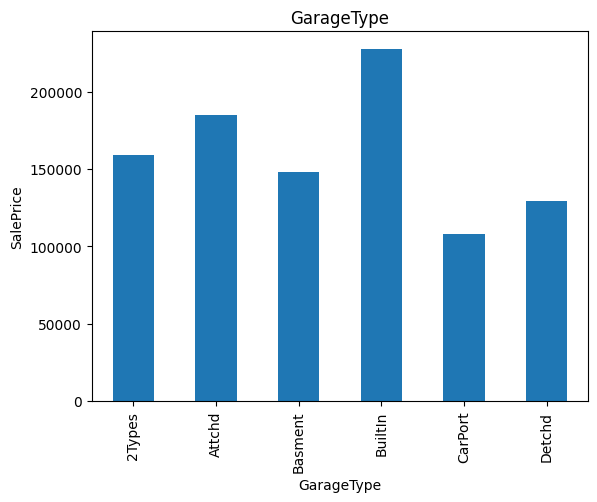

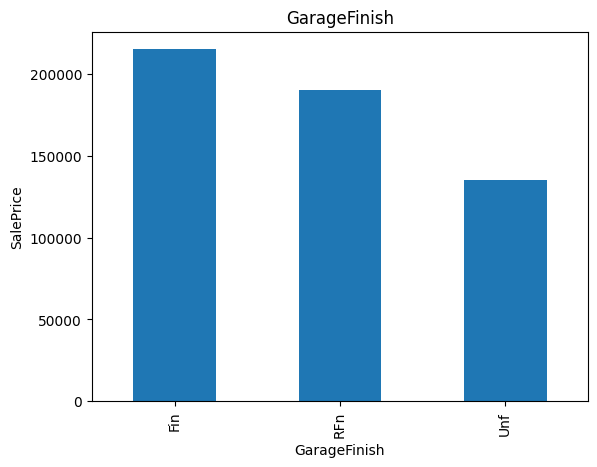

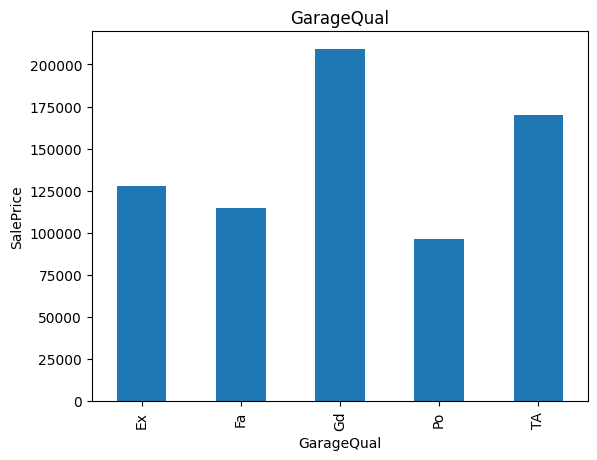

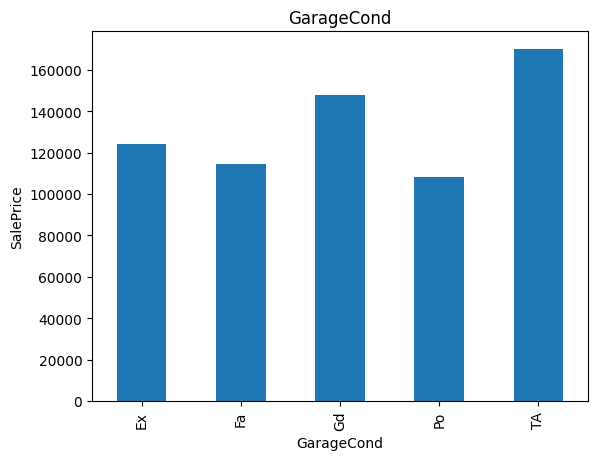

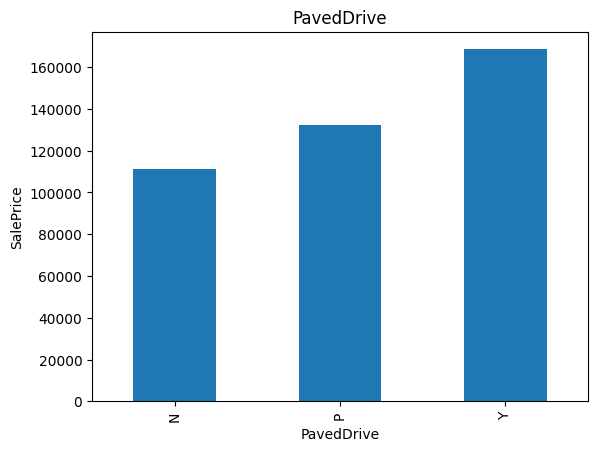

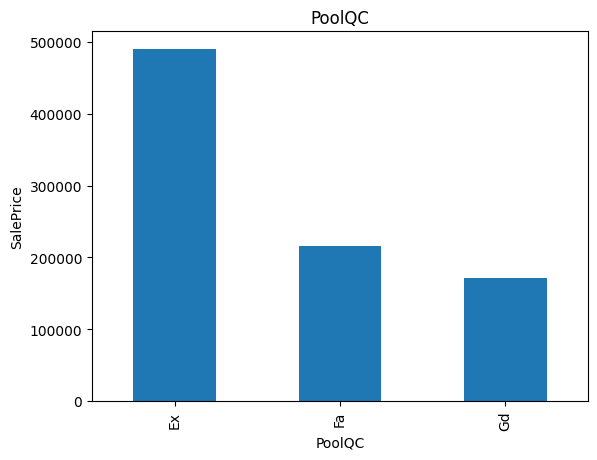

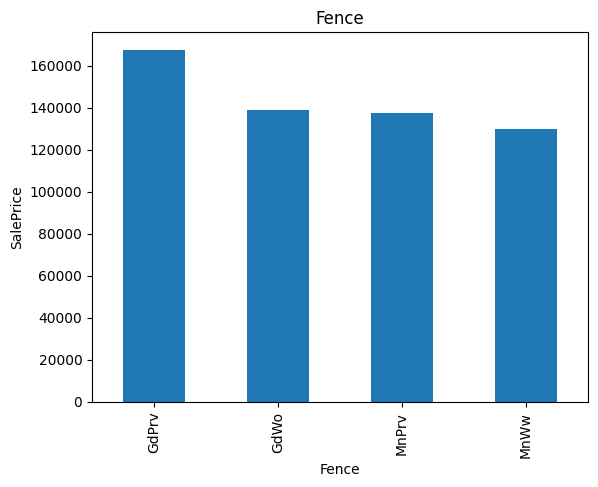

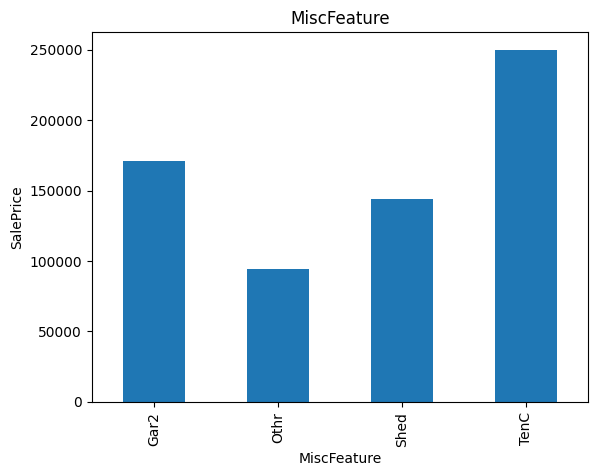

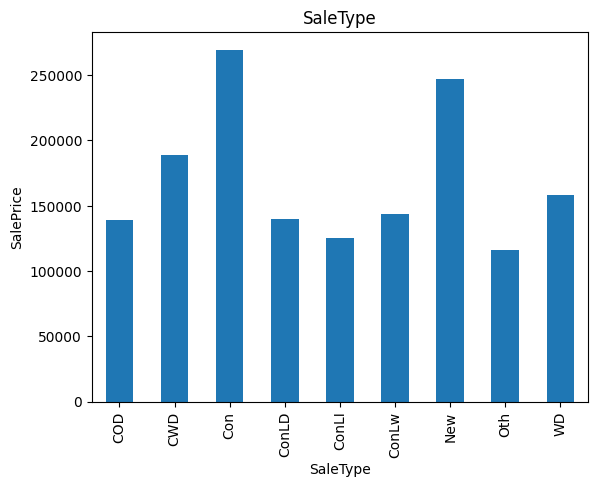

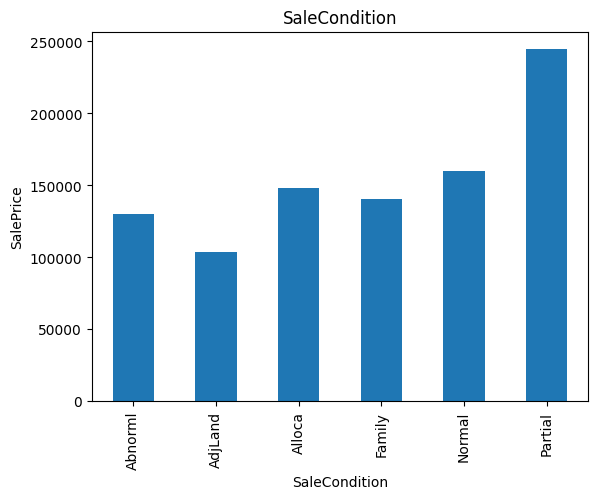

In [26]:
## Find out the relationship between categorical variable and dependent feature SalesPrice
for feature in categorical_features:
    df_train.groupby(feature)['SalePrice'].median().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
    plt.title(feature)
    plt.show()

---
# Feature Engineering
### We will be performing all the below steps in Feature Engineering

* Remove outliers
* Missing values
    * Replace misclassified NaN values 
* Categorical variables: One Hot Encoding
* Numerical variables: Log Transform
* Standarise the values of the variables to the same range

---
# Correlation Matrix

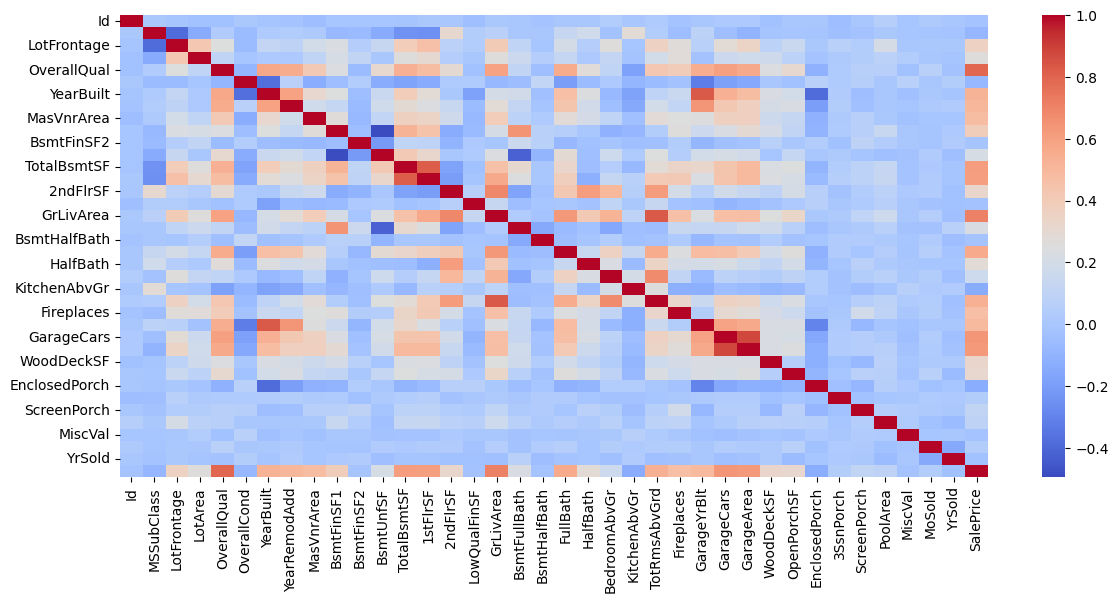

In [27]:
# Calculate the correlation matrix for numerical columns
corr_mat = df_train[num_features].corr()

# Create the heatmap
plt.figure(figsize = (14,6))
sns.heatmap(corr_mat, cmap = 'coolwarm', annot=False, fmt='.1g')
plt.show()

Observations:
* GarageCars and GarageArea appear to be similar
* 1stFlrSF and TotalBsmtSF appear to be similar
* SalePrice strongly correlated to OverallQual and GrLivArea

---
# Concatenate df_train and df_test

In [28]:
# Concatenate dataframes essentially stacking df_train and df_test
print(f"The df_train dataset has {df_train.shape[0]} rows and {df_train.shape[1]} columns.")
print(f"The df_test dataset has {df_test.shape[0]} rows and {df_test.shape[1]} columns.")
df = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)
print(f"The combined dataset df has {df.shape[0]} rows and {df.shape[1]} columns.")

The df_train dataset has 1460 rows and 81 columns.
The df_test dataset has 1459 rows and 80 columns.
The combined dataset df has 2919 rows and 81 columns.


---
# Remove Outliers
### Outlier Removal #1

df shape before outlier removal: (2919, 81)


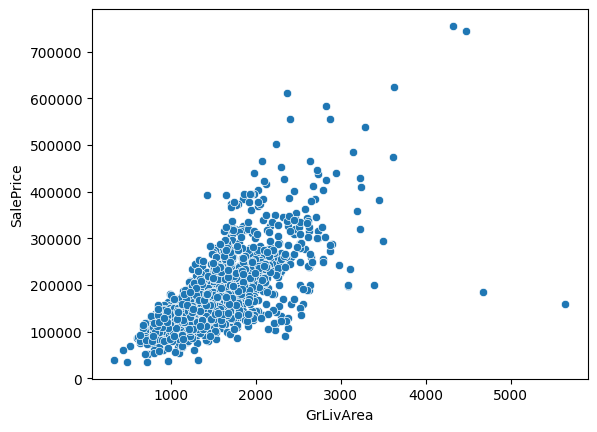

[ 523 1298]


In [29]:
# Shape before removal
print(f"df shape before outlier removal: {df.shape}")

# Plot
sns.scatterplot(df, x='GrLivArea', y='SalePrice')
plt.show()

# Locate indices of outliers
outlier_indices = np.where((df['GrLivArea']>4000) & (df['SalePrice']<300000))
print(outlier_indices[0]) # row index of outliers

df shape after outlier removal: (2917, 81)


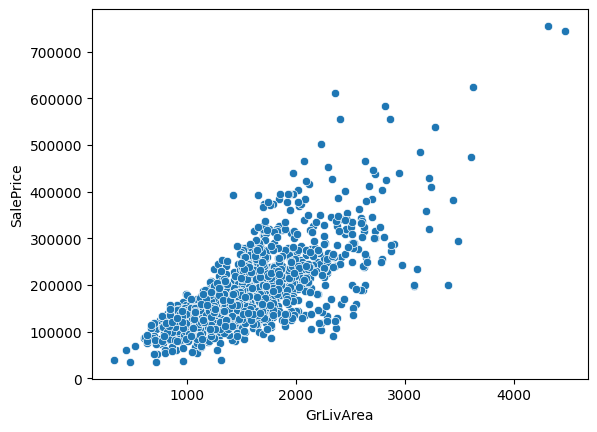

In [30]:
# Drop from df dataframe
df = df.drop(outlier_indices[0])

# Confirm removal
print(f"df shape after outlier removal: {df.shape}")

# Plot
sns.scatterplot(df, x='GrLivArea', y='SalePrice')
plt.show()

# Outlier Correction #2
I noticed a peculiar lone outlier in 'GarageYrBlt' with a year of 2207. It was likely intended to be 2007 and will be replaced as such. 

In [31]:
# Shape before removal
print(f"df max year before outlier replacement: \n{df['GarageYrBlt'].max()}")

# Replace values greater than 2100
df['GarageYrBlt'] = np.where(df['GarageYrBlt']>2100, 2007, df['GarageYrBlt'])

# Confirm removal
print(f"df max year after outlier replacement: \n{df['GarageYrBlt'].max()}")

df max year before outlier replacement: 
2207.0
df max year after outlier replacement: 
2010.0


---
# Missing Values

In [32]:
# Create dataframe of missing values
# Calculate the missing count and percentage for each feature
missing_count = df.isna().sum()
missing_percentage = (df.isna().mean() * 100).round(4)

# Create a DataFrame with the missing count and percentage
missing_df = pd.DataFrame({
    'Count': missing_count,
    'Percentage': missing_percentage
})

# Filter out features with no missing values and sort by percentage in descending order
missing_df = missing_df[(missing_df['Count'] > 0)].sort_values(by='Percentage', ascending=False)

# Display the resulting DataFrame
missing_df

Count  Percentage
PoolQC         2908     99.6915
MiscFeature    2812     96.4004
Alley          2719     93.2122
Fence          2346     80.4251
MasVnrType     1766     60.5417
SalePrice      1459     50.0171
FireplaceQu    1420     48.6802
LotFrontage     486     16.6610
GarageCond      159      5.4508
GarageYrBlt     159      5.4508
GarageFinish    159      5.4508
GarageQual      159      5.4508
GarageType      157      5.3822
BsmtExposure     82      2.8111
BsmtCond         82      2.8111
BsmtQual         81      2.7768
BsmtFinType2     80      2.7425
BsmtFinType1     79      2.7083
MasVnrArea       23      0.7885
MSZoning          4      0.1371
Functional        2      0.0686
BsmtHalfBath      2      0.0686
BsmtFullBath      2      0.0686
Utilities         2      0.0686
KitchenQual       1      0.0343
TotalBsmtSF       1      0.0343
BsmtUnfSF         1      0.0343
GarageCars        1      0.0343
GarageArea        1      0.0343
BsmtFinSF2        1      0.0343
BsmtFinSF1        1      0.0343
Exterior2nd       1      0.0343
Exterior1st       1      0.0343
SaleType          1      0.0343
Electrical        1      0.0343

In [33]:
# Boolean mask for identifying rows with NaN values
missing_data_row = df.isna().any(axis=1)
df[missing_data_row]

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
2914  2915         160       RM         21.0     1936   Pave   NaN      Reg   
2915  2916         160       RM         21.0     1894   Pave   NaN      Reg   
2916  2917          20       RL        160.0    20000   Pave   NaN      Reg   
2917  2918          85       RL         62.0    10441   Pave   NaN      Reg   
2918  2919          60       RL         74.0     9627   Pave   NaN      Reg   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0            Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1            Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2            Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3            Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4            Lvl    AllPub       FR2       Gtl      NoRidge       Norm   
...          ...       ...       ...       ...          ...        ...   
2914         Lvl    AllPub    Inside       Gtl      MeadowV       Norm   
2915         Lvl    AllPub    Inside       Gtl      MeadowV       Norm   
2916         Lvl    AllPub    Inside       Gtl      Mitchel       Norm   
2917         Lvl    AllPub    Inside       Gtl      Mitchel       Norm   
2918         Lvl    AllPub    Inside       Mod      Mitchel       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0          Norm     1Fam     2Story            7            5       2003   
1          Norm     1Fam     1Story            6            8       1976   
2          Norm     1Fam     2Story            7            5       2001   
3          Norm     1Fam     2Story            7            5       1915   
4          Norm     1Fam     2Story            8            5       2000   
...         ...      ...        ...          ...          ...        ...   
2914       Norm    Twnhs     2Story            4            7       1970   
2915       Norm   TwnhsE     2Story            4            5       1970   
2916       Norm     1Fam     1Story            5            7       1960   
2917       Norm     1Fam     SFoyer            5            5       1992   
2918       Norm     1Fam     2Story            7            5       1993   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0             2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1             1976     Gable  CompShg     MetalSd     MetalSd        NaN   
2             2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3             1970     Gable  CompShg     Wd Sdng     Wd Shng        NaN   
4             2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   
...            ...       ...      ...         ...         ...        ...   
2914          1970     Gable  CompShg     CemntBd     CmentBd        NaN   
2915          1970     Gable  CompShg     CemntBd     CmentBd        NaN   
2916          1996     Gable  CompShg     VinylSd     VinylSd        NaN   
2917          1992     Gable  CompShg     HdBoard     Wd Shng        NaN   
2918          1994     Gable  CompShg     HdBoard     HdBoard    BrkFace   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
0          196.0        Gd        TA      PConc       Gd       TA   
1            0.0        TA        TA     CBlock       Gd       TA   
2          162.0        Gd        TA      PConc       Gd       TA   
3            0.0        TA        TA     BrkTil       TA       Gd   

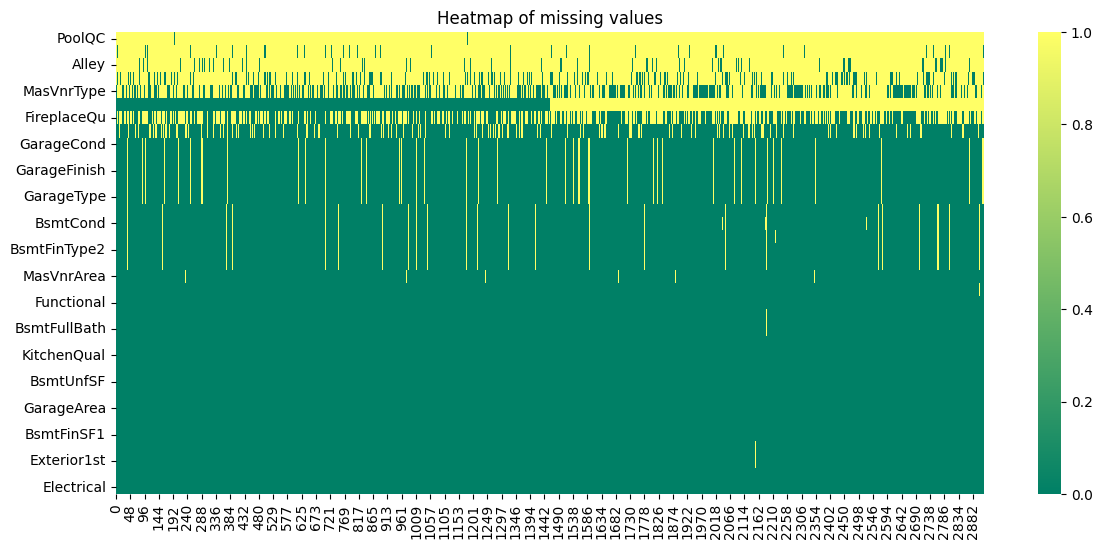

In [34]:
# Heatmap of missing values
plt.figure(figsize=(14,6))
sns.heatmap(df[missing_df.index].isna().T, cmap='summer')
plt.title('Heatmap of missing values')
plt.show()

### Missing values appear to be related: 
* GarageQual, GarageCond, GarageYrBlt, GarageFinish, GarageType
* BsmtCond, BsmtFinType2

### There is quite a few missing values! However, the data description text file indicates the following features are not actually missing values. Rather, they were misclassified as missing values when in fact they represent the absence of the feature. For example:
* 'GarageYrBlt' is not actually missing values, but represents absence of garage at house.
* MasVnrArea is Masonry Veneer Area, but missing value represent houses without this feature. They are safe to fill with 0.
* LotFrontage will be replaced with median value due to outliers.

---

In [35]:
misclassified_features = [
'Alley',
'BsmtQual',
'BsmtCond',
'BsmtExposure',
'BsmtFinType1',
'BsmtFinType2',
'FireplaceQu',
'GarageType',
'GarageFinish',
'GarageQual',
'GarageCond',
'PoolQC',
'Fence',
'MiscFeature',
'MasVnrType',
]

# Fill NaN values with 'None'
for col in misclassified_features:
    df[col] = df[col].fillna('None')

# Fill Functional with 'Typ' (assume typical)
df['Functional'] = df['Functional'].fillna('Typ')

# Fill missing values with 0 (likely absent feature)
for col in ('GarageYrBlt','GarageArea','GarageCars'):
    df[col] = df[col].fillna(0)
    
# Fill NaN values with 'None' (likely absent feature)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    df[col] = df[col].fillna(0)

# Fill NaN value with 0 (absent feature)
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)

# Fill MSZoning with df_train mode
MSZoning_mode = df_train['MSZoning'].mode()[0]
df['MSZoning'] = df['MSZoning'].fillna(MSZoning_mode)

# Fill 'Electrical' with df_train mode
electrical_mode = df_train['Electrical'].mode()[0]
df['Electrical'] = df['Electrical'].fillna(electrical_mode)

# Fill 'Utilities' with df_train mode
utilities_mode = df_train['Utilities'].mode()[0]
df['Utilities'] = df['Utilities'].fillna(utilities_mode)

# Fill 'KitchenQual' with df_train mode
kitchenqual_mode = df_train['KitchenQual'].mode()[0]
df['KitchenQual'] = df['KitchenQual'].fillna(kitchenqual_mode)

# Fill Exterior1st with mode
exterior1st_mode = df_train['Exterior1st'].mode()[0]
df['Exterior1st'] = df['Exterior1st'].fillna(exterior1st_mode)

# Fill Exterior2nd with mode
exterior2nd_mode = df_train['Exterior2nd'].mode()[0]
df['Exterior2nd'] = df['Exterior2nd'].fillna(exterior2nd_mode)

# Fill SaleType with mode
saletype_mode = df_train['SaleType'].mode()[0]
df['SaleType'] = df['SaleType'].fillna(saletype_mode)

# Fill LotFrontage with df_train median (to prevent data leakage)
lf_median = df_train['LotFrontage'].median()
df['LotFrontage']=df['LotFrontage'].fillna(lf_median)

### Confirm all missing values have been filled

In [36]:
df.isna().sum().sum() - df['SalePrice'].isna().sum()

0

---
# Investigate skewness

In [37]:
data=df.copy()

# List of features to transform
log_transform_features = [features for features in data.columns if data[features].dtype != 'O' and features not in ['Id', 'SalePrice']]

# Initialize a list to store skewness and kurtosis before and after transformation
skew_kurt_stats = []

# Loop through features and apply log1p transformation
for feature in log_transform_features:
    before_skew = data[feature].skew()
#     before_kurt = data[feature].kurt()
    data[feature+'_log'] = np.log1p(data[feature])
    after_skew = data[feature+'_log'].skew()
#     after_kurt = data[feature+'_log'].kurt()
#     skew_diff = after_skew - before_skew

    # Append results to the list
    skew_kurt_stats.append({
        'Feature': feature,
#         'Skew_Diff': before_skew - after_skew,
        'Before_Skew': before_skew,
        'After_Skew': after_skew,
#         'Before_Kurt': before_kurt,
#         'After_Kurt': after_kurt
    })

# Convert the list to a DataFrame for better readability
df_skew = pd.DataFrame(skew_kurt_stats).sort_values(by='Before_Skew', ascending=False)
filt_df_skew = df_skew[(df_skew['After_Skew']<1)&(df_skew['After_Skew']>-1)]
filt_df_skew

Feature  Before_Skew  After_Skew
2        LotArea    13.116240   -0.532920
7     MasVnrArea     2.623068    0.538731
28   OpenPorchSF     2.530660   -0.041559
27    WoodDeckSF     1.845741    0.159605
0     MSSubClass     1.375838    0.246056
12      1stFlrSF     1.257933    0.030374
15     GrLivArea     1.069300   -0.022062
8     BsmtFinSF1     0.981149   -0.616808
13      2ndFlrSF     0.861999    0.306786
22  TotRmsAbvGrd     0.749618    0.028378
23    Fireplaces     0.725651    0.236180
19      HalfBath     0.697024    0.582963
16  BsmtFullBath     0.622735    0.425573
4    OverallCond     0.569607   -0.747296
20  BedroomAbvGr     0.326736   -0.982822
34        MoSold     0.197447   -0.873808
3    OverallQual     0.189688   -0.653775
18      FullBath     0.165599   -0.249772
35        YrSold     0.132064    0.131252
6   YearRemodAdd    -0.450365   -0.457506
5      YearBuilt    -0.599503   -0.625935

These features are good candidates for log transformation. I will confirm via plot they are appropriate prior to log transforming dataset.

---
# Numerical Variables
### Since the numerical variables are skewed we will perform log normal distribution

LotArea Before Log: 13.1162 After Log: -0.5329


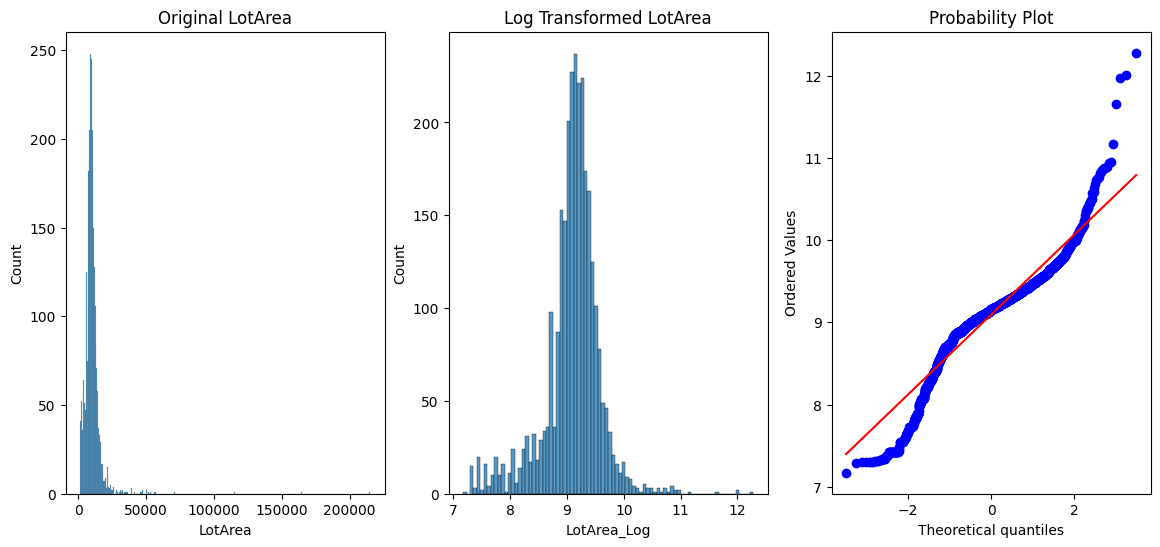

MasVnrArea Before Log: 2.6231 After Log: 0.5387


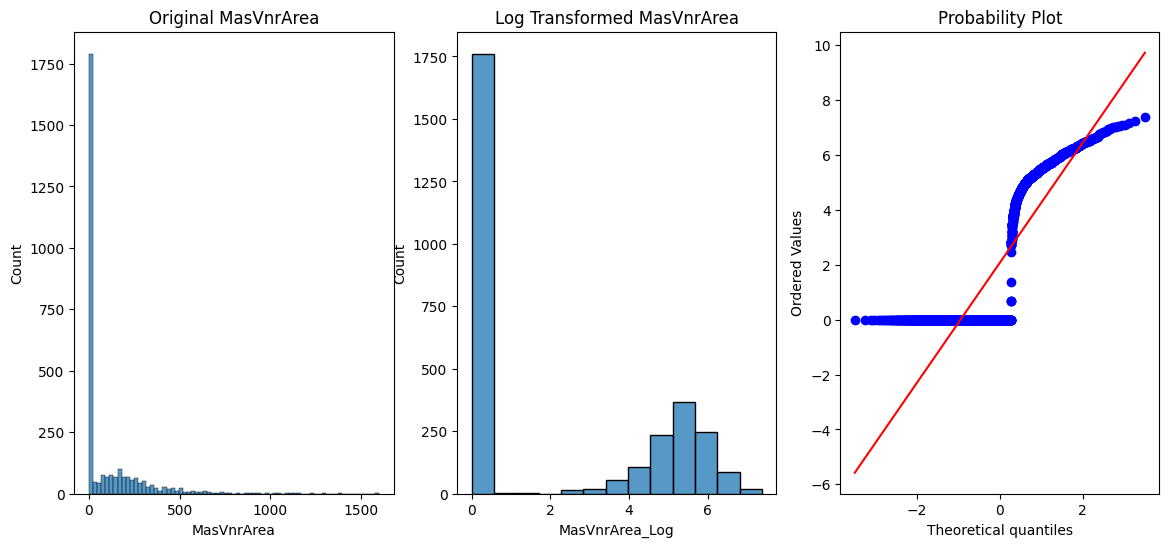

OpenPorchSF Before Log: 2.5307 After Log: -0.0416


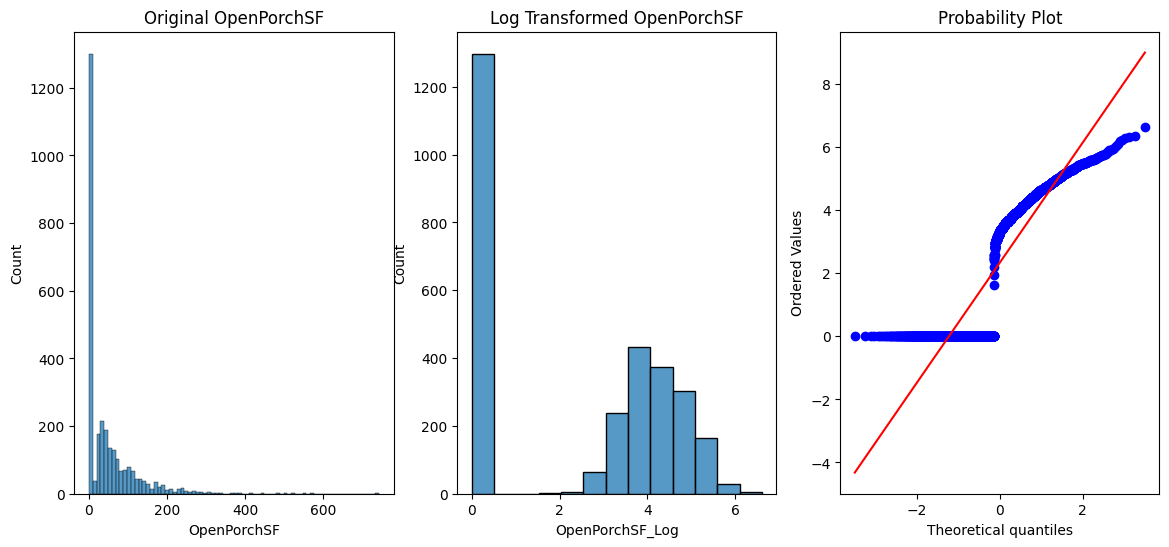

WoodDeckSF Before Log: 1.8457 After Log: 0.1596


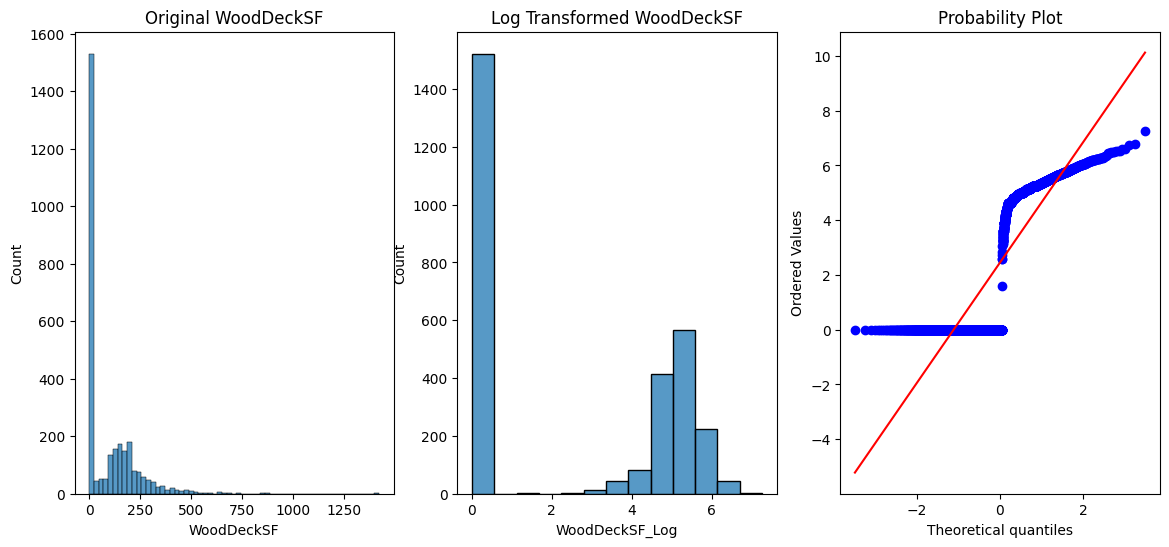

MSSubClass Before Log: 1.3758 After Log: 0.2461


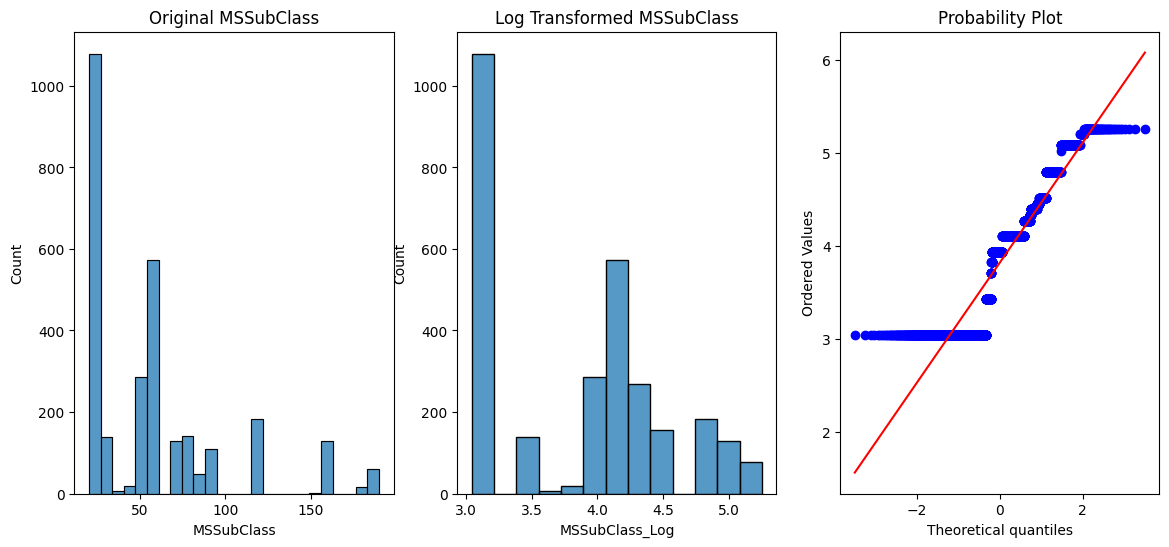

1stFlrSF Before Log: 1.2579 After Log: 0.0304


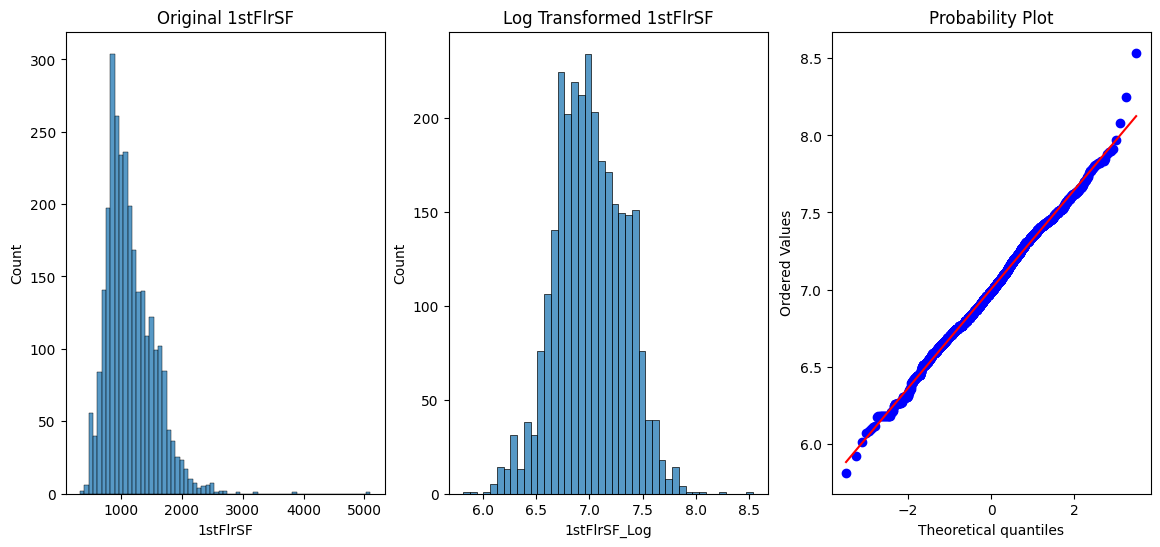

GrLivArea Before Log: 1.0693 After Log: -0.0221


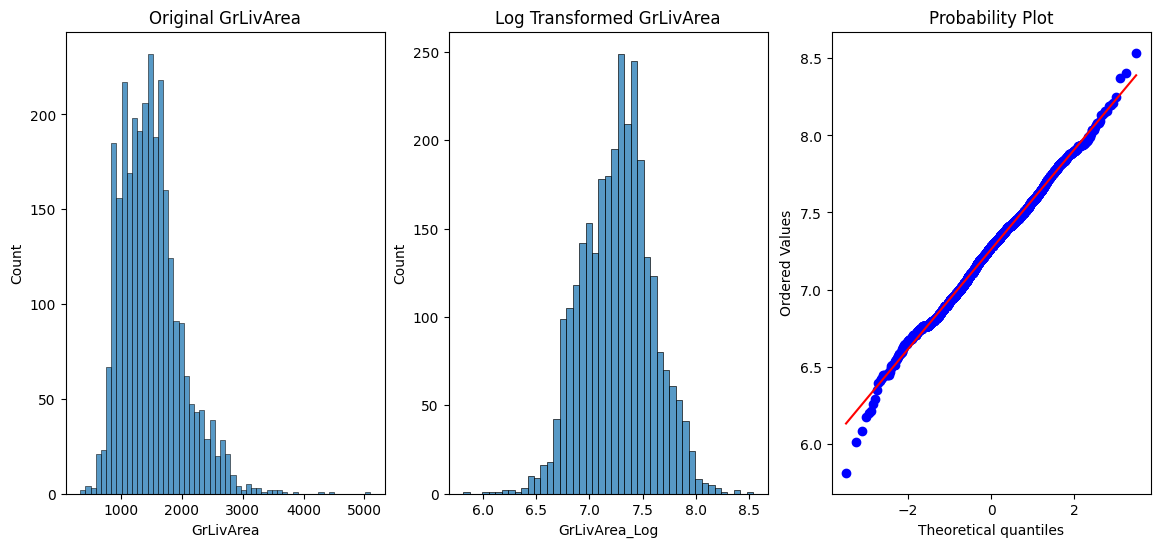

BsmtFinSF1 Before Log: 0.9811 After Log: -0.6168


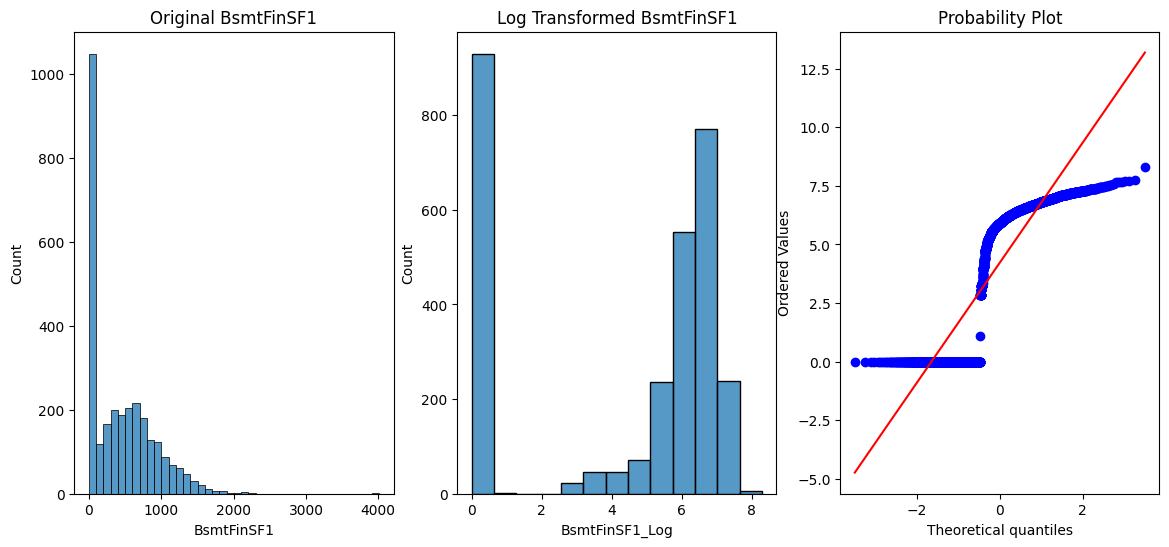

2ndFlrSF Before Log: 0.862 After Log: 0.3068


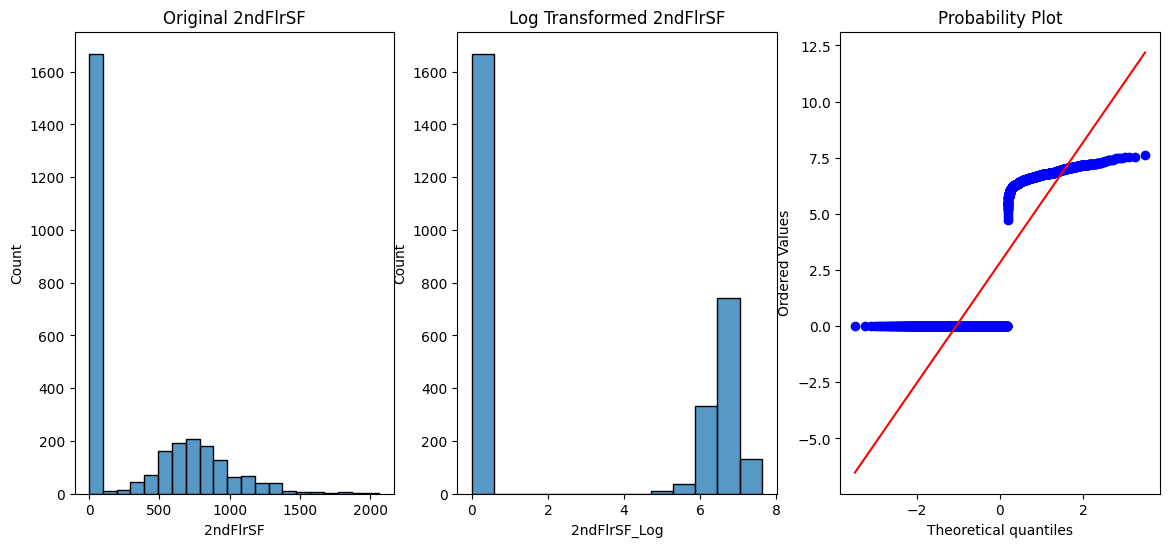

TotRmsAbvGrd Before Log: 0.7496 After Log: 0.0284


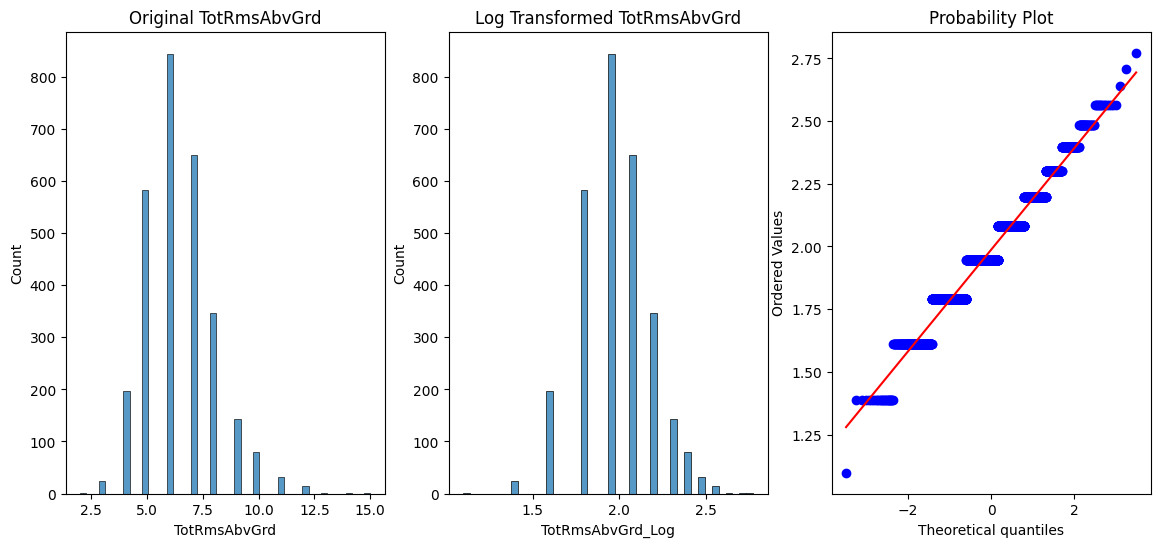

Fireplaces Before Log: 0.7257 After Log: 0.2362


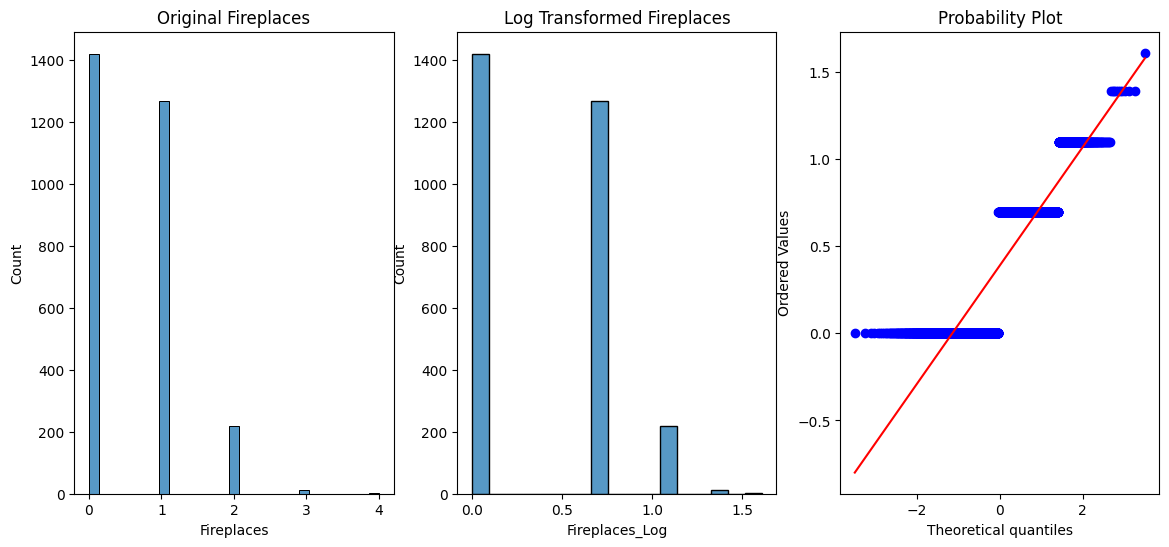

HalfBath Before Log: 0.697 After Log: 0.583


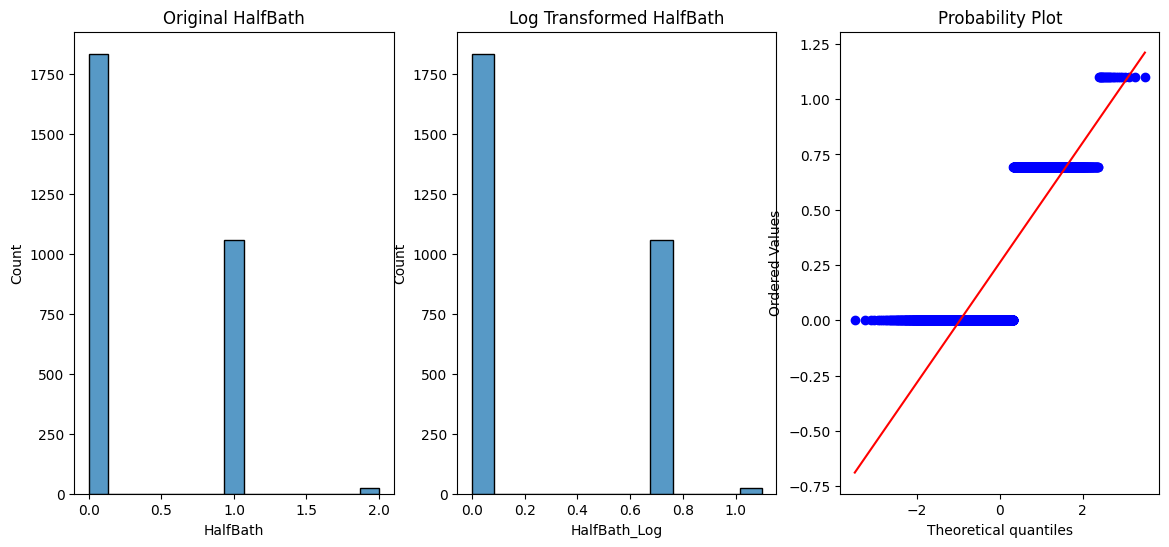

BsmtFullBath Before Log: 0.6227 After Log: 0.4256


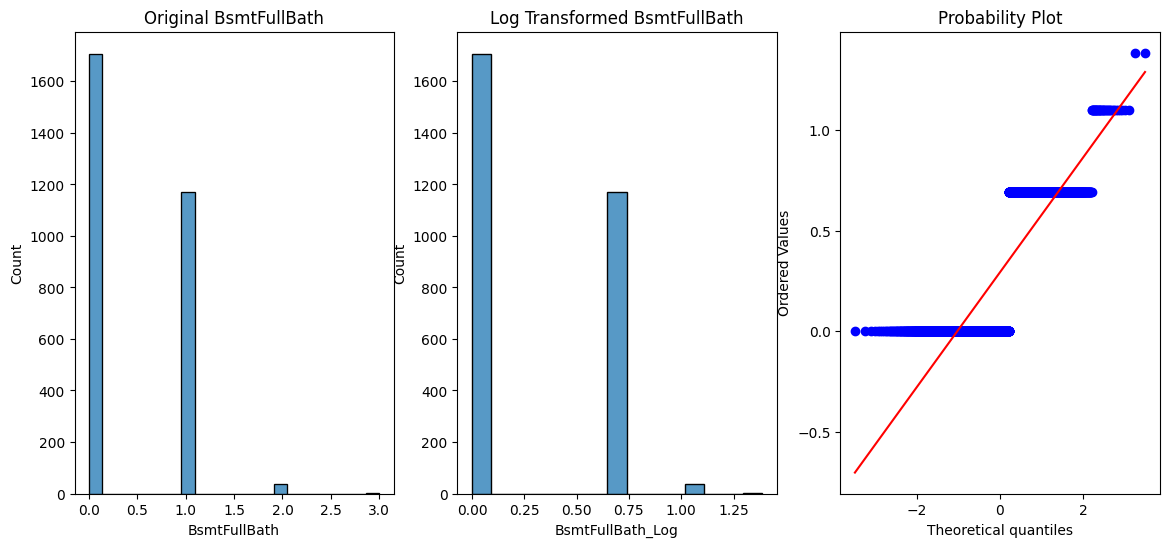

OverallCond Before Log: 0.5696 After Log: -0.7473


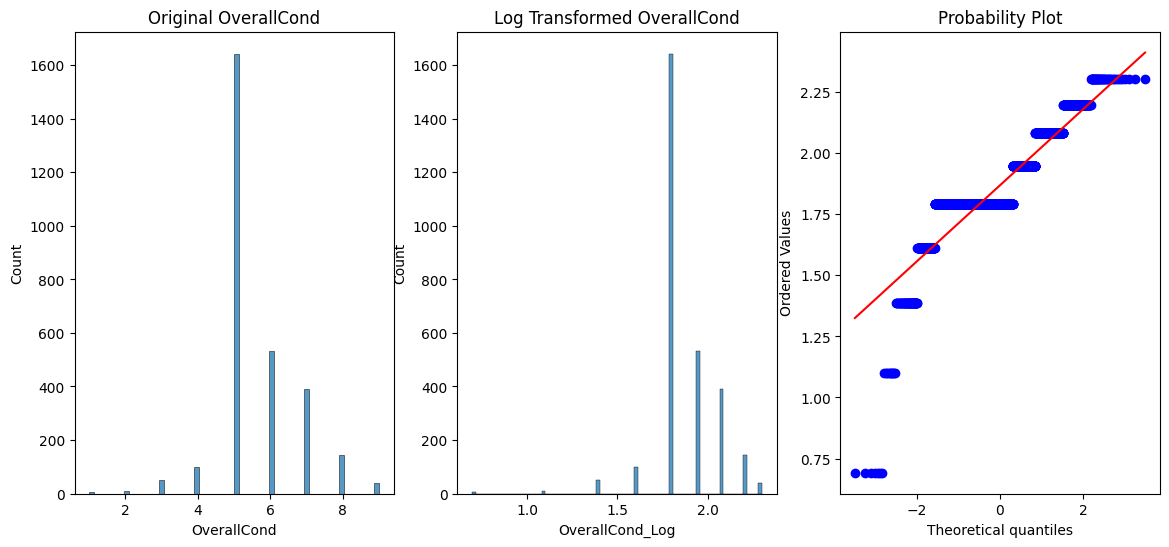

BedroomAbvGr Before Log: 0.3267 After Log: -0.9828


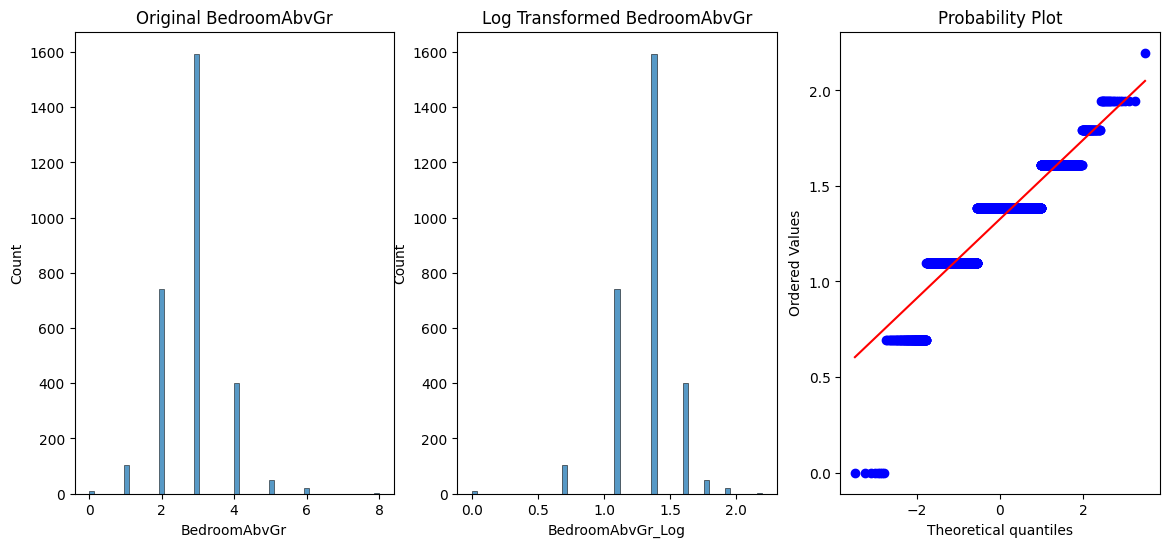

MoSold Before Log: 0.1974 After Log: -0.8738


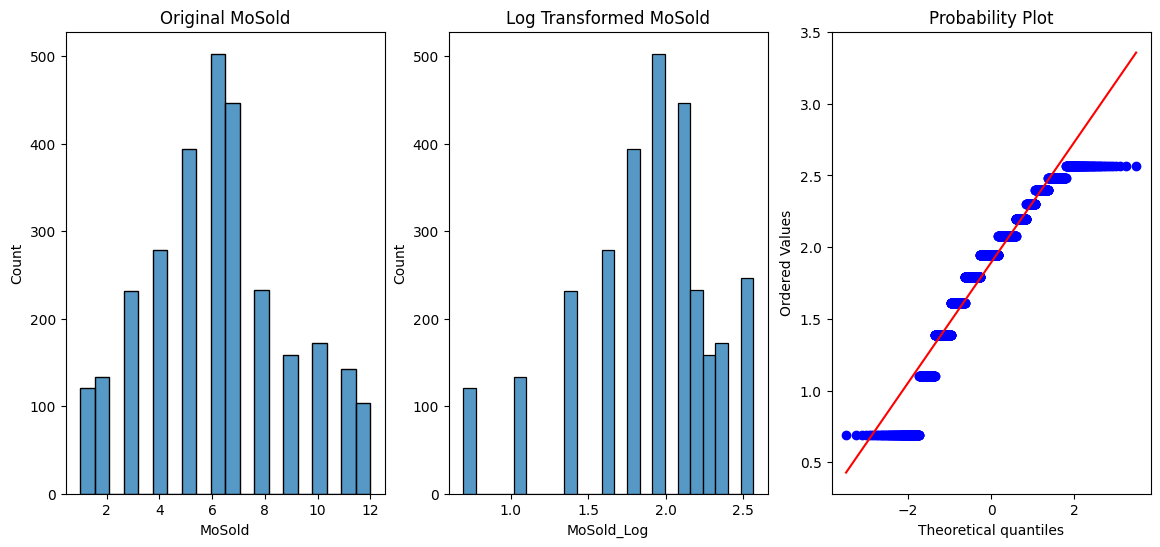

OverallQual Before Log: 0.1897 After Log: -0.6538


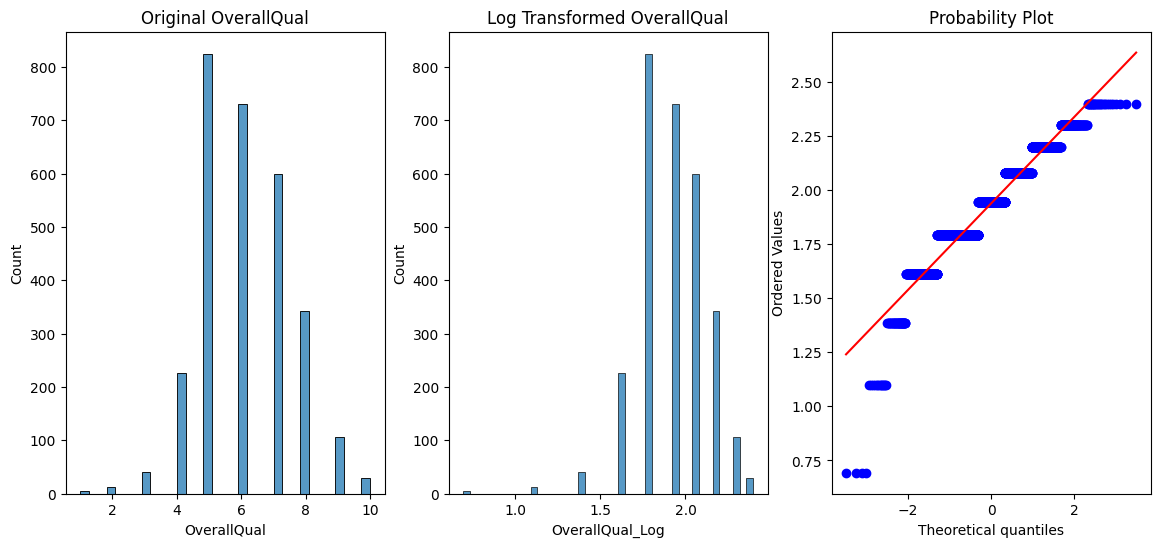

FullBath Before Log: 0.1656 After Log: -0.2498


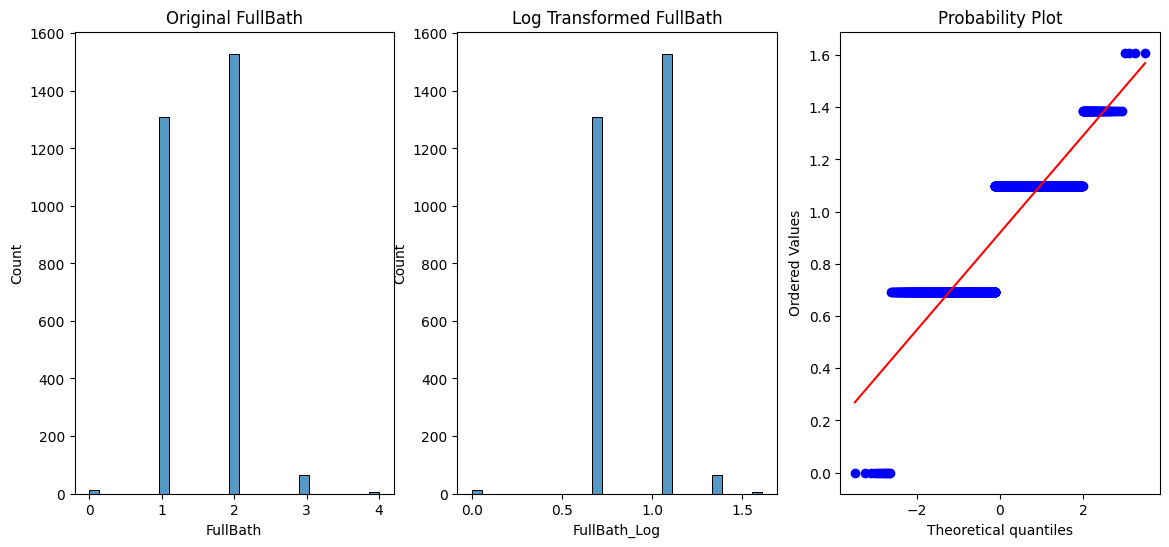

YrSold Before Log: 0.1321 After Log: 0.1313


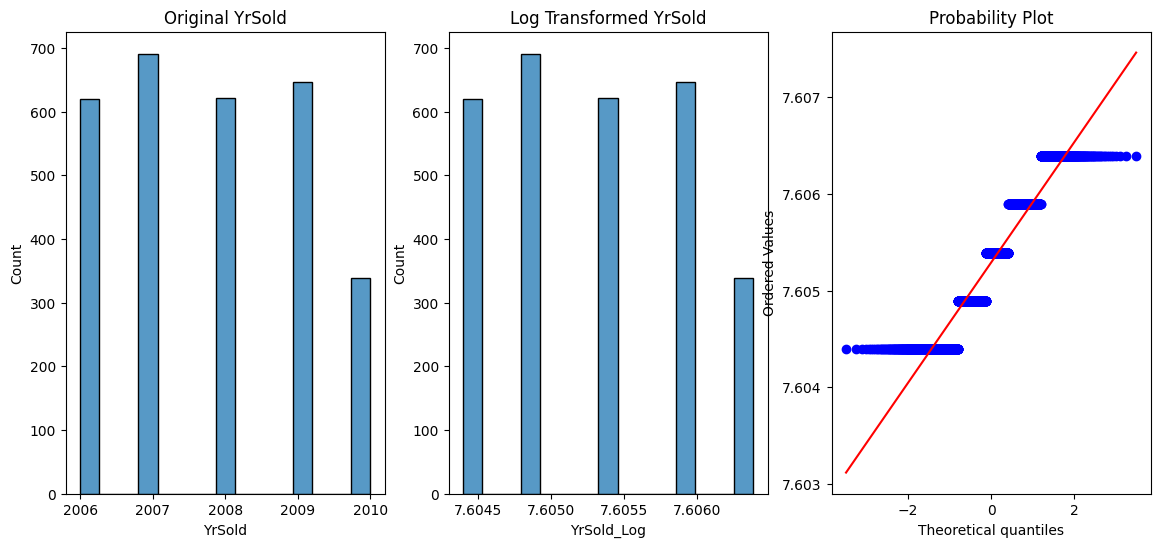

YearRemodAdd Before Log: -0.4504 After Log: -0.4575


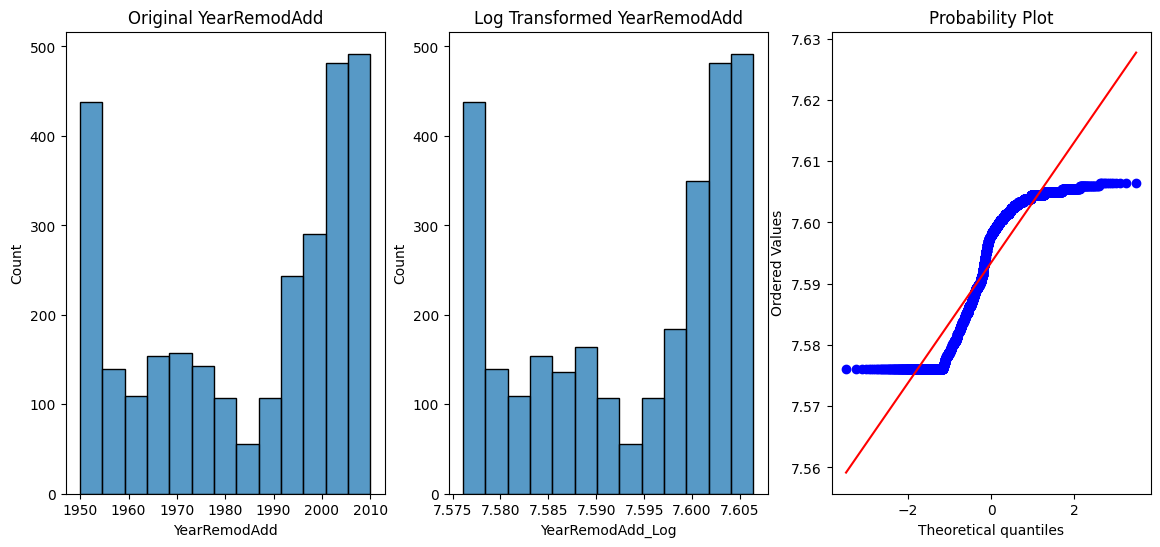

YearBuilt Before Log: -0.5995 After Log: -0.6259


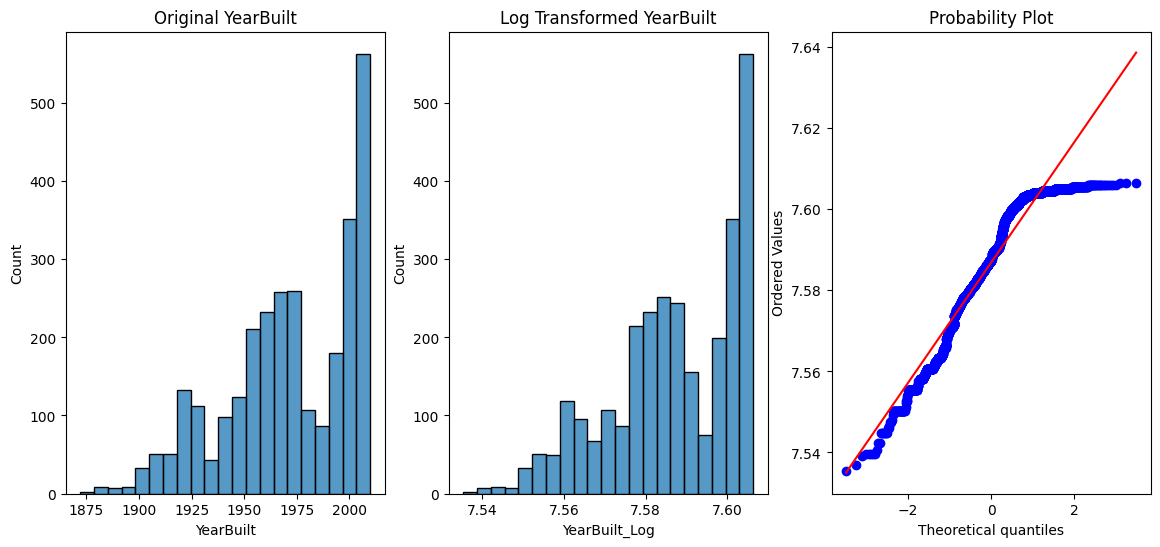

In [38]:
data = df.copy()
log_transform_features = filt_df_skew['Feature']
for col in log_transform_features:
    fig, axs = plt.subplots(1,3,figsize=(14,6))
    sns.histplot(data, x=col,ax=axs[0])
    axs[0].set_title('Original ' + col)
    data[col+'_Log']=np.log1p(data[col])
    sns.histplot(data, x=col+'_Log', ax=axs[1])
    axs[1].set_title('Log Transformed ' + col)
    res = stats.probplot(data[col+'_Log'], plot=plt)
    print(col, 'Before Log:', round(data[col].skew(),4), 'After Log:', round(data[col+'_Log'].skew(),4))
    plt.show()

The graphs above confirm log transformation is appropriate for the following features:
* 'LotArea'
* 'LotFrontage'
* 'GrLivArea'
* '1stFlrSF'

In [39]:
# List of numerical columns to log transform
log_transform_cols = ['LotArea', 'LotFrontage', 'GrLivArea', '1stFlrSF']

In [40]:
df[log_transform_cols] = np.log1p(df[log_transform_cols])
df[log_transform_cols].head()

LotArea  LotFrontage  GrLivArea  1stFlrSF
0  9.042040     4.189655   7.444833  6.753438
1  9.169623     4.394449   7.141245  7.141245
2  9.328212     4.234107   7.488294  6.825460
3  9.164401     4.110874   7.448916  6.869014
4  9.565284     4.442651   7.695758  7.044033

---
### Prepare for Ordinal Encoding

In [41]:
ordinal_features = [
    'Fence',
    'PoolQC',
    'GarageQual',
    'GarageCond',
    'PavedDrive',
    'GarageFinish',
    'FireplaceQu',
    'Functional',
    'LotShape',
    'Utilities',
    'LandSlope',
    'OverallQual',
    'OverallCond',
    'ExterQual',
    'ExterCond',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'HeatingQC',
    'Electrical',
    'KitchenQual'
]

In [42]:
# Ordinal Encode category order
ordinal_order = [
    ['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],  # 'Fence'
    ['None', 'Fa', 'TA', 'Gd', 'Ex'],  # 'PoolQC'
    ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # 'GarageQual'
    ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # 'GarageCond'
    ['N', 'P', 'Y'],  # 'PavedDrive'
    ['None', 'Unf', 'RFn', 'Fin'],  # 'GarageFinish'
    ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # 'FireplaceQu'
    ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],  # 'Functional'
    ['IR3', 'IR2', 'IR1', 'Reg'],  # 'LotShape'
    ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],  # 'Utilities'
    ['Sev', 'Mod', 'Gtl'],  # 'LandSlope'
    ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],  # 'OverallQual'
    ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],  # 'OverallCond'
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # 'ExterQual'
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # 'ExterCond'
    ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # 'BsmtQual'
    ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # 'BsmtCond'
    ['None', 'No', 'Mn', 'Av', 'Gd'],  # 'BsmtExposure'
    ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],  # 'BsmtFinType1'
    ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],  # 'BsmtFinType2'
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # 'HeatingQC'
    ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],  # 'Electrical'
    ['Po', 'Fa', 'TA', 'Gd', 'Ex']  # 'KitchenQual'
]

In [43]:
encoder = OrdinalEncoder(categories=ordinal_order)
df[ordinal_features] = encoder.fit_transform(df[ordinal_features])
df[ordinal_features].head()

Fence  PoolQC  GarageQual  GarageCond  PavedDrive  GarageFinish  \
0    0.0     0.0         3.0         3.0         2.0           2.0   
1    0.0     0.0         3.0         3.0         2.0           2.0   
2    0.0     0.0         3.0         3.0         2.0           2.0   
3    0.0     0.0         3.0         3.0         2.0           1.0   
4    0.0     0.0         3.0         3.0         2.0           2.0   

   FireplaceQu  Functional  LotShape  Utilities  LandSlope  OverallQual  \
0          0.0         7.0       3.0        3.0        2.0          6.0   
1          3.0         7.0       3.0        3.0        2.0          5.0   
2          3.0         7.0       2.0        3.0        2.0          6.0   
3          4.0         7.0       2.0        3.0        2.0          6.0   
4          3.0         7.0       2.0        3.0        2.0          7.0   

   OverallCond  ExterQual  ExterCond  BsmtQual  BsmtCond  BsmtExposure  \
0          4.0        3.0        2.0       4.0       3.0           1.0   
1          7.0        2.0        2.0       4.0       3.0           4.0   
2          4.0        3.0        2.0       4.0       3.0           2.0   
3          4.0        2.0        2.0       3.0       4.0           1.0   
4          4.0        3.0        2.0       4.0       3.0           3.0   

   BsmtFinType1  BsmtFinType2  HeatingQC  Electrical  KitchenQual  
0           6.0           1.0        4.0         4.0          3.0  
1           5.0           1.0        4.0         4.0          2.0  
2           6.0           1.0        4.0         4.0          3.0  
3           5.0           1.0        3.0         4.0          3.0  
4           6.0           1.0        4.0         4.0          3.0

---
# Prepare for One Hot Encoding

In [44]:
# One Hot Encode
nominal_features = [
    'SaleCondition',
    'MiscFeature',
    'GarageType',
    'RoofStyle',
    'RoofMatl',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'Foundation',
    'Heating',
    'CentralAir',
    'Street',
    'Alley',
    'LandContour',
    'LotConfig',
    'Neighborhood',
    'Condition1',
    'Condition2',
    'BldgType',
    'HouseStyle',
    'MSSubClass',
    'MSZoning',
    'SaleType'
]

In [45]:
onehot = OneHotEncoder(drop='first', sparse=False)
onehot_df = pd.DataFrame(onehot.fit_transform(df[nominal_features]), columns=onehot.get_feature_names_out(df[nominal_features].columns))
onehot_df.index = df.index
no_nominal_df = df.drop(nominal_features, axis=1)
df = pd.concat([no_nominal_df, onehot_df], axis=1)
df.columns = df.columns.astype(str)

---
# Prepare Discrete Standardization

In [46]:
discrete_features = [
    'MoSold',
    'GarageCars',
    'Fireplaces',
    'TotRmsAbvGrd',
    'KitchenAbvGr',
    'BedroomAbvGr',
    'HalfBath',
    'BsmtFullBath',
    'BsmtHalfBath',
    'FullBath',
    'YearBuilt',
    'YearRemodAdd',
    'GarageYrBlt',
    'YrSold'
]

In [47]:
df[discrete_features].describe()

MoSold   GarageCars   Fireplaces  TotRmsAbvGrd  KitchenAbvGr  \
count  2917.000000  2917.000000  2917.000000   2917.000000   2917.000000   
mean      6.213576     1.765513     0.596160      6.448063      1.044566   
std       2.713070     0.762102     0.644773      1.564281      0.214532   
min       1.000000     0.000000     0.000000      2.000000      0.000000   
25%       4.000000     1.000000     0.000000      5.000000      1.000000   
50%       6.000000     2.000000     1.000000      6.000000      1.000000   
75%       8.000000     2.000000     1.000000      7.000000      1.000000   
max      12.000000     5.000000     4.000000     15.000000      3.000000   

       BedroomAbvGr     HalfBath  BsmtFullBath  BsmtHalfBath     FullBath  \
count   2917.000000  2917.000000   2917.000000   2917.000000  2917.000000   
mean       2.860130     0.379842      0.428865      0.061364     1.567364   
std        0.822967     0.502782      0.523943      0.245687     0.552465   
min        0.000000     0.000000      0.000000      0.000000     0.000000   
25%        2.000000     0.000000      0.000000      0.000000     1.000000   
50%        3.000000     0.000000      0.000000      0.000000     2.000000   
75%        3.000000     1.000000      1.000000      0.000000     2.000000   
max        8.000000     2.000000      3.000000      2.000000     4.000000   

         YearBuilt  YearRemodAdd  GarageYrBlt       YrSold  
count  2917.000000   2917.000000  2917.000000  2917.000000  
mean   1971.287967   1984.248200  1870.201577  2007.792938  
std      30.286991     20.892257   449.790059     1.315328  
min    1872.000000   1950.000000     0.000000  2006.000000  
25%    1953.000000   1965.000000  1957.000000  2007.000000  
50%    1973.000000   1993.000000  1977.000000  2008.000000  
75%    2001.000000   2004.000000  2001.000000  2009.000000  
max    2010.000000   2010.000000  2010.000000  2010.000000

### Discrete temporal features such as 'YrSold' and 'YearBuilt'will be standardized on their own to avoid affecting distribution of remaining discrete features. Furthermore, the remaining variables can remain as-is and do not require intervention.

In [48]:
discrete_year_features = [
    'YearBuilt',
    'YearRemodAdd',
    'GarageYrBlt',
    'YrSold'
]
year_scaler = StandardScaler()
df[discrete_year_features]=year_scaler.fit_transform(df[discrete_year_features])
df[discrete_year_features].head()

YearBuilt  YearRemodAdd  GarageYrBlt    YrSold
0   1.047231      0.897702     0.295296  0.157449
1   0.155606     -0.394865     0.235258 -0.602948
2   0.981185      0.849829     0.290849  0.157449
3  -1.858805     -0.682102     0.284178 -1.363345
4   0.948161      0.754083     0.288625  0.157449

In [49]:
# Update discrete feature list to include remaining discrete features
discrete_features = [feature for feature in discrete_features if feature not in discrete_year_features]
discrete_scaler = StandardScaler()
df[discrete_features] = discrete_scaler.fit_transform(df[discrete_features])
df[discrete_features].head()

MoSold  GarageCars  Fireplaces  TotRmsAbvGrd  KitchenAbvGr  BedroomAbvGr  \
0 -1.553332    0.307738   -0.924763      0.992279     -0.207773      0.169987   
1 -0.447384    0.307738    0.626435     -0.286483     -0.207773      0.169987   
2  1.027214    0.307738    0.626435     -0.286483     -0.207773      0.169987   
3 -1.553332    1.620124    0.626435      0.352898     -0.207773      0.169987   
4  2.133162    1.620124    0.626435      1.631660     -0.207773      1.385311   

   HalfBath  BsmtFullBath  BsmtHalfBath  FullBath  
0  1.233664      1.090257     -0.249810  0.783237  
1 -0.755611     -0.818675      3.821109  0.783237  
2  1.233664      1.090257     -0.249810  0.783237  
3 -0.755611      1.090257     -0.249810 -1.027145  
4  1.233664      1.090257     -0.249810  0.783237

---
# Prepare continuous features for standardization

In [50]:
continuous_features = [
    'MiscVal',
    'PoolArea',
    'ScreenPorch',
    '3SsnPorch',
    'EnclosedPorch',
    'OpenPorchSF',
    'WoodDeckSF',
    'GarageArea',
    'LowQualFinSF',
    'GrLivArea',
    'MasVnrArea',
    'BsmtFinSF1',    
    '1stFlrSF',
    '2ndFlrSF',
    'BsmtFinSF2',
    'BsmtUnfSF',
    'TotalBsmtSF',
    'LotFrontage',
    'LotArea',
]

In [51]:
# Standardize continuous features with StandardScaler
scaler = StandardScaler()
df[continuous_features] = scaler.fit_transform(df[continuous_features])
df[continuous_features].head()

MiscVal  PoolArea  ScreenPorch  3SsnPorch  EnclosedPorch  OpenPorchSF  \
0 -0.089623 -0.060447    -0.286041  -0.103366      -0.359740     0.204447   
1 -0.089623 -0.060447    -0.286041  -0.103366      -0.359740    -0.704543   
2 -0.089623 -0.060447    -0.286041  -0.103366      -0.359740    -0.078681   
3 -0.089623 -0.060447    -0.286041  -0.103366       3.873564    -0.182991   
4 -0.089623 -0.060447    -0.286041  -0.103366      -0.359740     0.547181   

   WoodDeckSF  GarageArea  LowQualFinSF  GrLivArea  MasVnrArea  BsmtFinSF1  \
0   -0.740089    0.352788     -0.101232   0.570217    0.534087    0.601514   
1    1.615438   -0.057038     -0.101232  -0.369529   -0.567024    1.213983   
2   -0.740089    0.632214     -0.101232   0.704747    0.343078    0.106135   
3   -0.740089    0.790556     -0.101232   0.582855   -0.567024   -0.501830   
4    0.777566    1.694035     -0.101232   1.346946    1.399246    0.486676   

   1stFlrSF  2ndFlrSF  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  LotFrontage  \
0 -0.778480  1.210473   -0.293134  -0.933762    -0.449391    -0.045303   
1  0.429642 -0.784638   -0.293134  -0.628956     0.496118     0.595792   
2 -0.554112  1.238507   -0.293134  -0.287754    -0.300345     0.093850   
3 -0.418429  0.981526   -0.293134  -0.046639    -0.682275    -0.291921   
4  0.126800  1.675376   -0.293134  -0.160373     0.223644     0.746685   

    LotArea  
0 -0.101761  
1  0.149435  
2  0.461682  
3  0.139155  
4  0.928451

---
# Log Transform Target Variable: SalePrice

In [52]:
target = df.pop('SalePrice')
target.dropna(inplace=True)

# Log Transform SalePrice
target = np.log1p(target)
target.head(1)

0    12.247699
Name: SalePrice, dtype: float64

---
# Final confirmation

In [53]:
print(df.shape)
df.head()

(2917, 213)


Id  LotFrontage   LotArea  LotShape  Utilities  LandSlope  OverallQual  \
0   1    -0.045303 -0.101761       3.0        3.0        2.0          6.0   
1   2     0.595792  0.149435       3.0        3.0        2.0          5.0   
2   3     0.093850  0.461682       2.0        3.0        2.0          6.0   
3   4    -0.291921  0.139155       2.0        3.0        2.0          6.0   
4   5     0.746685  0.928451       2.0        3.0        2.0          7.0   

   OverallCond  YearBuilt  YearRemodAdd  MasVnrArea  ExterQual  ExterCond  \
0          4.0   1.047231      0.897702    0.534087        3.0        2.0   
1          7.0   0.155606     -0.394865   -0.567024        2.0        2.0   
2          4.0   0.981185      0.849829    0.343078        3.0        2.0   
3          4.0  -1.858805     -0.682102   -0.567024        2.0        2.0   
4          4.0   0.948161      0.754083    1.399246        3.0        2.0   

   BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinSF1  BsmtFinType2  \
0       4.0       3.0           1.0           6.0    0.601514           1.0   
1       4.0       3.0           4.0           5.0    1.213983           1.0   
2       4.0       3.0           2.0           6.0    0.106135           1.0   
3       3.0       4.0           1.0           5.0   -0.501830           1.0   
4       4.0       3.0           3.0           6.0    0.486676           1.0   

   BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  HeatingQC  Electrical  1stFlrSF  \
0   -0.293134  -0.933762    -0.449391        4.0         4.0 -0.778480   
1   -0.293134  -0.628956     0.496118        4.0         4.0  0.429642   
2   -0.293134  -0.287754    -0.300345        4.0         4.0 -0.554112   
3   -0.293134  -0.046639    -0.682275        3.0         4.0 -0.418429   
4   -0.293134  -0.160373     0.223644        4.0         4.0  0.126800   

   2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  \
0  1.210473     -0.101232   0.570217      1.090257     -0.249810  0.783237   
1 -0.784638     -0.101232  -0.369529     -0.818675      3.821109  0.783237   
2  1.238507     -0.101232   0.704747      1.090257     -0.249810  0.783237   
3  0.981526     -0.101232   0.582855      1.090257     -0.249810 -1.027145   
4  1.675376     -0.101232   1.346946      1.090257     -0.249810  0.783237   

   HalfBath  BedroomAbvGr  KitchenAbvGr  KitchenQual  TotRmsAbvGrd  \
0  1.233664      0.169987     -0.207773          3.0      0.992279   
1 -0.755611      0.169987     -0.207773          2.0     -0.286483   
2  1.233664      0.169987     -0.207773          3.0     -0.286483   
3 -0.755611      0.169987     -0.207773          3.0      0.352898   
4  1.233664      1.385311     -0.207773          3.0      1.631660   

   Functional  Fireplaces  FireplaceQu  GarageYrBlt  GarageFinish  GarageCars  \
0         7.0   -0.924763          0.0     0.295296           2.0    0.307738   
1         7.0    0.626435          3.0     0.235258           2.0    0.307738   
2         7.0    0.626435          3.0     0.290849           2.0    0.307738   
3         7.0    0.626435          4.0     0.284178           1.0    1.620124   
4         7.0    0.626435          3.0     0.288625           2.0    1.620124   

   GarageArea  GarageQual  GarageCond  PavedDrive  WoodDeckSF  OpenPorchSF  \
0    0.352788         3.0         3.0         2.0   -0.740089     0.204447   
1   -0.057038         3.0         3.0         2.0    1.615438    -0.704543   
2    0.632214         3.0         3.0         2.0   -0.740089    -0.078681   
3    0.790556         3.0         3.0         2.0   -0.740089    -0.182991   
4    1.694035         3.0         3.0         2.0    0.777566     0.547181   

   EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  PoolQC  Fence   MiscVal  \
0      -0.359740  -0.103366    -0.286041 -0.060447     0.0    0.0 -0.089623   
1      -0.359740  -0.103366    -0.286041 -0.060447     0.0    0.0 -0.089623   
2      -0.359740  -0.103366    -0.286041 -0.060447     0.0    0.0 -0.08962

---
# Resplit data back into df_train, df_test, and target

In [54]:
# Split data back into df_train_updated
df_train = df[df['Id'].isin(df_train['Id'])]
df_train

Id  LotFrontage   LotArea  LotShape  Utilities  LandSlope  \
0        1    -0.045303 -0.101761       3.0        3.0        2.0   
1        2     0.595792  0.149435       3.0        3.0        2.0   
2        3     0.093850  0.461682       2.0        3.0        2.0   
3        4    -0.291921  0.139155       2.0        3.0        2.0   
4        5     0.746685  0.928451       2.0        3.0        2.0   
...    ...          ...       ...       ...        ...        ...   
1455  1456    -0.190931 -0.230027       3.0        3.0        2.0   
1456  1457     0.783299  0.772649       3.0        3.0        2.0   
1457  1458     0.001772  0.031545       3.0        3.0        2.0   
1458  1459     0.093850  0.173284       3.0        3.0        2.0   
1459  1460     0.396334  0.217359       3.0        3.0        2.0   

      OverallQual  OverallCond  YearBuilt  YearRemodAdd  MasVnrArea  \
0             6.0          4.0   1.047231      0.897702    0.534087   
1             5.0          7.0   0.155606     -0.394865   -0.567024   
2             6.0          4.0   0.981185      0.849829    0.343078   
3             6.0          4.0  -1.858805     -0.682102   -0.567024   
4             7.0          4.0   0.948161      0.754083    1.399246   
...           ...          ...        ...           ...         ...   
1455          5.0          4.0   0.915138      0.754083   -0.567024   
1456          5.0          5.0   0.221652      0.179609    0.101508   
1457          6.0          8.0  -1.000204      1.041320   -0.567024   
1458          4.0          5.0  -0.702995      0.562592   -0.567024   
1459          4.0          5.0  -0.207648     -0.921466   -0.567024   

      ExterQual  ExterCond  BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  \
0           3.0        2.0       4.0       3.0           1.0           6.0   
1           2.0        2.0       4.0       3.0           4.0           5.0   
2           3.0        2.0       4.0       3.0           2.0           6.0   
3           2.0        2.0       3.0       4.0           1.0           5.0   
4           3.0        2.0       4.0       3.0           3.0           6.0   
...         ...        ...       ...       ...           ...           ...   
1455        2.0        2.0       4.0       3.0           1.0           1.0   
1456        2.0        2.0       4.0       3.0           1.0           5.0   
1457        4.0        3.0       3.0       4.0           1.0           6.0   
1458        2.0        2.0       3.0       3.0           2.0           6.0   
1459        3.0        2.0       3.0       3.0           1.0           4.0   

      BsmtFinSF1  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  HeatingQC  \
0       0.601514           1.0   -0.293134  -0.933762    -0.449391        4.0   
1       1.213983           1.0   -0.293134  -0.628956     0.496118        4.0   
2       0.106135           1.0   -0.293134  -0.287754    -0.300345        4.0   
3      -0.501830           1.0   -0.293134  -0.046639    -0.682275        3.0   
4       0.486676           1.0   -0.293134  -0.160373     0.223644        4.0   
...          ...           ...         ...        ...          ...        ...   
1455   -0.988202           1.0   -0.293134   0.892801    -0.223494        4.0   
1456    0.790659           3.0    0.670205   0.064820     1.148193        2.0   
1457   -0.368978           1.0   -0.293134   0.719926     0.239946        4.0   
1458   -0.877868           3.0    5.788314  -1.274963     0.067611        3.0   
1459    0.880728           2.0    1.420782  -0.965607     0.482145        3.0   

      Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  \
0            4.0 -0.778480  1.210473     -0.101232   0.570217      1.090257   
1            4.0  0.429642 -0.784638     -0.101232  -0.369529     -0.818675   
2            4.0 -0.554112  1.238507     -0.101232   0.704747      1.090257   
3            4.0 -0.418429  0.981526     -0.101232   0.582855      1.090257   
4            4.0  0.1

In [55]:
# Filter the test data and ensure 'SalePrice' is not included
df_test = df[df['Id'].isin(df_test['Id'])]
df_test

Id  LotFrontage   LotArea  LotShape  Utilities  LandSlope  \
1460  1461     0.595792  0.525728       3.0        3.0        2.0   
1461  1462     0.634203  0.929417       2.0        3.0        2.0   
1462  1463     0.354871  0.868171       2.0        3.0        2.0   
1463  1464     0.517527  0.225465       2.0        3.0        2.0   
1464  1465    -1.314584 -1.132768       2.0        3.0        2.0   
...    ...          ...       ...       ...        ...        ...   
2914  2915    -3.484433 -3.002228       3.0        3.0        2.0   
2915  2916    -3.484433 -3.045389       3.0        3.0        2.0   
2916  2917     2.746258  1.594437       3.0        3.0        2.0   
2917  2918    -0.190931  0.314761       3.0        3.0        2.0   
2918  2919     0.354871  0.154965       3.0        3.0        1.0   

      OverallQual  OverallCond  YearBuilt  YearRemodAdd  MasVnrArea  \
1460          4.0          5.0  -0.339741     -1.112957   -0.567024   
1461          5.0          5.0  -0.438810     -1.256576    0.039711   
1462          4.0          4.0   0.849092      0.658338   -0.567024   
1463          5.0          5.0   0.882115      0.658338   -0.454666   
1464          7.0          4.0   0.683976      0.371101   -0.567024   
...           ...          ...        ...           ...         ...   
2914          3.0          6.0  -0.042533     -0.682102   -0.567024   
2915          3.0          4.0  -0.042533     -0.682102   -0.567024   
2916          4.0          6.0  -0.372764      0.562592   -0.567024   
2917          4.0          4.0   0.683976      0.371101   -0.567024   
2918          6.0          4.0   0.716999      0.466846   -0.038940   

      ExterQual  ExterCond  BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  \
1460        2.0        2.0       3.0       3.0           1.0           3.0   
1461        2.0        2.0       3.0       3.0           1.0           5.0   
1462        2.0        2.0       4.0       3.0           1.0           6.0   
1463        2.0        2.0       3.0       3.0           1.0           6.0   
1464        3.0        2.0       4.0       3.0           1.0           5.0   
...         ...        ...       ...       ...           ...           ...   
2914        2.0        2.0       3.0       3.0           1.0           1.0   
2915        2.0        2.0       3.0       3.0           1.0           3.0   
2916        2.0        2.0       3.0       3.0           1.0           5.0   
2917        2.0        2.0       4.0       3.0           3.0           6.0   
2918        2.0        2.0       4.0       3.0           3.0           2.0   

      BsmtFinSF1  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  HeatingQC  \
1460    0.065604           2.0    0.557914  -0.660801    -0.388841        2.0   
1461    1.090138           1.0   -0.293134  -0.351445     0.652150        2.0   
1462    0.792911           1.0   -0.293134  -0.963333    -0.281715        3.0   
1463    0.367335           1.0   -0.293134  -0.537969    -0.286372        4.0   
1464   -0.395999           1.0   -0.293134   1.038380     0.538037        4.0   
...          ...           ...         ...        ...          ...        ...   
2914   -0.988202           1.0   -0.293134  -0.032991    -1.171331        3.0   
2915   -0.420768           1.0   -0.293134  -0.606209    -1.171331        2.0   
2916    1.767907           1.0   -0.293134  -1.274963     0.407622        4.0   
2917   -0.229372           1.0   -0.293134   0.032975    -0.318976        2.0   
2918    0.718604           1.0   -0.293134  -0.733591    -0.123353        4.0   

      Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  \
1460         4.0 -0.636368 -0.784638     -0.101232  -1.428764     -0.818675   
1461         4.0  0.590667 -0.784638     -0.101232  -0.209527     -0.818675   
1462         4.0 -0.527169  0.853035     -0.101232   0.420093     -0.818675   
1463         4.0 -0.533883  0.799303     -0.101232   0.372249     -0.818675   
1464         4.0  0.4

In [56]:
# Verify the shapes
print("Training shape:", df_train.shape)
print("Target shape:", target.shape)
print("Test shape:", df_test.shape)

Training shape: (1458, 213)
Target shape: (1458,)
Test shape: (1459, 213)


---
# Model Building
### Create X, y, and target variable sets

In [57]:
train_id = df_train.pop('Id')
X = df_train.copy()
y = target.copy()
test_id = df_test.pop('Id')
test = df_test.copy()

---
# Split into train-test sets

In [58]:
# Divide data into training and validation subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)
X_train.shape, X_test. shape, y_train.shape, y_test.shape

((1166, 212), (292, 212), (1166,), (292,))

---
# Create models
0. Dummy Regressor
1. Linear Regression
2. Ridge
3. Lasso
4. ElasticNet
5. Decision Tree
6. Random Forest
7. Gradient Boosting
8. XGBoost
9. Support Vector Regression
10. K-Neighbors Regressor

In [59]:
# Create baseline score via DummyRegressor
baseline = DummyRegressor(strategy='mean')

# Create Linear Regression model
lr = LinearRegression(n_jobs=-1)

# Create Ridge Regression model (L2 Regularization)
ridge = Ridge(random_state=42)

# Create Lasso Regression model (L1 Regularization)
lasso = Lasso(random_state=42)

# Create ElasticNet model
elasticnet = ElasticNet(random_state=42,)

# Create Decision Tree model
dt = DecisionTreeRegressor(random_state=42)

# Create Random Forest model
rf = RandomForestRegressor(random_state=42)

# Create Gradient Boosting model
gb = GradientBoostingRegressor(random_state=42)

# Create XGBoost model
xgb = XGBRegressor()

# Create Support Vector Regression model
svr = SVR()

# Create K-Neighbor Regression model
knr = KNeighborsRegressor()

In [60]:
models = [
    baseline,
    lr,
    ridge,
    lasso,
    elasticnet,
    dt,
    rf,
    gb,
    xgb,
    svr,
    knr
]

In [61]:
model_dict = {
    0: 'Dummy Regressor',
    1: 'Linear Regression',
    2: 'Ridge', 
    3: 'Lasso', 
    4: 'ElasticNet',
    5: 'Decision Tree',
    6: 'Random Forest',
    7: 'Gradient Boosting',
    8: 'XGBoost',
    9: 'Support Vector Regression',
    10: 'K-Neighbors Regressor'
}

In [62]:
results = []
for i, model in enumerate(models):
    # Track the time taken to fit the model
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    fit_time = end_time - start_time
    
    scores = -1 * cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    mae = scores.mean()
    
    results.append({
        'Model': model_dict[i],
        'MAE': mae,
        'Fit Time (s)': fit_time
    })
    
# Convert the results list into a DataFrame
results_df = pd.DataFrame(results).sort_values(by='MAE', ascending=True)
results_df

Model           MAE  Fit Time (s)
2                       Ridge  8.031731e-02      0.014528
9   Support Vector Regression  8.354340e-02      0.070683
7           Gradient Boosting  8.738687e-02      0.893029
8                     XGBoost  9.585539e-02      0.607884
6               Random Forest  9.672713e-02      2.570644
10      K-Neighbors Regressor  1.202545e-01      0.007579
5               Decision Tree  1.483217e-01      0.046554
0             Dummy Regressor  3.069597e-01      0.000800
3                       Lasso  3.069597e-01      0.011138
4                  ElasticNet  3.069597e-01      0.007974
1           Linear Regression  1.440307e+09      0.052713

---
# Hyperparameter Tuning
Top 5 models are: Ridge, Support Vector Regression, Gradient Boosting, XGBoost, RandomForest. Will use GridSearchCV to find best model parameters.

In [63]:
# Hyperparameter grids for each model
param_grids = {
    'Ridge': {'alpha': [0.01, 0.1, 1.0, 10, 100]},
    'SVR': {'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1, 0.2], 'kernel': ['linear', 'rbf']},
    'GradientBoosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]},
    'XGBoost': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7], 'subsample': [0.7, 0.8, 0.9]},
    'RandomForest': {'n_estimators': [100, 200], 'max_depth': [5, 10, 15], 'min_samples_split': [2, 5]}
}

# Model initializations
models = {
    'Ridge': ridge,
    'SVR': svr,
    'GradientBoosting': gb,
    'XGBoost': xgb,
    'RandomForest': rf
}

grid_results = []

# Loop over models and parameter grids
for model_name, model in models.items():
    print(f"Tuning {model_name}...")
    param_grid = param_grids[model_name]

    # RandomizedSearchCV setup
    random_search = RandomizedSearchCV(model, param_grid, n_iter=10, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, random_state=42)
    
    # Time tracking
    start_time = time.time()
    random_search.fit(X_train, y_train)
    end_time = time.time()
    fit_time = end_time - start_time

    # Get the best model and parameters
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_
    best_score = random_search.best_score_

    # Store results
    grid_results.append({
        'Model': model_name,
        'Best Score': -best_score,  # best_score is negative
        'Best Params': best_params,
        'Fit Time (s)': fit_time
    })

# Convert results to DataFrame and sort by MAE
grid_results_df = pd.DataFrame(grid_results).sort_values(by='Best Score', ascending=True)
grid_results_df

Tuning Ridge...
Tuning SVR...
Tuning GradientBoosting...
Tuning XGBoost...
Tuning RandomForest...


Model  Best Score  \
1               SVR    0.077449   
0             Ridge    0.078077   
3           XGBoost    0.085231   
2  GradientBoosting    0.087579   
4      RandomForest    0.097792   

                                         Best Params  Fit Time (s)  
1    {'kernel': 'linear', 'epsilon': 0.01, 'C': 0.1}      7.103482  
0                                      {'alpha': 10}      0.370996  
3  {'subsample': 0.8, 'n_estimators': 200, 'max_d...     11.350315  
2  {'n_estimators': 200, 'max_depth': 3, 'learnin...     14.313200  
4  {'n_estimators': 200, 'min_samples_split': 2, ...     27.142765

### SVR and Ridge produced best results. Next, I will run GridSearchCV to optimize parameters prior to final fitting

In [64]:
# Define the parameter grids
param_grid_svr = {'C': [0.05, 0.1, 0.2], 'epsilon': [0.005, 0.01, 0.02], 'kernel': ['linear']}
param_grid_ridge = {'alpha': [5, 10, 15, 20]}

# GridSearchCV for SVR
grid_svr = GridSearchCV(svr, param_grid_svr, scoring='neg_mean_absolute_error', cv=5)
grid_svr.fit(X_train, y_train)

# GridSearchCV for Ridge
grid_ridge = GridSearchCV(ridge, param_grid_ridge, scoring='neg_mean_absolute_error', cv=5)
grid_ridge.fit(X_train, y_train)

# Get the best parameters and scores
print("Best SVR Params:", grid_svr.best_params_)
print("Best SVR Score:", -grid_svr.best_score_)
print("Best Ridge Params:", grid_ridge.best_params_)
print("Best Ridge Score:", -grid_ridge.best_score_)

Best SVR Params: {'C': 0.05, 'epsilon': 0.01, 'kernel': 'linear'}
Best SVR Score: 0.0750772809877511
Best Ridge Params: {'alpha': 15}
Best Ridge Score: 0.07725902157721565


In [65]:
best_svr = grid_svr.best_estimator_
best_ridge = grid_ridge.best_estimator_

svr_pred = best_svr.predict(X_test)
ridge_pred = best_ridge.predict(X_test)

# Calculate MAE for both models
svr_mae = mean_absolute_error(y_test, svr_pred)
ridge_mae = mean_absolute_error(y_test, ridge_pred)

# Print the results
print(f"SVR Test MAE: {svr_mae:.5f}")
print(f"Ridge Test MAE: {ridge_mae:.5f}")

SVR Test MAE: 0.07873
Ridge Test MAE: 0.07835


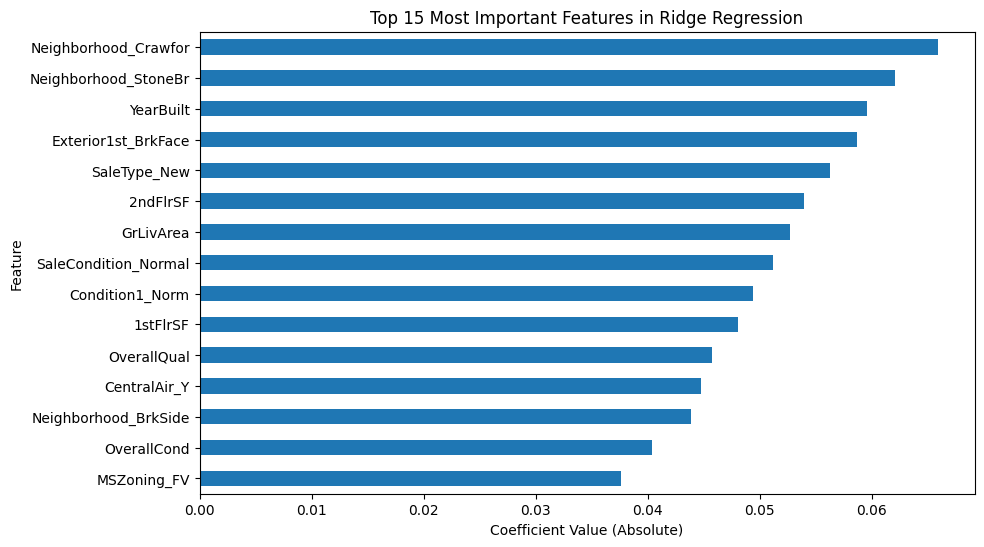

In [66]:
# Get the coefficients from the trained Ridge model
ridge_coefficients = best_ridge.coef_

# Pair the coefficients with the feature names
feature_importance = pd.Series(ridge_coefficients, index=X_train.columns)

# Sort the features by importance
sorted_importance = feature_importance.abs().sort_values(ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sorted_importance[:15].plot(kind='barh')
plt.title('Top 15 Most Important Features in Ridge Regression')
plt.xlabel('Coefficient Value (Absolute)')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # Invert y-axis to show the largest values at the top
plt.show()

In [67]:
best_ridge.fit(X,y)
y_pred = best_ridge.predict(test)
y_pred = np.expm1(y_pred)
y_pred

array([114949.14183362, 157907.57763351, 181423.49139707, ...,
       173003.44381286, 118484.33671504, 223327.35382774])

In [68]:
df_sub = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')
df_sub

Id      SalePrice
0     1461  169277.052498
1     1462  187758.393989
2     1463  183583.683570
3     1464  179317.477511
4     1465  150730.079977
...    ...            ...
1454  2915  167081.220949
1455  2916  164788.778231
1456  2917  219222.423400
1457  2918  184924.279659
1458  2919  187741.866657

[1459 rows x 2 columns]

In [69]:
submission = pd.DataFrame({
    'Id': test_id,
    'SalePrice': y_pred
})
submission

Id      SalePrice
1460  1461  114949.141834
1461  1462  157907.577634
1462  1463  181423.491397
1463  1464  198201.434039
1464  1465  195174.822417
...    ...            ...
2914  2915   87572.820950
2915  2916   80090.397635
2916  2917  173003.443813
2917  2918  118484.336715
2918  2919  223327.353828

[1459 rows x 2 columns]

In [70]:
# Save to CSV
submission.to_csv('submission.csv', index=False)